# 0.0 DATA IMPORTS

In [1]:
!pip install inflection
!pip install boruta

     |████████████████████████████████| 61kB 1.9MB/s 


In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import inflection
import datetime

from matplotlib             import pyplot as plt
from IPython.core.display   import HTML
from IPython.display        import Image
from scipy                  import stats as stats
from boruta                 import BorutaPy

from sklearn.ensemble       import RandomForestRegressor
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.linear_model   import LinearRegression, Lasso, Ridge, ElasticNet

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option( 'display.expand_frame_repr', False )    
    sns.set()

jupyter_settings()

def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def cramer_v(x, y):
    # Contingency Table (all combinations between categorical variables)
    cm = pd.crosstab(x, y)
    
    #chi2
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    phi = chi2/n
    phibiascorrect = max(0, phi - (k-1)*(r-1)/(n-1))
    k_denominator = k - (k-1)**2 / (n-1)
    r_denominator = r - (r-1)**2 / (n-1) 
    denominator = min(k_denominator-1, r_denominator-1)
    return np.sqrt(phibiascorrect / denominator)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])
    

def cross_validation(dataset, model_name, model, kfold, verbose = False): # x_training tem todo o dataset já transformado.
    mae_list = []
    mape_list = []
    rmse_list = []
    v1 = dataset.copy()
    for k in range(1, kfold+1):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        # # # creating date limits for validation data. 
        
        validation_start_date = v1['date'].min() + datetime.timedelta(days = k*6*7) 
        validation_end_date = v1['date'].min() + datetime.timedelta(days = (k+1)*6*7)

        # # # filtering dataset for k-folds
        training = v1[v1['date'] < validation_start_date]
        validation = v1[(v1['date'] >= validation_start_date) & (v1['date'] < validation_end_date)]
        
        # # # Rescaling on training dataset
        
        rs = RobustScaler()
        mms = MinMaxScaler()
        boxcox = PowerTransformer(method = 'box-cox')
        yeojohn = PowerTransformer(method = 'yeo-johnson')

        # # RobustScaler
        # promo2_time_week (weeks of promo2 since it started)
        rs_promo2_time_week = rs.fit(training[['promo2_time_week']].values)
        training['promo2_time_week'] = rs_promo2_time_week.transform(training[['promo2_time_week']].values)
        validation['promo2_time_week'] = rs_promo2_time_week.transform(validation[['promo2_time_week']].values)
        # promo2_time_month (months of promo2 since it started)
        rs_promo2_time_month = rs.fit(training[['promo2_time_month']].values)
        training['promo2_time_month'] = rs_promo2_time_month.transform(training[['promo2_time_month']].values)
        validation['promo2_time_month'] = rs_promo2_time_month.transform(validation[['promo2_time_month']].values)

        # # box-cox
        # competition_distance
        boxcox_competition_distance = boxcox.fit(training[['competition_distance']].values)
        training['competition_distance'] = boxcox_competition_distance.transform(training[['competition_distance']].values)
        validation['competition_distance'] = boxcox_competition_distance.transform(validation[['competition_distance']].values)
        # competition_since_month (months of competition since it started)
        yeojohn_competition_since_month = yeojohn.fit(training[['competition_since_month']].values)
        training['competition_since_month'] = yeojohn_competition_since_month.transform(training[['competition_since_month']].values)
        validation['competition_since_month'] = yeojohn_competition_since_month.transform(validation[['competition_since_month']].values)
        # customers
        boxcox_customers = boxcox.fit(training[['customers']].values)
        training['customers'] = boxcox_customers.transform(training[['customers']].values)
        validation['customers'] = boxcox_customers.transform(validation[['customers']].values)

        # # MinMaxScaler
        # year
        mms_year = mms.fit(training[['year']].values)
        training['year'] = mms_year.transform( training[['year']].values)
        validation['year'] = mms_year.transform( validation[['year']].values)

        # # # Concatenating data to perform label encoding
        le = LabelEncoder()
        all_data = pd.concat((training, validation)).reset_index(drop = True)

        # # One Hot Encoding
        # state_holiday 
        all_data = pd.get_dummies(all_data, prefix = ['state_holiday'], columns = ['state_holiday'])
        # promo2_since_year
        all_data['promo2_since_year'] = all_data['promo2_since_year'].astype(str)
        all_data = pd.get_dummies(all_data, prefix = ['promo2_since_year'], columns = ['promo2_since_year'])

        # # Ordinal Encoding
        # assortment
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        all_data['assortment'] = all_data['assortment'].map( assortment_dict )

        # # Label Encoding
        # store_type
        le_store_type = le.fit(all_data['store_type'])
        all_data['store_type'] = le_store_type.transform(all_data['store_type'])
        # competition_open_since_year
        all_data['competition_open_since_year'] = all_data['competition_open_since_year'].astype(str)
        le_competition_open_since_year = le.fit(all_data['competition_open_since_year'])
        all_data['competition_open_since_year'] = le_competition_open_since_year.transform(all_data['competition_open_since_year'])

        # target transformation (log)
        all_data['sales'] = np.log1p(all_data['sales']);


        ## nature transform
        # month
        all_data['month_sin'] = all_data['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        all_data['month_cos'] = all_data['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
        # day
        all_data['day_sin'] = all_data['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        all_data['day_cos'] = all_data['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
        # week_of_year (W)
        all_data['week_of_year_sin'] = all_data['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        all_data['week_of_year_cos'] = all_data['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
        # day_of_week
        all_data['day_of_week_sin'] = all_data['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        all_data['day_of_week_cos'] = all_data['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        # promo2_since_week
        all_data['promo2_since_week_sin'] = all_data['promo2_since_week'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        all_data['promo2_since_week_cos'] = all_data['promo2_since_week'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'promo2_since_week', 
                    'competition_since', 'year_week', 'year_month', 'gdp','cpi','interest_rate','unemployment_rate','cci']
        all_data = all_data.drop( cols_drop, axis=1 )

        # # # creating date limits for validation data. 
        
        validation_start_date = all_data['date'].min() + datetime.timedelta(days = k*6*7) 
        validation_end_date = all_data['date'].min() + datetime.timedelta(days = (k+1)*6*7)

        # # # filtering dataset for k-folds
        training = all_data[all_data['date'] < validation_start_date]
        validation = all_data[(all_data['date'] >= validation_start_date) & (all_data['date'] < validation_end_date)]
        
        # training dataset
        xtraining = training.copy()
        ytraining = xtraining['sales']

        # validation dataset
        xvalidation = validation.copy()
        yvalidation = xvalidation['sales']


        cols_boruta = ['store', 'customers', 'is_weekday', 'store_type', 'assortment','competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'competition_since_month',
                       'promo', 'promo2', 'promo2_time_week', 'promo2_time_month', 'promo2_since_year_2009', 'promo2_since_year_2010', 'promo2_since_year_2011', 'promo2_since_year_2012', 'promo2_since_year_2013', 'promo2_since_year_2014', 'promo2_since_year_2015',
                       'month_sin','month_cos', 'day_sin', 'day_cos','week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'promo2_since_week_sin', 'promo2_since_week_cos']


        # from dataset already splitted, use only boruta selected features for single ML model creation. 
        x_training = xtraining[ cols_boruta ]
        x_validation = xvalidation[ cols_boruta ]
    
        # model
        m = model.fit(x_training, ytraining)
        # prediction
        yhat = m.predict(x_validation)
        # performance
        result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])
       
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE CV':  round(np.mean(mae_list),2).astype(str) +  ' +- ' + round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': round(np.mean(mape_list),2).astype(str) + ' +- ' + round(np.std(mape_list),2).astype(str),
                         'RMSE CV': round(np.mean(rmse_list),2).astype(str) + ' +- ' + round(np.std(rmse_list),2).astype(str)}, index = [0])


Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# load dataset
df_store_raw = pd.read_csv('/home/alan/Sales-Prediction/data/store.csv', low_memory=False)
df_sales_raw = pd.read_csv('/home/alan/Sales-Prediction/data/train.csv', low_memory=False)
# df_store_raw = pd.read_csv('store.csv', low_memory=False)
# df_sales_raw = pd.read_csv('train.csv', low_memory=False)



In [5]:
# check dataset shape and column names
print(df_store_raw.shape) # 1115 stores, 10 columns
print(df_sales_raw.shape) #1017209 sales, 9 columns
print(df_sales_raw.columns.to_list()) #1017209 sales, 9 columns
print(df_store_raw.columns.to_list()) # 1115 stores, 10 columns

(1115, 10)
(1017209, 9)
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


In [6]:
# merge sales and store datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 0.3. Splitting Datasets

In [22]:
# check dates to split data
print( ' min date: {} '.format(df_raw['Date'].max()))
print( ' max date: {} '.format(df_raw['Date'].min()))

 min date: 2015-07-31 
 max date: 2013-01-01 


In [8]:
### split Data
# training dataset
train = df_raw[df_raw['Date'] < '2015-06-19'] # whole dataset minus last 6 weeks
# validation dataset
valid = df_raw[df_raw['Date'] >= '2015-06-19'] # last 6 weeks

# check dates
print( 'Train min date:{}'.format(train['Date'].min()))
print( 'Train max date:{}'.format(train['Date'].max()))
print( '\nValid min date:{}'.format(valid['Date'].min()))
print( 'Valid max date:{}'.format(valid['Date'].max()))

Train min date:2013-01-01
Train max date:2015-06-18

Valid min date:2015-06-19
Valid max date:2015-07-31


# 1.0. STEP 01 - DATA PREPARATION 

## 1.1. Rename Columns

In [9]:
# copy previous dataset
df1_train = train.copy()
df1_valid = valid.copy()

In [7]:
df1_train.columns.to_list()

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [10]:
# store columns of dataset on new variable
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

In [11]:
# rename all columns to snakecase type
new_cols = list(map(lambda x: inflection.underscore(x), old_cols))
df1_train.columns = new_cols
df1_valid.columns = new_cols
df1_train.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
47945,1,4,2015-06-18,4645,498,1,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
47946,2,4,2015-06-18,5154,594,1,1,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
47947,3,4,2015-06-18,7537,743,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
47948,4,4,2015-06-18,8880,1138,1,1,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
47949,5,4,2015-06-18,4924,545,1,1,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Dimensions

In [10]:
# check dimensions of dataset
print(f'Train dataset:   # rows: {df1_train.shape[0]} | # columns: {df1_train.shape[1]}')
print(f'Valid dataset:   # rows: {df1_valid.shape[0]} | # columns: {df1_valid.shape[1]}')

Train dataset:   # rows: 969264 | # columns: 18
Valid dataset:   # rows: 47945 | # columns: 18


## 1.3. Data Types

In [11]:
# check data types
df1_train.dtypes

store                           int64  
day_of_week                     int64  
date                            object 
sales                           int64  
customers                       int64  
open                            int64  
promo                           int64  
state_holiday                   object 
school_holiday                  int64  
store_type                      object 
assortment                      object 
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                          int64  
promo2_since_week               float64
promo2_since_year               float64
promo_interval                  object 
dtype: object

In [12]:
# transform variable 'date' to a date type variable
df1_train['date'] = pd.to_datetime(df1_train['date'])
df1_valid['date'] = pd.to_datetime(df1_valid['date'])

## 1.4. Checking & Filling out NA Values

In [13]:
# check missing values
missing_percentage(df1_train)

,Total,Percent
promo_interval,484639,50.00
promo2_since_week,484639,50.00
promo2_since_year,484639,50.00
competition_open_since_year,308126,31.79
competition_open_since_month,308126,31.79
competition_distance,2513,0.26


In [14]:
# check missing values
missing_percentage(df1_valid)

,Total,Percent
promo_interval,23392,48.79
promo2_since_week,23392,48.79
promo2_since_year,23392,48.79
competition_open_since_year,15222,31.75
competition_open_since_month,15222,31.75
competition_distance,129,0.27


### 1.4.1. competition_distance

In [15]:
# check if null values are consistent with variable 'competition_open_since_year'
df1_train[df1_train['competition_distance'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [16]:
# check if null values are consistent with variable 'competition_open_since_year'
df1_valid[df1_valid['competition_distance'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [17]:
# get descriptive statistics 
df1_train['competition_distance'].describe()

count    966751.000000
mean     5431.331294  
std      7718.060955  
min      20.000000    
25%      710.000000   
50%      2330.000000  
75%      6890.000000  
max      75860.000000 
Name: competition_distance, dtype: float64

In [18]:
# get descriptive statistics 
df1_valid['competition_distance'].describe()

count    47816.000000
mean     5404.901079 
std      7659.808370 
min      20.000000   
25%      717.500000  
50%      2325.000000 
75%      6882.500000 
max      75860.000000
Name: competition_distance, dtype: float64

In [16]:
# For nan values, a number higher than the maximum value (100000.0) was imputed to NaN values since it represents non-existence of competition
df1_train['competition_distance'] = df1_train['competition_distance'].apply(lambda x: 100000.0 if math.isnan(x) else x)
df1_valid['competition_distance'] = df1_valid['competition_distance'].apply(lambda x: 100000.0 if math.isnan(x) else x)

### 1.4.2. competition_open_since_month & competition_open_since_year

In [20]:
# check if null values are consistent with variable 'competition_open_since_month'
df1_train[df1_train['competition_open_since_year'].isna()]['competition_open_since_month'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [21]:
# check if null values are consistent with variable 'competition_open_since_month'
df1_valid[df1_valid['competition_open_since_year'].isna()]['competition_open_since_month'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [22]:
# check if null values are consistent with variable 'competition_open_since_year'
df1_train[df1_train['competition_open_since_month'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [23]:
# check if null values are consistent with variable 'competition_open_since_year'
df1_valid[df1_valid['competition_open_since_month'].isna()]['competition_open_since_year'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [24]:
# get descriptive statistics 
df1_train['competition_open_since_month'].describe()

count    661138.000000
mean     7.222775     
std      3.211911     
min      1.000000     
25%      4.000000     
50%      8.000000     
75%      10.000000    
max      12.000000    
Name: competition_open_since_month, dtype: float64

In [25]:
# get descriptive statistics 
df1_valid['competition_open_since_month'].describe()

count    32723.000000
mean     7.224704    
std      3.210286    
min      1.000000    
25%      4.000000    
50%      8.000000    
75%      10.000000   
max      12.000000   
Name: competition_open_since_month, dtype: float64

In [26]:
# get descriptive statistics 
df1_train['competition_open_since_year'].describe()

count    661138.000000
mean     2008.691285  
std      5.982607     
min      1900.000000  
25%      2006.000000  
50%      2010.000000  
75%      2013.000000  
max      2015.000000  
Name: competition_open_since_year, dtype: float64

In [27]:
# get descriptive statistics 
df1_valid['competition_open_since_year'].describe()

count    32723.000000
mean     2008.668857 
std      6.192005    
min      1900.000000 
25%      2006.000000 
50%      2010.000000 
75%      2013.000000 
max      2015.000000 
Name: competition_open_since_year, dtype: float64

In [17]:
# Use information on column 'date' to fill out NaN values
df1_train['competition_open_since_month'] = df1_train.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1 )
df1_valid['competition_open_since_month'] = df1_valid.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1 )

df1_train['competition_open_since_year'] = df1_train.apply( lambda x: x['date'].year 
                                               if math.isnan( x['competition_open_since_year'] ) 
                                               else x['competition_open_since_year'], axis=1 )

df1_valid['competition_open_since_year'] = df1_valid.apply( lambda x: x['date'].year 
                                               if math.isnan( x['competition_open_since_year'] ) 
                                               else x['competition_open_since_year'], axis=1 )

### 1.4.3. promo2_since_year & promo2_since_week

In [42]:
# check if null values are consistent with variable 'promo2_since_week'
df1_train[df1_train['promo2_since_year'].isna()]['promo2_since_week'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [43]:
# check if null values are consistent with variable 'promo2_since_week'
df1_valid[df1_valid['promo2_since_year'].isna()]['promo2_since_week'].nunique() # if zero, both variables have only NaN values (consistent)

0

In [44]:
# get descriptive statistics 
df1_train['promo2_since_year'].describe()

count    484625.000000
mean     2011.752227  
std      1.662330     
min      2009.000000  
25%      2011.000000  
50%      2012.000000  
75%      2013.000000  
max      2015.000000  
Name: promo2_since_year, dtype: float64

In [45]:
# get descriptive statistics 
df1_valid['promo2_since_year'].describe()

count    24553.000000
mean     2011.763573 
std      1.673502    
min      2009.000000 
25%      2011.000000 
50%      2012.000000 
75%      2013.000000 
max      2015.000000 
Name: promo2_since_year, dtype: float64

In [46]:
# get descriptive statistics 
df1_train['promo2_since_week'].describe() # a year has 52 weeks

count    484625.000000
mean     23.252558    
std      14.094066    
min      1.000000     
25%      13.000000    
50%      22.000000    
75%      37.000000    
max      50.000000    
Name: promo2_since_week, dtype: float64

In [47]:
# get descriptive statistics 
df1_valid['promo2_since_week'].describe() # a year has 52 weeks

count    24553.000000
mean     23.595447   
std      14.129882   
min      1.000000    
25%      13.000000   
50%      22.000000   
75%      37.000000   
max      50.000000   
Name: promo2_since_week, dtype: float64

In [18]:
# Use information on column 'date' to fill out NaN values
df1_train['promo2_since_year'] = df1_train.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

df1_valid['promo2_since_year'] = df1_valid.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

df1_train['promo2_since_week'] = df1_train.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)

df1_valid['promo2_since_week'] = df1_valid.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)

### 1.4.4. promo_interval

In [49]:
# check if null values are consistent with variable 'promo2'
df1_train[df1_train['promo_interval'].isna()]['promo2'].value_counts(dropna = True) # if zero is the unique value, NaN values on 'promo_interval' are consistent with 'promo2'

0    484639
Name: promo2, dtype: int64

In [50]:
# check if null values are consistent with variable 'promo2'
df1_valid[df1_valid['promo_interval'].isna()]['promo2'].value_counts(dropna = True) # if zero is the unique value, NaN values on 'promo_interval' are consistent with 'promo2'

0    23392
Name: promo2, dtype: int64

In [51]:
# verify variable nature
df1_train['promo_interval'].value_counts(dropna = False)

NaN                 484639
Jan,Apr,Jul,Oct     278717
Feb,May,Aug,Nov     113006
Mar,Jun,Sept,Dec    92902 
Name: promo_interval, dtype: int64

In [52]:
# verify variable nature
df1_valid['promo_interval'].value_counts(dropna = False)

NaN                 23392
Jan,Apr,Jul,Oct     14405
Feb,May,Aug,Nov     5590 
Mar,Jun,Sept,Dec    4558 
Name: promo_interval, dtype: int64

In [19]:
# perform imputation by mapping month names to numbers
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May', 
             6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1_train['month_map'] = df1_train['date'].dt.month.map(month_map)
df1_valid['month_map'] = df1_valid['date'].dt.month.map(month_map)

df1_train['promo_interval'].fillna(0, inplace = True)
df1_valid['promo_interval'].fillna(0, inplace = True)

In [20]:
# Create new variable 'is_promo'. If store is opened and running consecutive promo on that period (promo_interval), we assign 1 (and zero otherwise) 
# (we will drop 'promo_interval' later)

df1_train['is_promo2'] = df1_train.apply(lambda x: 0 if x['promo_interval'] == 0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') 
                            else 0, axis = 1)
df1_valid['is_promo2'] = df1_valid.apply(lambda x: 0 if x['promo_interval'] == 0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') 
                            else 0, axis = 1)

In [21]:
missing_percentage(df1_train)

,Total,Percent


In [22]:
missing_percentage(df1_valid)

,Total,Percent


## 1.5. Change Dtypes

In [23]:
# change dtypes to their appropriate type.
df1_train['promo2_since_week'] = df1_train['promo2_since_week'].astype(int) 
df1_train['promo2_since_year'] = df1_train['promo2_since_year'].astype(int) 
df1_train['competition_open_since_month'] = df1_train['competition_open_since_month'].astype(int) 
df1_train['competition_open_since_year'] = df1_train['competition_open_since_year'].astype(int) 

df1_valid['promo2_since_week'] = df1_valid['promo2_since_week'].astype(int) 
df1_valid['promo2_since_year'] = df1_valid['promo2_since_year'].astype(int) 
df1_valid['competition_open_since_month'] = df1_valid['competition_open_since_month'].astype(int) 
df1_valid['competition_open_since_year'] = df1_valid['competition_open_since_year'].astype(int)

In [58]:
# check dtypes
df1_train.dtypes

store                           int64         
day_of_week                     int64         
date                            datetime64[ns]
sales                           int64         
customers                       int64         
open                            int64         
promo                           int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    int64         
competition_open_since_year     int64         
promo2                          int64         
promo2_since_week               int64         
promo2_since_year               int64         
promo_interval                  object        
month_map                       object        
is_promo2                       int64         
dtype: object

In [59]:
# check dtypes
df1_valid.dtypes

store                           int64         
day_of_week                     int64         
date                            datetime64[ns]
sales                           int64         
customers                       int64         
open                            int64         
promo                           int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    int64         
competition_open_since_year     int64         
promo2                          int64         
promo2_since_week               int64         
promo2_since_year               int64         
promo_interval                  object        
month_map                       object        
is_promo2                       int64         
dtype: object

## 1.7. Descriptive Statistics

In [60]:
# separate numerical and categorical features
num_feat = df1_train.select_dtypes( include = ['int64','float64'])
cat_feat = df1_train.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

In [61]:
num_feat.head(1)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2
47945,1,4,4645,498,1,1,0,1270.0,9,2008,0,25,2015,0


In [62]:
cat_feat.head(1)

,state_holiday,store_type,assortment,promo_interval,month_map
47945,0,c,a,0,Jun


### 1.7.1. Numerical Features

In [54]:
#### Central Tendency 
# 1st moment (mean)
ct_mean = pd.DataFrame(num_feat.apply( np.mean )).T
# median
ct_median = pd.DataFrame(num_feat.apply( np.median )).T

#### Dispersion
# 2nd moment (variance)
d_var = pd.DataFrame(num_feat.apply( np.var)).T
# Standard Deviation
d_std = pd.DataFrame(num_feat.apply( np.std)).T
# min
d_min = pd.DataFrame(num_feat.apply(min)).T
# max
d_max = pd.DataFrame(num_feat.apply(max)).T
# range
d_range = pd.DataFrame(num_feat.apply(lambda x: x.max() - x.min())).T
# 3rd moment (Skew)
d_sk = pd.DataFrame(num_feat.apply(lambda x: x.skew())).T
# 4th moment (Kurtosis)
d_kurt = pd.DataFrame(num_feat.apply(lambda x: x.kurtosis())).T
# Q1 quantile
d_q1 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .25))).T
# Q3 quantile
d_q3 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .75))).T

In [55]:
# concatenate
m = pd.concat([d_min, d_max, d_range, ct_mean, d_q1, ct_median, d_q3, d_std, d_sk, d_kurt]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','25%', '50%','75%','std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,25%,50%,75%,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.450983,280.0,558.0,838.0,321.910251,-0.001002,-1.200550
1,day_of_week,1.0,7.0,6.0,3.997108,2.0,4.0,6.0,1.998123,0.003255,-1.247790
2,sales,0.0,38722.0,38722.0,5760.668789,3705.0,5734.0,7849.0,3856.192636,0.642530,1.763662
3,customers,0.0,7388.0,7388.0,633.103486,403.0,610.0,839.0,465.661738,1.587061,7.004702
4,open,0.0,1.0,1.0,0.828460,1.0,1.0,1.0,0.376981,-1.742583,1.036599
5,promo,0.0,1.0,1.0,0.381981,0.0,0.0,1.0,0.485872,0.485806,-1.763997
6,school_holiday,0.0,1.0,1.0,0.173711,0.0,0.0,0.0,0.378861,1.722475,0.966923
7,competition_distance,20.0,100000.0,99980.0,5676.518430,710.0,2330.0,6910.0,9085.200343,4.633967,35.243228
8,competition_open_since_month,1.0,12.0,11.0,6.773102,4.0,7.0,10.0,3.338828,-0.037900,-1.258071
9,competition_open_since_year,1900.0,2015.0,115.0,2010.307325,2008.0,2012.0,2014.0,5.495092,-7.253021,124.672337


### 1.7.2. Categorical Features

In [56]:
# check unique values of each feature
cat_feat.apply(lambda x: x.nunique())

state_holiday     4 
store_type        4 
assortment        3 
promo_interval    4 
month_map         12
dtype: int64

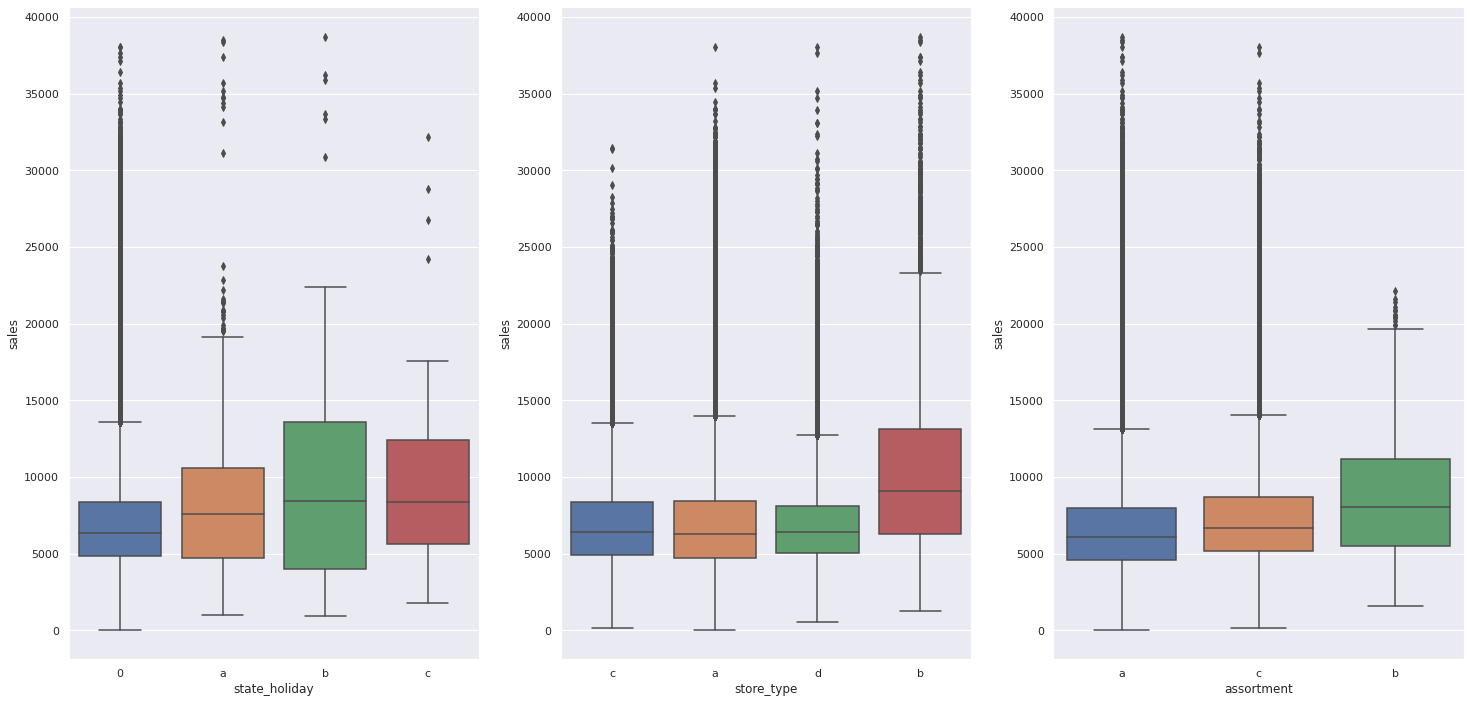

In [13]:
# plotting boxplots (categorical variables against target variable)
aux1 = df1_train[(df1_train['state_holiday'] != 0) & (df1_train['sales'] != 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);


# 2.0. STEP 02 - FEATURE ENGINEERING

In [24]:
# copy previous dataset
df2_train = df1_train.copy()
df2_valid = df1_valid.copy()

## 2.1. Hypothesis MindMap

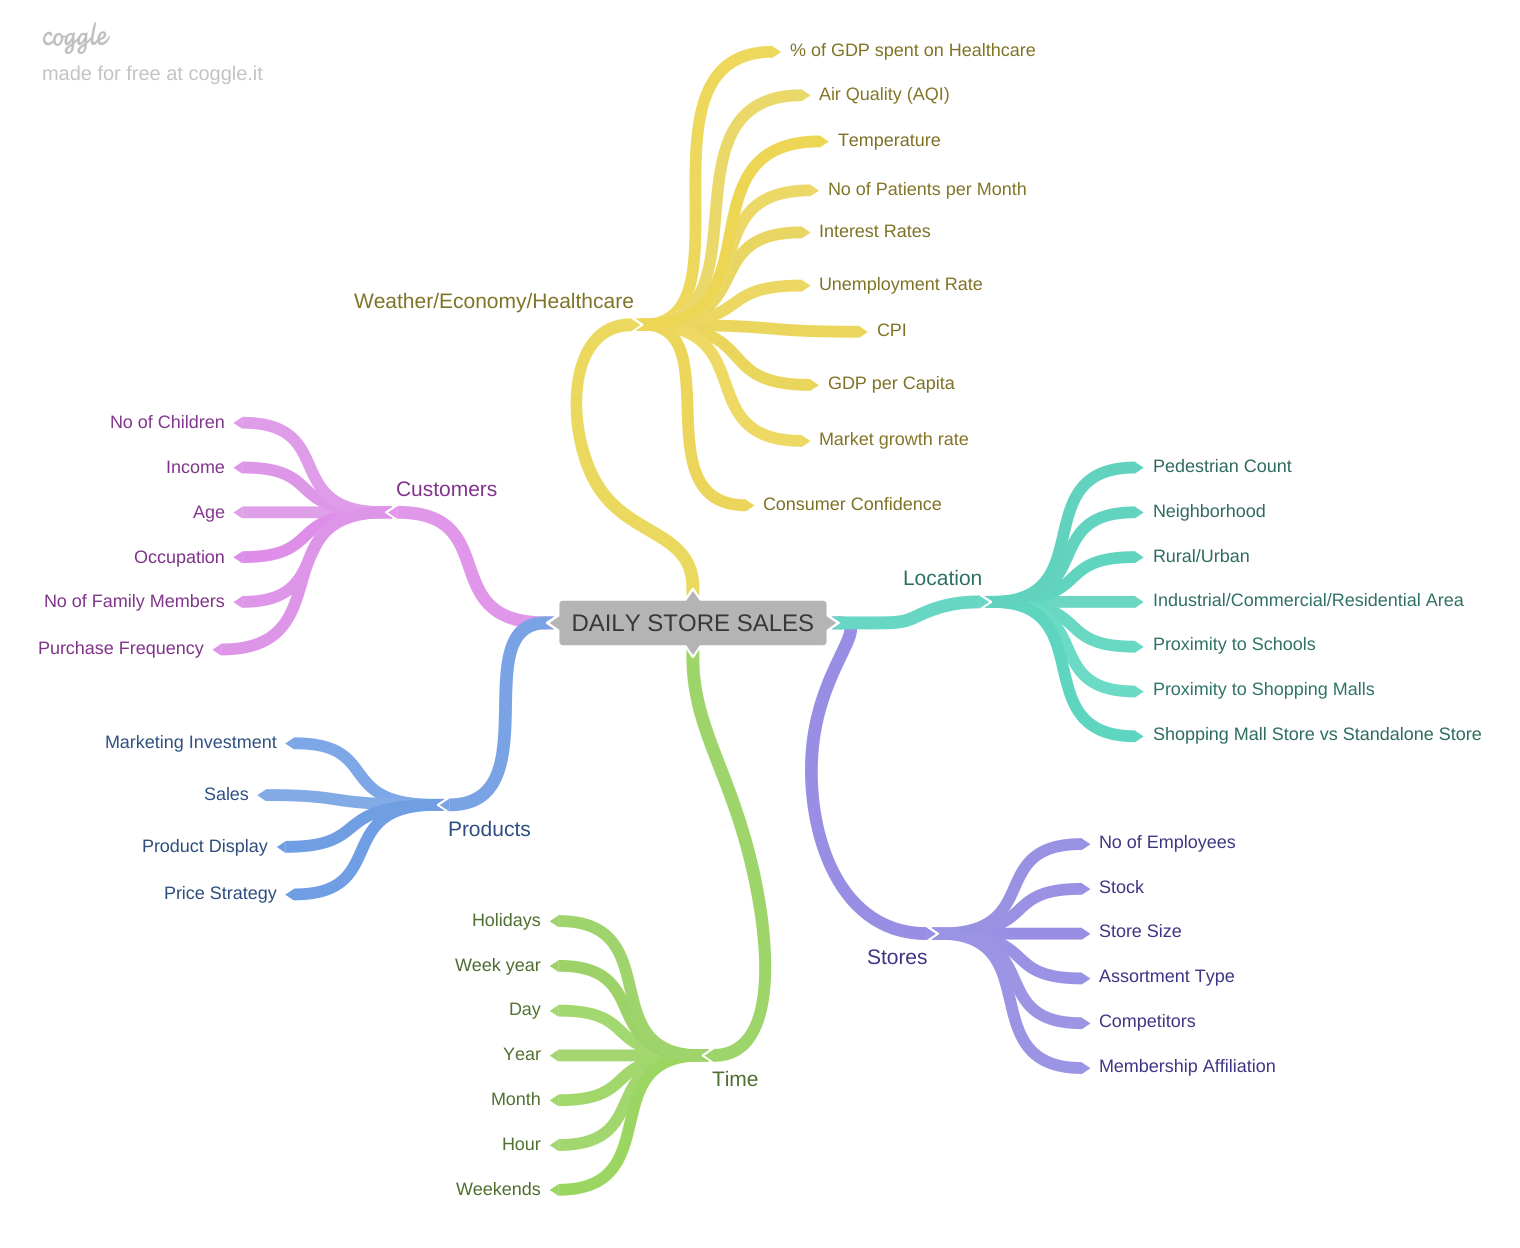

In [ ]:
Image('img/DAILY_STORE_SALES.png' )

## 2.2. Hypothesis Creation

### 2.2.1. Stores

**1.**  Stores with more employees sell more  
**2.**  Stores with bigger available stock sell more      
**3.**  Bigger stores sell more  
**4.**  Stores with extended assortment type sell more  
**5.** Stores near competitors sell less  
**6.** Stores with newly opened competitors sell less than stores with old competitors  


### 2.2.2. Time

**1.**  Stores sell more on weekdays than weekends/holidays  
**2.**  Stores sell more during the 2nd semester  
**3.**  Stores sell more during summer/winter breaks (schools)    
**4.**  Stores sell less during school holidays   
**5.**  Stores sell more on Christmas than other holidays      
**6.**  Stores sell more after day 10 of each month  
**7.**  Stores sell more along the years  


### 2.2.3. Products

**1.** Stores with higher marketing investments sell more  
**2.** Stores with products in promotion displayed at the entrance sell more  
**3.** Stores with cheaper products sell more  
**4.** Stores with aggresive price strategies sell more  
**5.** Stores frequently doing standalone promo sales sell more  
**6.** Stores doing consecutive promo sales in the beginning of the year sell more  
**7.** Stores participating in consecutive promo for a longer time sell more  
**8.** Stores with more consecutive promo sale days sell more  


### 2.2.4. Customers 


**1.** Stores with more customers who have children sell more  
**2.** Stores with more customers who have higher income sell more  
**3.** Stores with more elderly customers sell more  
**4.** Stores with more customers who have higher # of family members sell more  
**5.** Stores with more loyal customers sell more  


### 2.2.5. Location
note: Location of each store is not given. Hypothesis are displayed below just for the purpose of completeness.

**1.** Stores with higher pedestrian count (front street) sell more  
**2.** Stores located in an expensive neighborhood sell more  
**3.** Stores located in urban areas sell more  
**4.** Stores located in residential areas sell more  
**5.** Stores near schools sell more  
**6.** Stores near shopping malls sell more  
**7.** Stores located inside malls sell more than standalone stores  
   

### 2.2.6. External Factors (Economy, Healthcare, Weather)

  
*   **Economy:** usually macroeconomic data would not be relevant to the model  since its impact tend to affect all stores as a whole. 
However, some macroeconomic data could be relevant if divided by location or month/week.   
Since such kind of data is difficult to find, some hypotheses are displayed below just for the purpose of completeness. 

*   **Healthcare:** relevant data (per month) was either unavailable on public datasets or not possible to be utilized.  


*   **Weather:** although Rossmann stores are mainly located in Germany,  their location is not present on the dataset. Therefore, the usage of weather as a predictor for this model would be a big assumption to take.



**1.**  Stores within areas with low unemployment rate sell more  
**2.**  Stores within areas with high number of patients sell more  
**3.**  Stores within areas with high Gross Domestic Product Per Capita (GDPpc) sell more  
**4.**  Store sales increase when GDPpc increases (month)  
**5.**  Store sales increase when interest rates decrease (month)  
**6.**  Store sales increase when Consumer Price Index (CPI) rate increases (month)  
**7.**  Store sales increase when the number of patients hospitalized (per month) increase  
**8.**  Store sales increase when the air quality gets worse (AQI)  
**9.**  Store sales increase when the weather is above 28ºC or below 18ºC  
**10.**  Store sales increase when Consumer Confidence Index (CCI) rate increases (month)  
**11.**  Store sales increase when Unemployment rate decreases (month)  

## 2.3. Viable Hypothesis List


**1.** Stores with extended assortment type sell more  
**2.** Stores near competitors sell less  
**3.** Stores with newly opened competitors sell less than stores with old competitors  
**4.** Stores sell more on weekdays than weekends/holidays (sales rate)  
**5.** Stores sell more during the 2nd semester  
**6.** Stores sell more during summer/winter breaks (schools)  
**7.** Stores sell less during school holidays  
**8.** Stores sell more on Christmas than other holidays   
**9.** Stores are selling more along the years  
**10.** Stores sell more after day 10 of each month  
**11.** Stores frequently doing standalone promo sales sell more  
**12.** Stores doing consecutive promo sales in the beginning of the year sell more  
**13.** Stores participating in consecutive promo for a longer time sell more  
**14.** Stores with more consecutive promo sale days sell more  
**15.** Stores sales increase when GDPpc increases (month)  
**16.** Stores sales increase when interest rates decrease (month)  
**17.** Stores sales increase when Consumer Price Index (CPI) rate increases (month)  
**18.**  Stores sales increase when Consumer Confidence Index (CCI) rate increases (month)    
**19.**  Stores sales increase when Unemployment rate decreases (month)  

## 2.4. Feature Engineering

In [ ]:
# check dtypes
df2_train.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [ ]:
# date
df2_train['date'] = pd.to_datetime(df2_train['date'])
df2_valid['date'] = pd.to_datetime(df2_valid['date'])

# competition_since
df2_train['competition_since'] = df2_train.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

df2_valid['competition_since'] = df2_valid.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

# competition_since_month
df2_train['competition_since_month'] = ((df2_train['date'] - df2_train['competition_since']) / 30).apply(lambda x: x.days).astype(int)
df2_valid['competition_since_month'] = ((df2_valid['date'] - df2_valid['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo2_since
df2_train['promo2_since'] = df2_train['promo2_since_year'].astype(str) + '-' + df2_train['promo2_since_week'].astype(str)
df2_valid['promo2_since'] = df2_valid['promo2_since_year'].astype(str) + '-' + df2_valid['promo2_since_week'].astype(str)
df2_train['promo2_since'] = df2_train['promo2_since'].apply( lambda x: 
                                              datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2_valid['promo2_since'] = df2_valid['promo2_since'].apply( lambda x: 
                                              datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
# promo2_time_week
df2_train['promo2_time_week'] = ((df2_train['date'] - df2_train['promo2_since']) / 7).apply(lambda x: x.days).astype(int)
df2_valid['promo2_time_week'] = ((df2_valid['date'] - df2_valid['promo2_since']) / 7).apply(lambda x: x.days).astype(int)

# promo2_time_month
df2_train['promo2_time_month'] = ((df2_train['date'] - df2_train['promo2_since']) / 30).apply(lambda x: x.days).astype(int)
df2_valid['promo2_time_month'] = ((df2_valid['date'] - df2_valid['promo2_since']) / 30).apply(lambda x: x.days).astype(int)

# day, month, year
df2_train['day'] = df2_train['date'].dt.day
df2_valid['day'] = df2_valid['date'].dt.day
df2_train['month'] = df2_train['date'].dt.month
df2_valid['month'] = df2_valid['date'].dt.month
df2_train['year'] = df2_train['date'].dt.year
df2_valid['year'] = df2_valid['date'].dt.year

# week of year
df2_train['week_of_year'] = df2_train['date'].dt.weekofyear
df2_valid['week_of_year'] = df2_valid['date'].dt.weekofyear

# year week
df2_train['year_week'] = df2_train['date'].dt.strftime( '%Y-%W' )
df2_valid['year_week'] = df2_valid['date'].dt.strftime( '%Y-%W' )

# is_weekday
df2_train['is_weekday'] = df2_train.apply(lambda x: 1 if x['date'].weekday() in [0,1,2,3,4] 
                              else 1 if x['state_holiday'] == 0
                              else 0, axis = 1)
df2_valid['is_weekday'] = df2_valid.apply(lambda x: 1 if x['date'].weekday() in [0,1,2,3,4] 
                              else 1 if x['state_holiday'] == 0
                              else 0, axis = 1)


In [ ]:
# assortment
df2_train['assortment'] = df2_train['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')
df2_valid['assortment'] = df2_valid['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')
# state_holiday
df2_train['state_holiday'] = df2_train['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                  else 'easter' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')
df2_valid['state_holiday'] = df2_valid['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                  else 'easter' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')


In [ ]:
# GDPpc variable
# https://stats.oecd.org/index.aspx?queryid=66948#
# gdp = pd.read_csv('data/germany_gdp.csv', low_memory = False)
gdp = pd.read_csv('/home/alan/Sales-Prediction/data/germany_gdp.csv', low_memory = False)
gdp = gdp.loc[(gdp['Country'] == 'Germany') & (gdp['MEASURE'] == 'HCPCARSA'), :]
gdp.columns.to_list()


gdp['year_quarter'] = gdp['TIME'].apply(lambda x: x.strip())

gdp = gdp.drop(['LOCATION', 'TIME','Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency', 'Period', 
          'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags'], axis = 1)
df2_train['quarter'] = 0
df2_train.loc[df2_train['month'] == 1, 'quarter'] = 'Q1'
df2_train.loc[df2_train['month'] == 2,'quarter'] = 'Q1'
df2_train.loc[df2_train['month'] == 3,'quarter'] = 'Q1'
df2_train.loc[df2_train['month'] == 4,'quarter'] = 'Q2'
df2_train.loc[df2_train['month'] == 5,'quarter'] = 'Q2'
df2_train.loc[df2_train['month'] == 6,'quarter'] = 'Q2'
df2_train.loc[df2_train['month'] == 7,'quarter'] = 'Q3'
df2_train.loc[df2_train['month'] == 8,'quarter'] = 'Q3'
df2_train.loc[df2_train['month'] == 9,'quarter'] = 'Q3'
df2_train.loc[df2_train['month'] == 10,'quarter'] = 'Q4'
df2_train.loc[df2_train['month'] == 11,'quarter'] = 'Q4'
df2_train.loc[df2_train['month'] == 12, 'quarter'] = 'Q4'
df2_train['year_quarter'] = df2_train['year'].astype(str) + '-' + df2_train['quarter'].astype(str)

df2_train = pd.merge(df2_train, gdp, how = 'left', on = 'year_quarter')

df2_train['gdp'] = df2_train['Value']
df2_train = df2_train.drop(['quarter','Value'], axis = 1)

df2_valid['quarter'] = 0
df2_valid.loc[df2_valid['month'] == 1, 'quarter'] = 'Q1'
df2_valid.loc[df2_valid['month'] == 2,'quarter'] = 'Q1'
df2_valid.loc[df2_valid['month'] == 3,'quarter'] = 'Q1'
df2_valid.loc[df2_valid['month'] == 4,'quarter'] = 'Q2'
df2_valid.loc[df2_valid['month'] == 5,'quarter'] = 'Q2'
df2_valid.loc[df2_valid['month'] == 6,'quarter'] = 'Q2'
df2_valid.loc[df2_valid['month'] == 7,'quarter'] = 'Q3'
df2_valid.loc[df2_valid['month'] == 8,'quarter'] = 'Q3'
df2_valid.loc[df2_valid['month'] == 9,'quarter'] = 'Q3'
df2_valid.loc[df2_valid['month'] == 10,'quarter'] = 'Q4'
df2_valid.loc[df2_valid['month'] == 11,'quarter'] = 'Q4'
df2_valid.loc[df2_valid['month'] == 12, 'quarter'] = 'Q4'
df2_valid['year_quarter'] = df2_valid['year'].astype(str) + '-' + df2_valid['quarter'].astype(str)

df2_valid = pd.merge(df2_valid, gdp, how = 'left', on = 'year_quarter')

df2_valid['gdp'] = df2_valid['Value']
df2_valid = df2_valid.drop(['quarter','Value'], axis = 1)

In [ ]:
# CPI index (Ref 2015 = 100)
# cpi = pd.read_csv('data/cpi_germany.csv', low_memory = False)
# https://stats.oecd.org/Index.aspx?DataSetCode=PRICES_CPI
cpi = pd.read_csv('/home/alan/Sales-Prediction/data/cpi_germany.csv', low_memory = False)
# cpi = cpi.loc[(cpi['Country'] == 'Germany') & (cpi['Measure'] == 'Index') & (cpi['Subject'] == 'CPI: 01-12 - All items'), :]
# cpi[['year','month']] = cpi['TIME'].str.split('-',expand = True)
# cpi['year'] = cpi['year'].astype(float).astype(int)
# cpi = cpi[cpi['year'] < 2016]

# cpi.loc[cpi['month'] == '01', 'month'] = '1'
# cpi.loc[cpi['month'] == '02','month'] = '2'
# cpi.loc[cpi['month'] == '03','month'] = '3'
# cpi.loc[cpi['month'] == '04','month'] = '4'
# cpi.loc[cpi['month'] == '05','month'] = '5'
# cpi.loc[cpi['month'] == '06','month'] = '6'
# cpi.loc[cpi['month'] == '07','month'] = '7'
# cpi.loc[cpi['month'] == '08','month'] = '8'
# cpi.loc[cpi['month'] == '09','month'] = '9'
# cpi.loc[cpi['month'] == '10','month'] = '10'
# cpi.loc[cpi['month'] == '11','month'] = '11'
# cpi.loc[cpi['month'] == '12', 'month'] = '12'

# cpi['year_month'] = cpi['year'].astype(str) + '-' + cpi['month'].astype(str)
# cpi['cpi'] = cpi['Value']
# cpi = cpi.drop(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency',
#  'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags', 'TIME','Time','year','month','Value'], axis = 1)
df2_train['year_month'] = df2_train['year'].astype(str) + '-' + df2_train['month'].astype(str)
df2_train = pd.merge(df2_train, cpi, how = 'left', on = 'year_month')
df2_valid['year_month'] = df2_valid['year'].astype(str) + '-' + df2_valid['month'].astype(str)
df2_valid = pd.merge(df2_valid, cpi, how = 'left', on = 'year_month')

In [ ]:
# interest_rates (Long-term interest rates, Per cent per annum)
# interest_rate = pd.read_csv('data/interest_germany.csv', low_memory = False)
interest_rate = pd.read_csv('/home/alan/Sales-Prediction/data/interest_germany.csv', low_memory = False)
# https://stats.oecd.org/index.aspx?queryid=86
interest_rate = interest_rate.loc[(interest_rate['Country'] == 'Germany') & (interest_rate['SUBJECT'] == 'IRLT') & (interest_rate['Unit'] == 'Percentage'), :]
interest_rate[['year','month']] = interest_rate['TIME'].str.split('-',expand = True)
interest_rate['year'] = interest_rate['year'].astype(float).astype(int)
interest_rate = interest_rate[interest_rate['year'] < 2016]

interest_rate.loc[interest_rate['month'] == '01', 'month'] = '1'
interest_rate.loc[interest_rate['month'] == '02','month'] = '2'
interest_rate.loc[interest_rate['month'] == '03','month'] = '3'
interest_rate.loc[interest_rate['month'] == '04','month'] = '4'
interest_rate.loc[interest_rate['month'] == '05','month'] = '5'
interest_rate.loc[interest_rate['month'] == '06','month'] = '6'
interest_rate.loc[interest_rate['month'] == '07','month'] = '7'
interest_rate.loc[interest_rate['month'] == '08','month'] = '8'
interest_rate.loc[interest_rate['month'] == '09','month'] = '9'
interest_rate.loc[interest_rate['month'] == '10','month'] = '10'
interest_rate.loc[interest_rate['month'] == '11','month'] = '11'
interest_rate.loc[interest_rate['month'] == '12', 'month'] = '12'
interest_rate['year_month'] = interest_rate['year'].astype(str) + '-' + interest_rate['month'].astype(str)
interest_rate['interest_rate'] = interest_rate['Value']
interest_rate = interest_rate.drop(['SUBJECT', 'Subject', 'LOCATION', 'Country', 'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period',
 'Value', 'Flag Codes', 'Flags', 'year', 'month'], axis = 1)
df2_train = pd.merge(df2_train, interest_rate, how = 'left', on = 'year_month')
df2_valid = pd.merge(df2_valid, interest_rate, how = 'left', on = 'year_month')

In [ ]:
# unemployment_rate = pd.read_csv('data/unemployment_germany.csv', low_memory = False) # https://data.oecd.org/unemp/unemployment-rate.htm # Total, % of labour force unemployed
unemployment_rate = pd.read_csv('/home/alan/Sales-Prediction/data/unemployment_germany.csv', low_memory = False) # https://data.oecd.org/unemp/unemployment-rate.htm # Total, % of labour force unemployed
unemployment_rate = unemployment_rate.loc[(unemployment_rate['LOCATION'] == 'DEU'), :]
unemployment_rate[['year','month']] = unemployment_rate['TIME'].str.split('-',expand = True)
unemployment_rate['year'] = unemployment_rate['year'].astype(int) 
unemployment_rate = unemployment_rate[unemployment_rate['year'] < 2016]
unemployment_rate.loc[unemployment_rate['month'] == '01', 'month'] = '1'
unemployment_rate.loc[unemployment_rate['month'] == '02','month'] = '2'
unemployment_rate.loc[unemployment_rate['month'] == '03','month'] = '3'
unemployment_rate.loc[unemployment_rate['month'] == '04','month'] = '4'
unemployment_rate.loc[unemployment_rate['month'] == '05','month'] = '5'
unemployment_rate.loc[unemployment_rate['month'] == '06','month'] = '6'
unemployment_rate.loc[unemployment_rate['month'] == '07','month'] = '7'
unemployment_rate.loc[unemployment_rate['month'] == '08','month'] = '8'
unemployment_rate.loc[unemployment_rate['month'] == '09','month'] = '9'
unemployment_rate.loc[unemployment_rate['month'] == '10','month'] = '10'
unemployment_rate.loc[unemployment_rate['month'] == '11','month'] = '11'
unemployment_rate.loc[unemployment_rate['month'] == '12', 'month'] = '12'
unemployment_rate['year_month'] = unemployment_rate['year'].astype(str) + '-' + unemployment_rate['month'].astype(str)
unemployment_rate['unemployment_rate'] = unemployment_rate['Value']

unemployment_rate = unemployment_rate.drop(['LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'TIME', 'Value', 'Flag Codes', 'year', 'month'], axis = 1)
df2_train = pd.merge(df2_train, unemployment_rate, how = 'left', on = 'year_month')
df2_valid = pd.merge(df2_valid, unemployment_rate, how = 'left', on = 'year_month')

In [ ]:
cci = pd.read_csv('/home/alan/Sales-Prediction/data/CCI_germany.csv', low_memory = False) # https://data.oecd.org/leadind/consumer-confidence-index-cci.htm
# cci = pd.read_csv('data/CCI_germany.csv', low_memory = False)
# Values below 100 indicate a pessimistic attitude towards future developments in the economy, possibly resulting in a tendency to save more and consume less. 
cci = cci.loc[(cci['LOCATION'] == 'DEU'), :]
cci[['year','month']] = cci['TIME'].str.split('-',expand = True)
cci['year'] = cci['year'].astype(int)
cci = cci[cci['year'] < 2016]
cci.loc[cci['month'] == '01', 'month'] = '1'
cci.loc[cci['month'] == '02','month'] = '2'
cci.loc[cci['month'] == '03','month'] = '3'
cci.loc[cci['month'] == '04','month'] = '4'
cci.loc[cci['month'] == '05','month'] = '5'
cci.loc[cci['month'] == '06','month'] = '6'
cci.loc[cci['month'] == '07','month'] = '7'
cci.loc[cci['month'] == '08','month'] = '8'
cci.loc[cci['month'] == '09','month'] = '9'
cci.loc[cci['month'] == '10','month'] = '10'
cci.loc[cci['month'] == '11','month'] = '11'
cci.loc[cci['month'] == '12', 'month'] = '12'
cci['year_month'] = cci['year'].astype(str) + '-' + cci['month'].astype(str)
cci['cci'] = cci['Value']

cci = cci.drop(['LOCATION', 'INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'TIME', 'Value', 'Flag Codes', 'year', 'month'], axis = 1)
df2_train = pd.merge(df2_train, cci, how = 'left', on = 'year_month')
df2_valid = pd.merge(df2_valid, cci, how = 'left', on = 'year_month')

# 3.0. STEP 03 - FILTERING VARIABLES (according to business restritions)

In [ ]:
# copy previous dataset
df3_train = df2_train.copy()
df3_valid = df2_valid.copy()

## 3.1. Filtering Rows

In [ ]:
# We will exclude closed stores with zero sales
df3_train = df3_train[(df3_train['open'] != 0) & (df3_train['sales'] > 0)]
df3_valid = df3_valid[(df3_valid['open'] != 0) & (df3_valid['sales'] > 0)]

## 3.2. Column Selection

In [ ]:
# dropping irrelevant columns
cols_drop = ['promo_interval', 'open', 'month_map']
df3_train = df3_train.drop(cols_drop, axis = 1)
df3_valid = df3_valid.drop(cols_drop, axis = 1)

In [ ]:
# check columns
df3_train.columns

In [ ]:
# reordering columns
df3_train = df3_train[['store', 'date', 'day', 'month', 'year','year_month','week_of_year','year_week','sales','customers','day_of_week','is_weekday','state_holiday','school_holiday',
     'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
     'competition_since', 'competition_since_month', 'promo', 'is_promo2','promo2', 'promo2_since', 'promo2_since_week', 
     'promo2_since_year', 'promo2_time_week', 'promo2_time_month','gdp','cpi','interest_rate','unemployment_rate','cci']]

df3_valid = df3_valid[['store', 'date', 'day', 'month', 'year','year_month','week_of_year','year_week','sales','customers','day_of_week','is_weekday','state_holiday','school_holiday',
'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
'competition_since', 'competition_since_month', 'promo', 'is_promo2','promo2', 'promo2_since', 'promo2_since_week', 
'promo2_since_year', 'promo2_time_week', 'promo2_time_month','gdp','cpi','interest_rate','unemployment_rate','cci']]

In [ ]:
# check data dimension
print(df3_train.shape) # (802942, 33)
print(df3_valid.shape) # (41396, 33)


# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [ ]:
# copy previous dataset
df4_train = df3_train.copy()
df4_valid = df3_valid.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

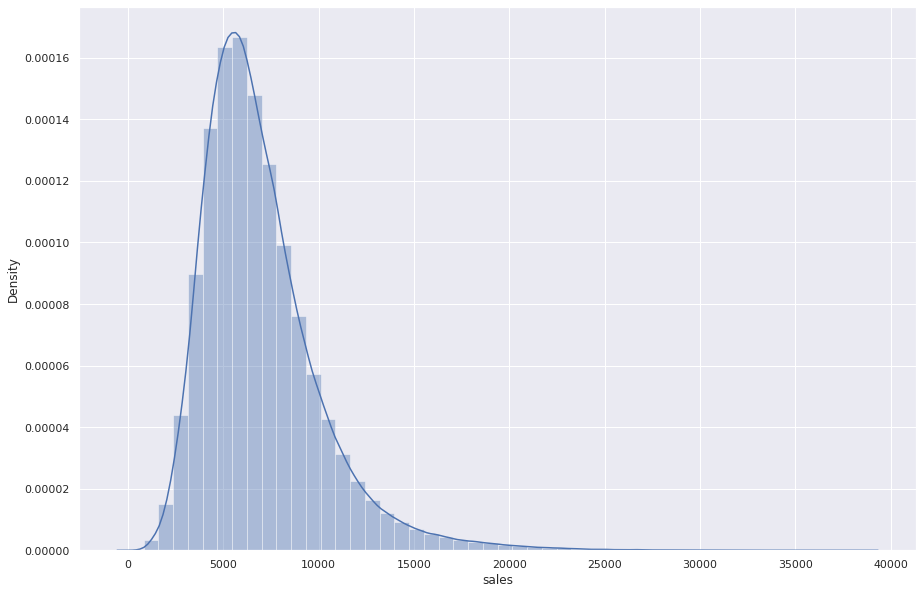

In [53]:
# we will need to pre-process target variable
plt.figure(figsize = (15, 10))
sns.distplot(df4_train['sales'], kde = True);

### 4.1.2. Numerical Variables

In [49]:
# select numerical variables
num_feat = df4_train.select_dtypes( include = ['int64', 'float64'])

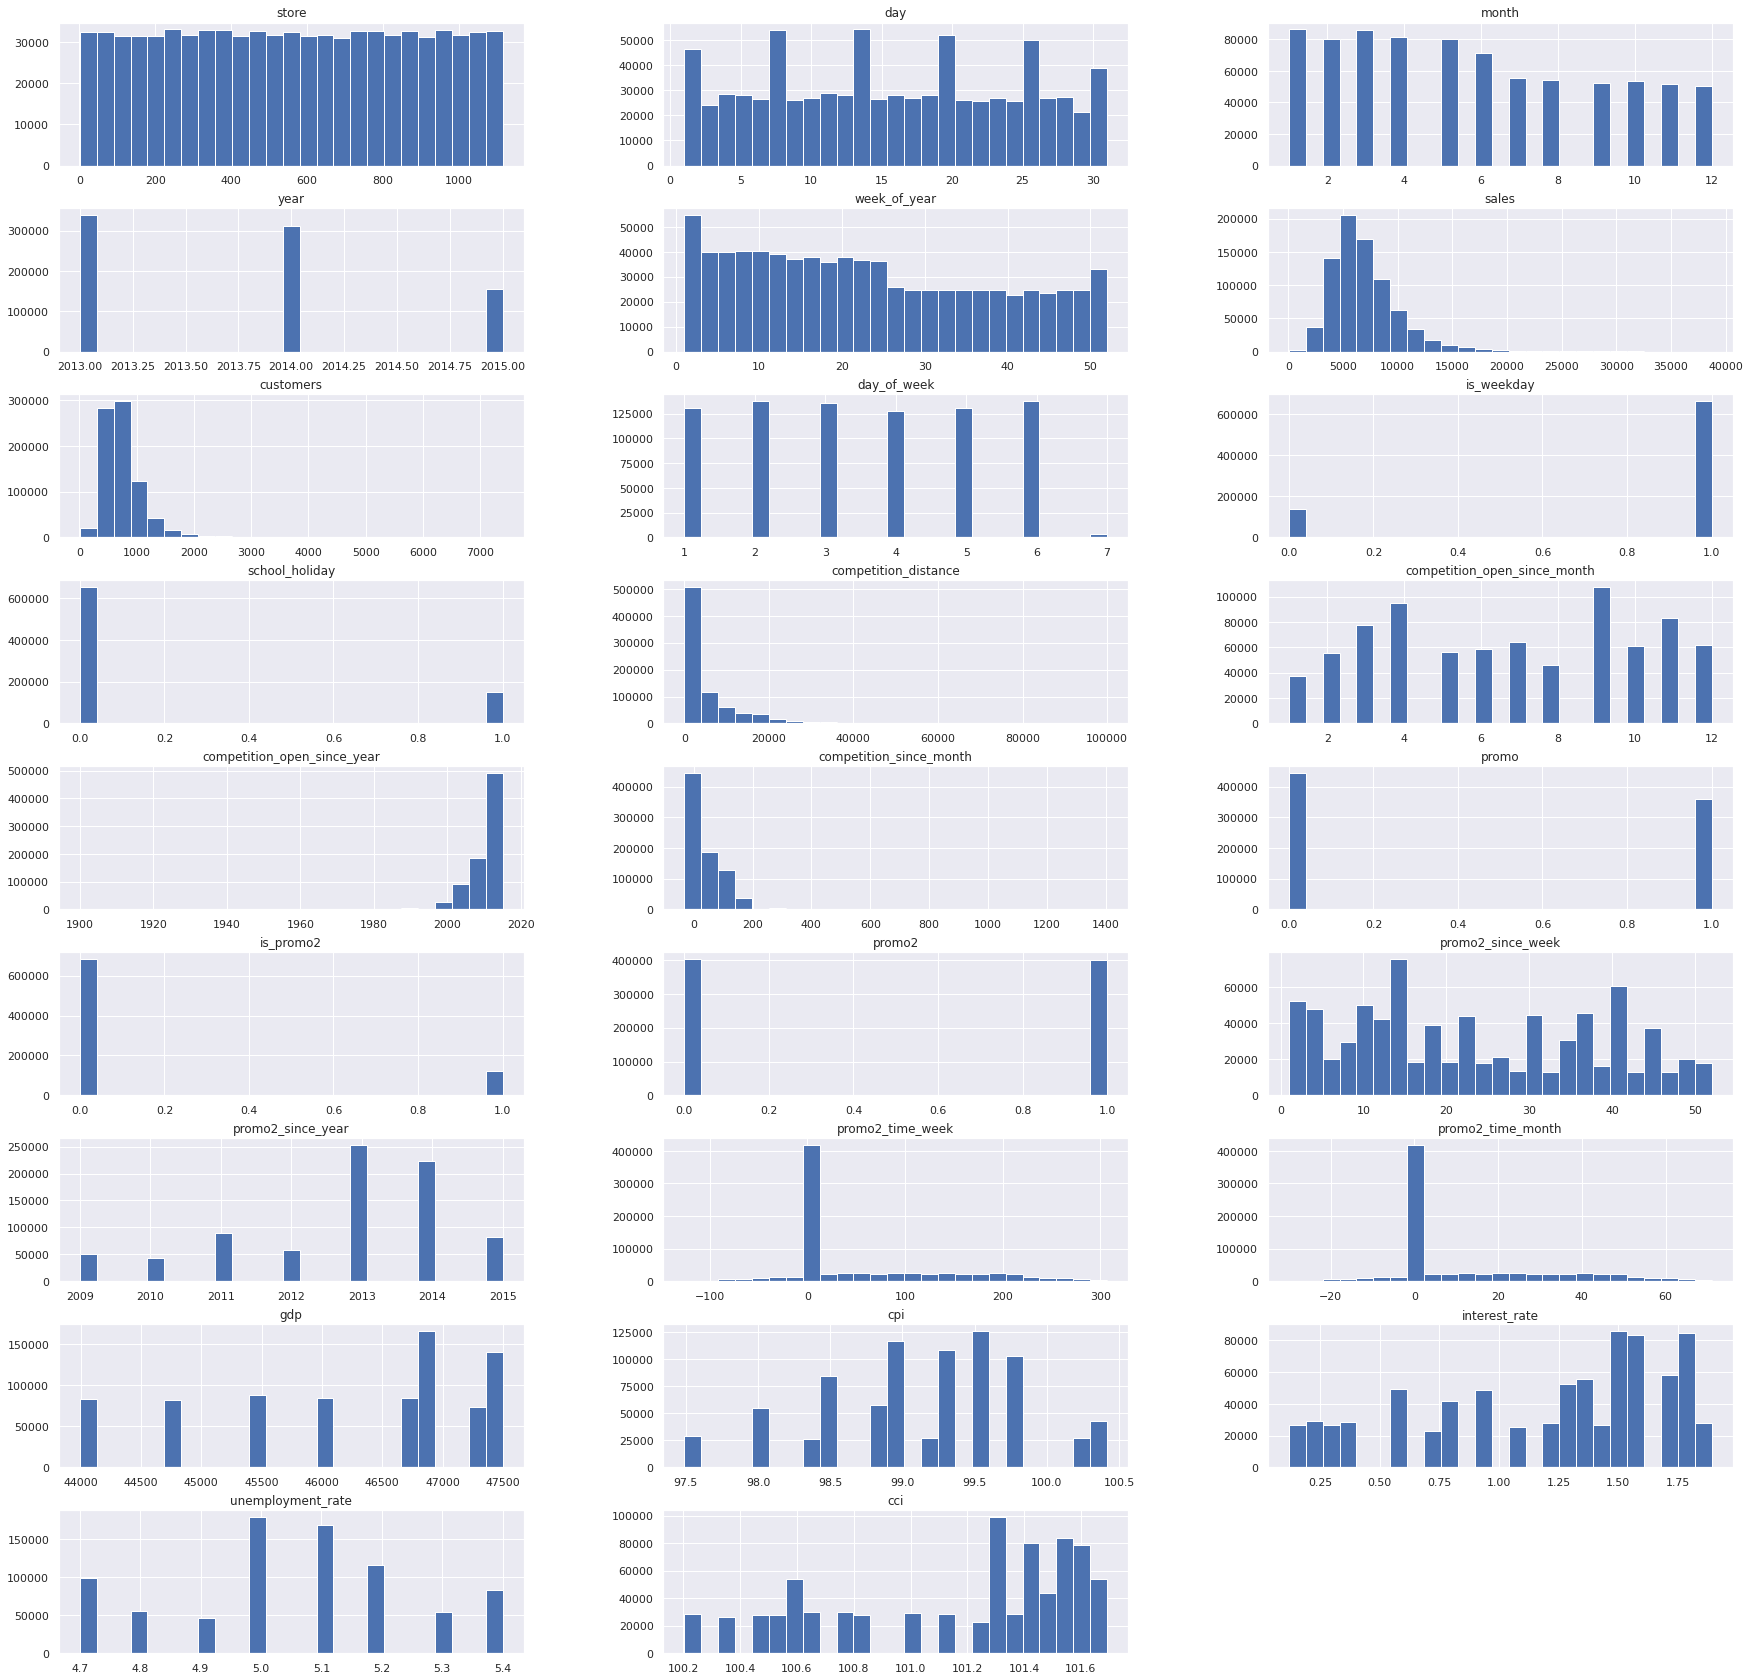

In [81]:
num_feat.hist(bins = 25, figsize = (30,30), layout = (9,3));

 **Overall: All variables don't follow a normal distribution**  
 **day**: There are specific days which has almost double sales data points than others (day)  
 **month**: More sales data points on the first semester  
 **year**: Less data points in 2015 (compared to other years)  
 **customers**: Resemble a poisson distribution.  
 **week_of_year**: A boom of sales data points during the first weeks of the year  
 **day_of_week**: less sales data points on sundays    
 **is_weekday**: more sales data points on weekdays  
 **school_holiday**: more sales data points on regular days  
 **competition_distance**: more sales data points for stores with closer competitors  
 **competition_open_since_month**: more sales data points for competitors which entered competition on April, July, September  
 **competition_since_month**: no relevant info retrieved  
 **is_promo2**: more sales data points for 0  
 **competition_open_since_year, promo2, promo, promo_since, promo_time, gdp, cpi, interest_rates, unemployment_rate, cci**: no relevant info retrieved  


### 4.1.3. Categorical Variables

In [75]:
# select categorical variables
cat_feat = df4_train.select_dtypes(exclude = ['float64','int64'])
cat_feat.columns

Index(['date', 'year_month', 'year_week', 'state_holiday', 'store_type',
       'assortment', 'competition_since', 'promo2_since'],
      dtype='object')

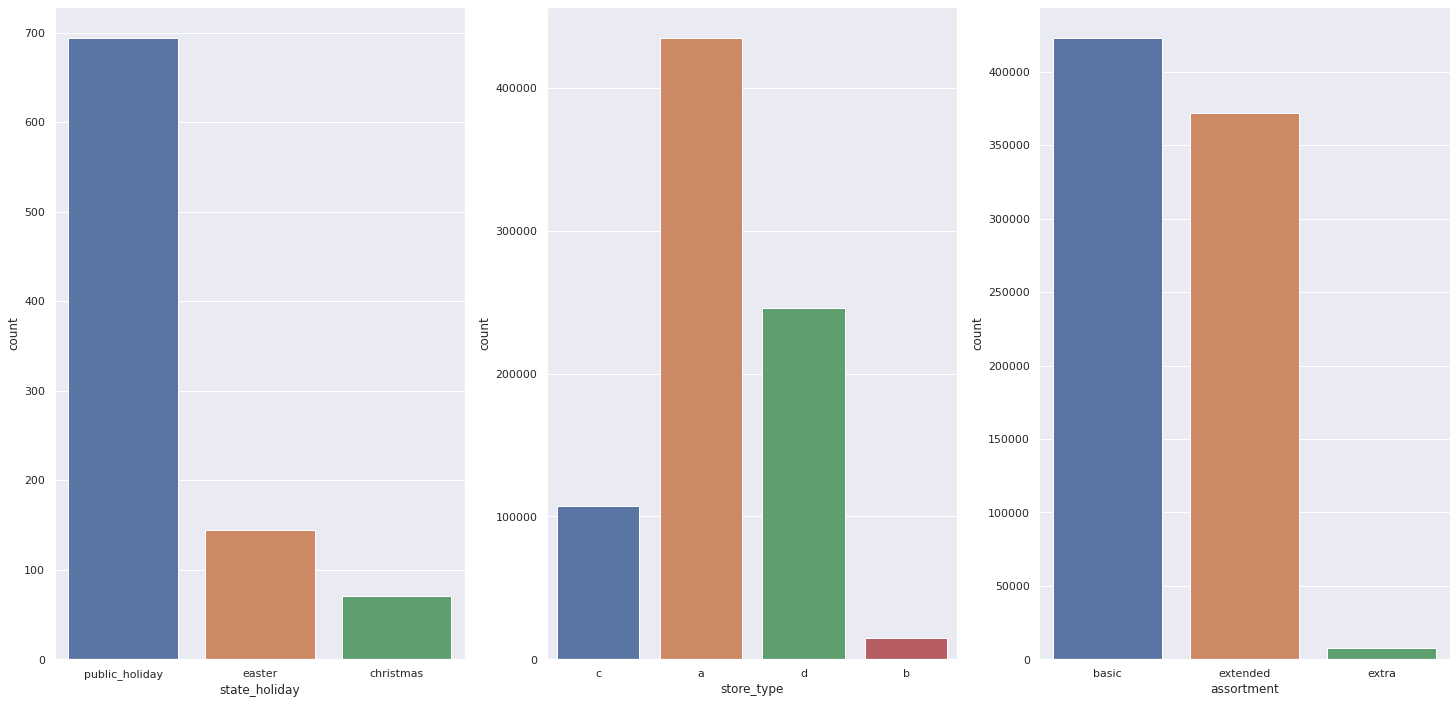

In [ ]:
# state_holiday
plt.subplot(1,3,1)
a = df4_train[df4_train['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

# store_type
plt.subplot(1,3,2)
sns.countplot(df4_train['store_type']);

# assortment
plt.subplot(1,3,3)
sns.countplot(df4_train['assortment']);


 **state_holiday**: more sales data points on public_holidays than other holidays. Easter and Christmas are similar  
 **store_type**: More sales data points for store_type a. Less stores b  
 **assortment**: Less sales data points for assortment of type 'extra'  


## 4.2. Bivariate Analysis

### **H1.**  Stores with extended assortment type sell more  
**FALSE**: Stores with bigger assortment sell less. However, the number of data points for stores with assortment 'extra' is very low compared to the other two (refer to univariate analysis on 4.1.3. ). Since assortment 'extra' follows a similar sales pattern of the other two, assortment might not be meaningful on our model.

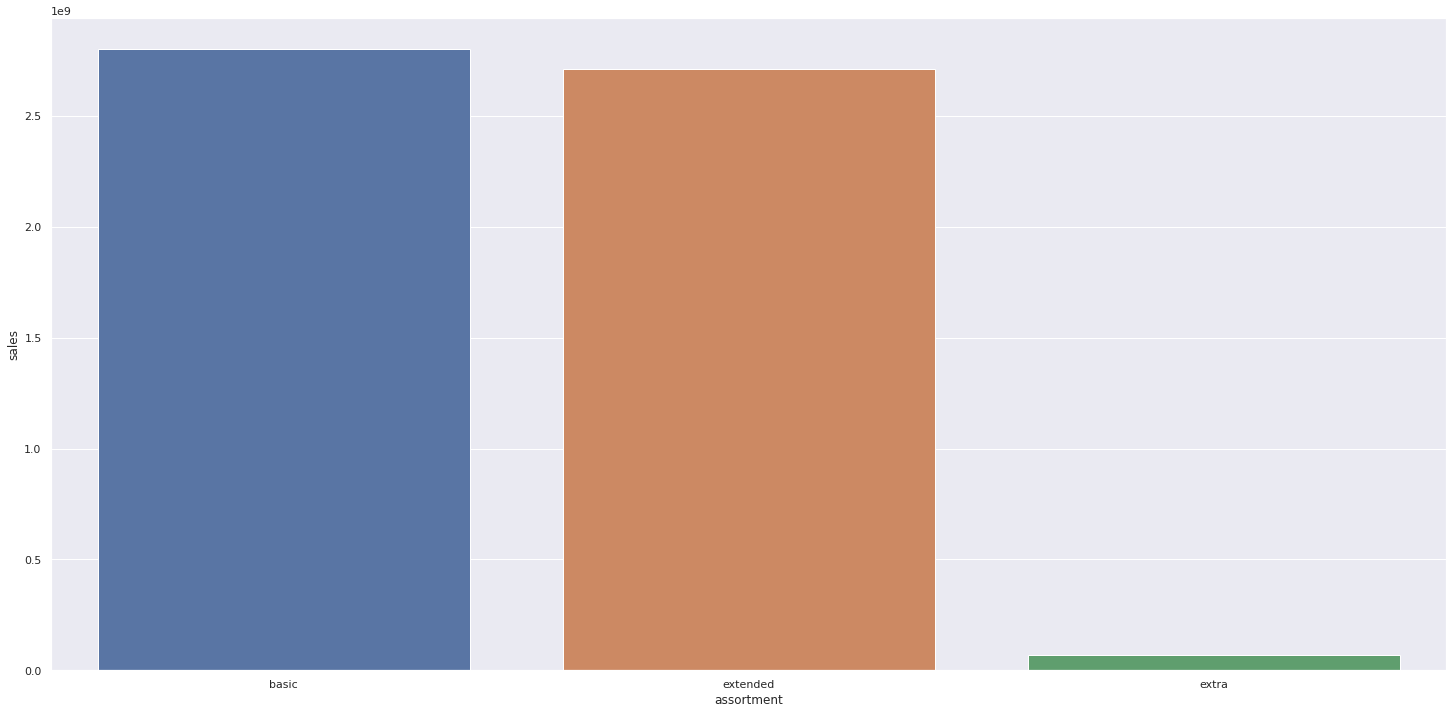

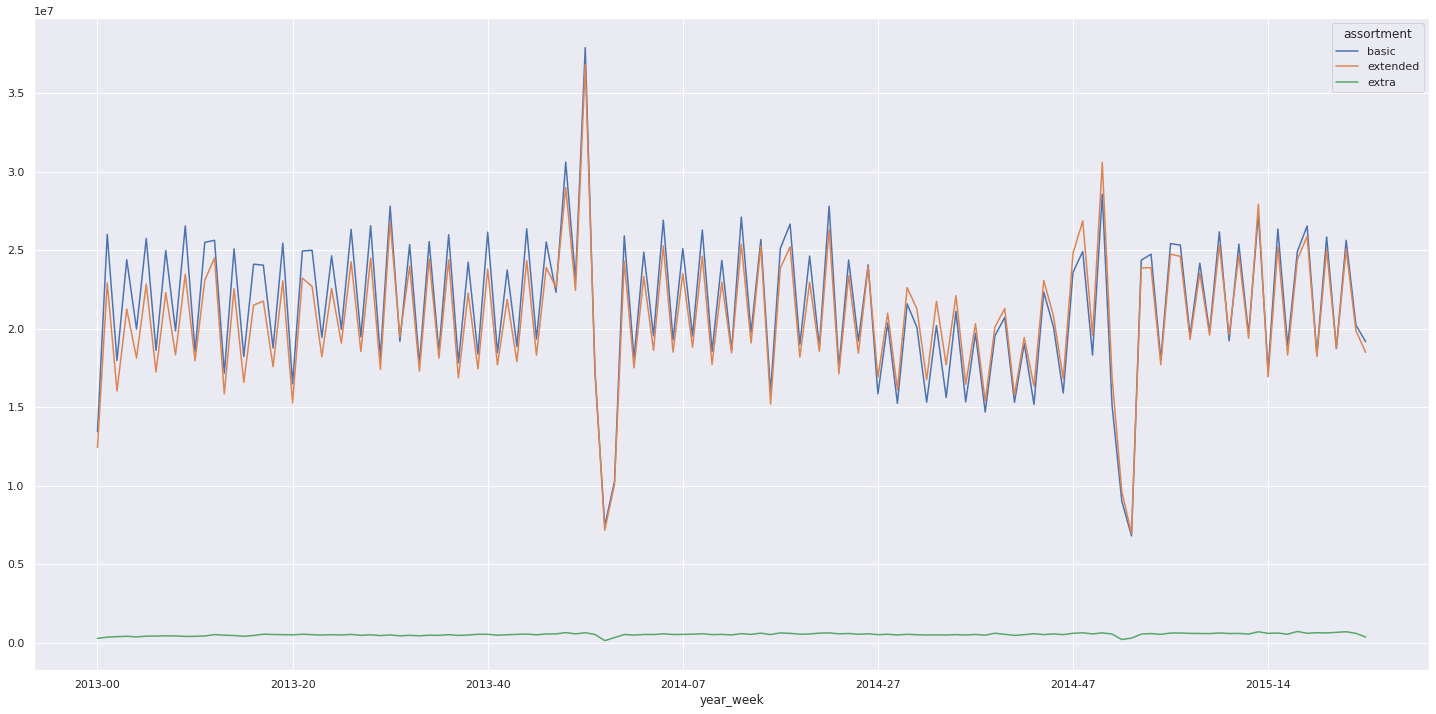

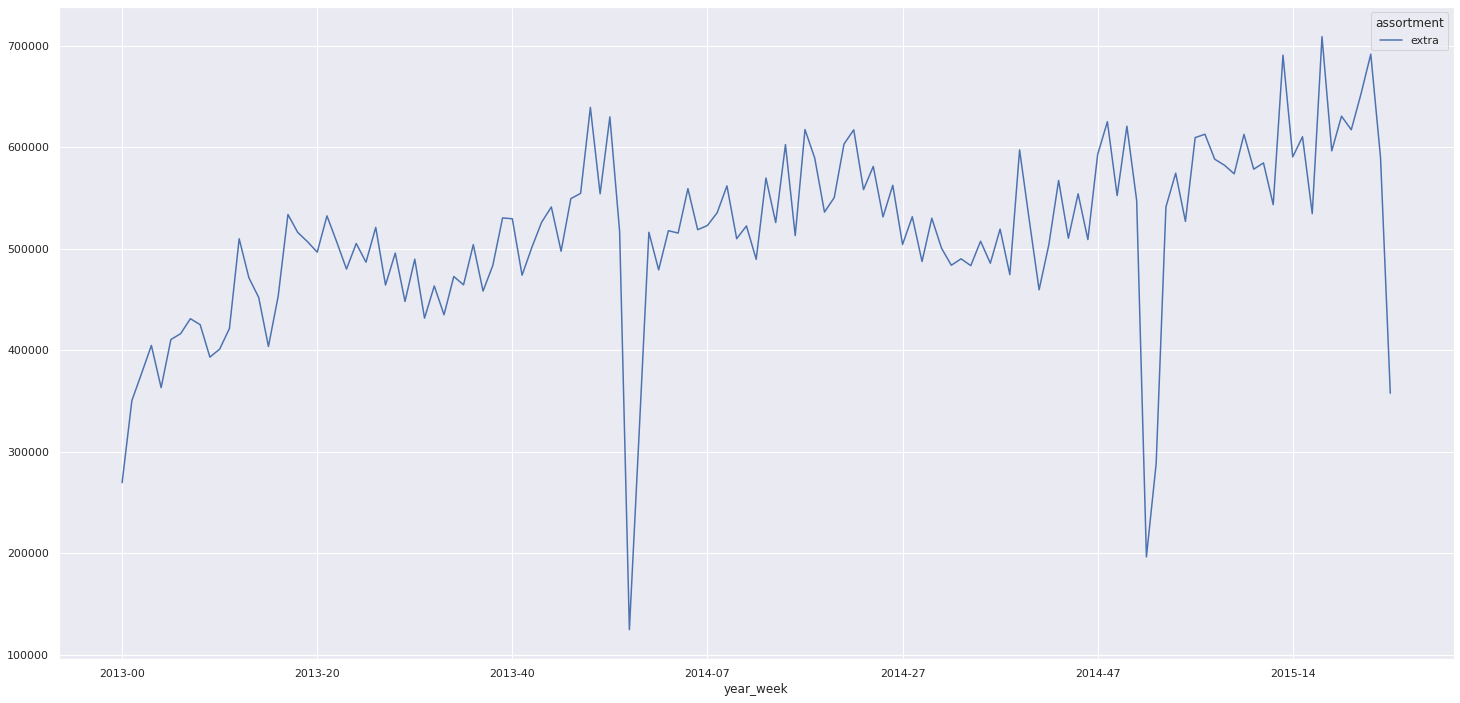

In [ ]:
aux1 = df4_train[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4_train[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **H2.**  Stores near competitors sell less  

**FALSE**: Stores near competitors sell more.

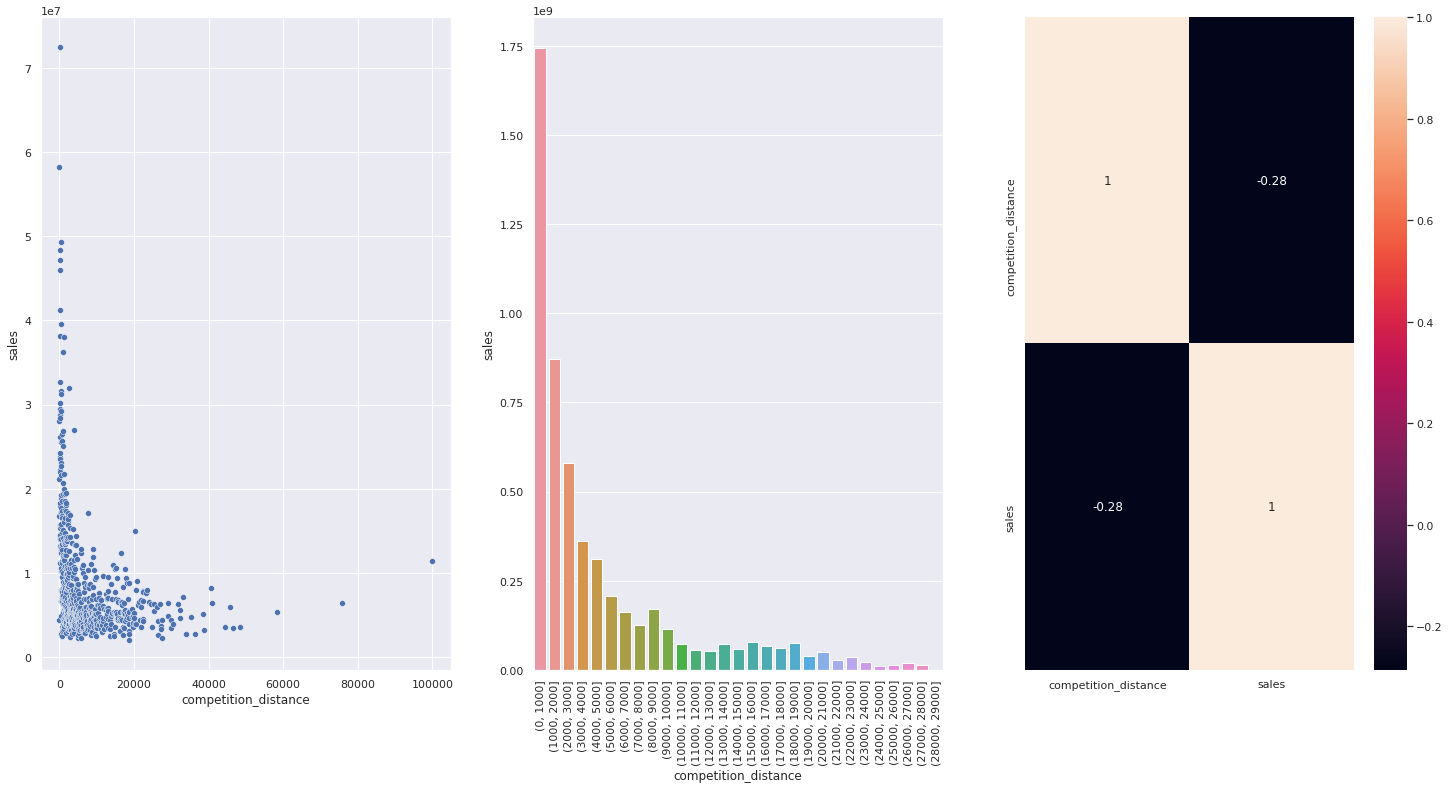

In [83]:
aux1 = df4_train[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,30000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xlabel("competition_distance")
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);
plt.show()

### **H3.**  Stores with newly opened competitors sell less than stores with old competitors  
**FALSE**: Stores with newly opened competitors sell more.

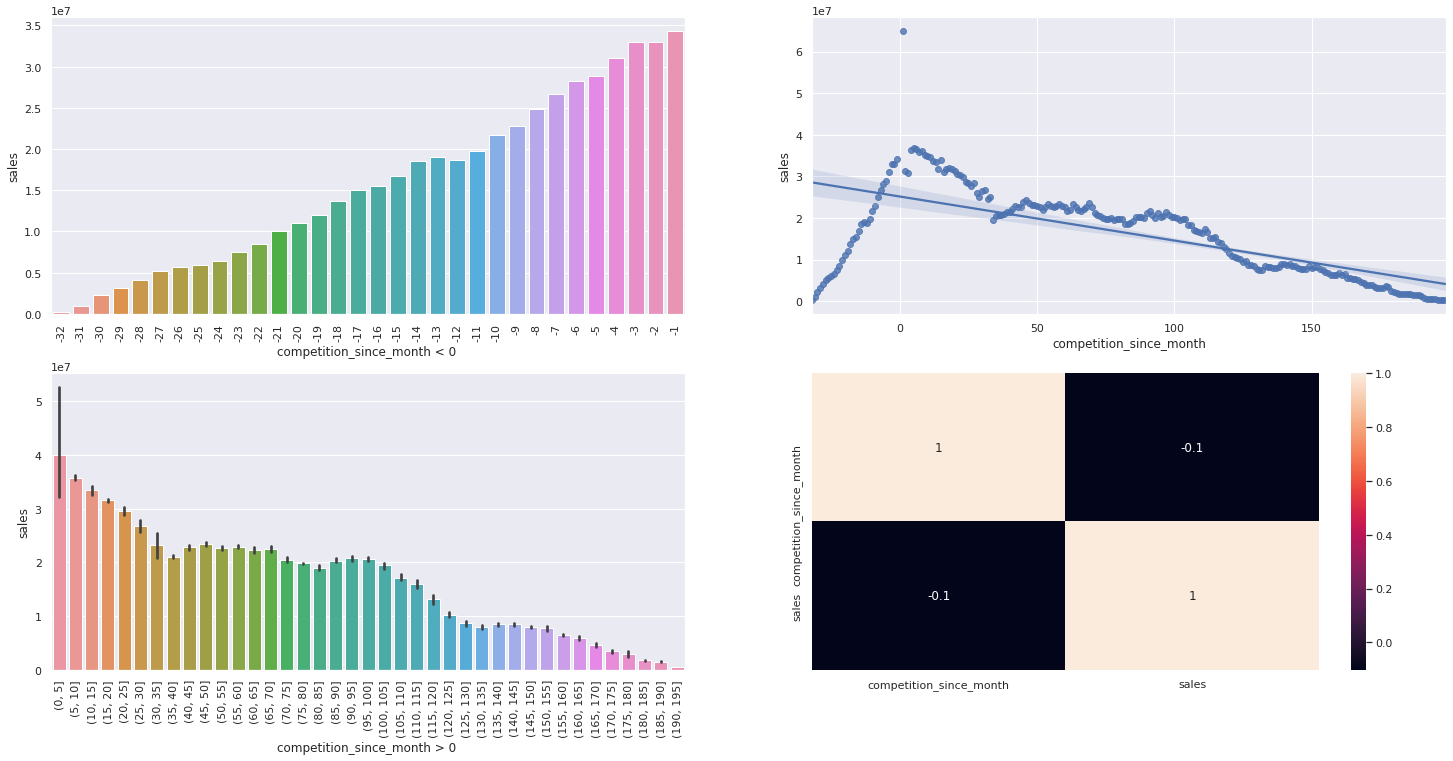

In [74]:
grid = GridSpec( 2, 2 )
aux1 = df4_train[['competition_since_month', 'sales']].groupby('competition_since_month').sum().reset_index()


plt.subplot(grid[0,0])
aux3 = aux1[(aux1['competition_since_month'] != 0) & (aux1['competition_since_month'] < 0)]
sns.barplot(x = 'competition_since_month', y = 'sales', data = aux3);
plt.xticks(rotation = 90);
plt.xlabel("competition_since_month < 0 ")

plt.subplot(grid[0,1])
aux4 = aux1[(aux1['competition_since_month'] != 0) & (aux1['competition_since_month'] < 200)]
sns.regplot(x = 'competition_since_month', y = 'sales', data = aux4);

plt.subplot(grid[1,0])
bins = list(np.arange(0,200, 5))
aux2 = aux1[(aux1['competition_since_month'] != 0) & (aux1['competition_since_month'] > 0) & (aux1['competition_since_month'] < 200)]
aux2['competition_since_month_binned'] = pd.cut(aux2['competition_since_month'], bins = bins)
sns.barplot(x = 'competition_since_month_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.xlabel("competition_since_month > 0 ")

plt.subplot(grid[1,1])
sns.heatmap(aux1.corr(), annot = True);

### **H4.**  Stores sell more on weekdays than weekends/holidays (sales rate)
**TRUE**: Stores sell more on weekdays. Sales volume is also bigger on weekdays. Worst sales day is Sunday.

,Metrics,Results
0,Total Sales,"$5,583,608,873.00"
1,Total Sales Weekends,"$836,510,151.00"
2,Avg Sales Weekends,"$5,942.39"
3,Total Sales Weekdays,"$4,747,098,722.00"
4,Avg Sales Weekdays,"$7,168.98"


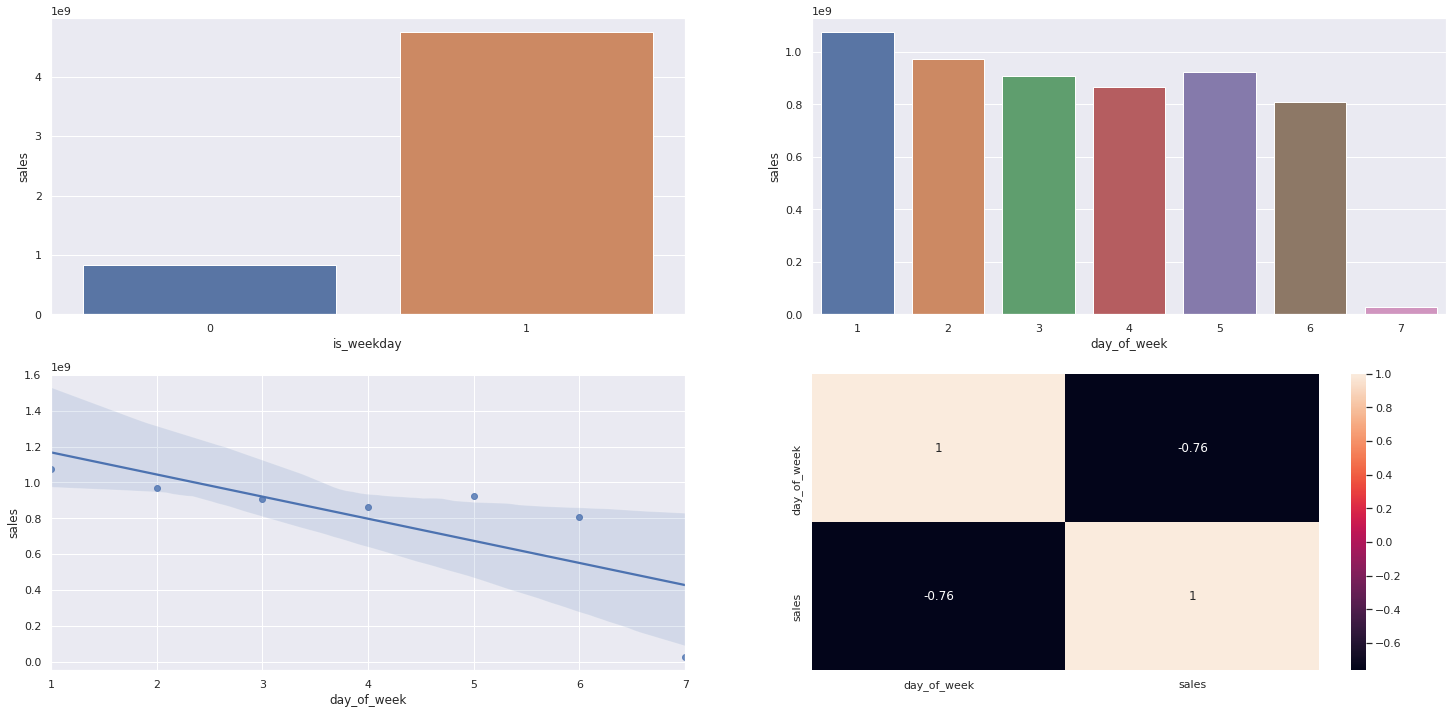

In [35]:
aux1 = df4_train[['is_weekday','sales']].groupby('is_weekday').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'is_weekday', y = 'sales', data = aux1);

plt.subplot(222)
aux8 = df4_train[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(223)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(224)
sns.heatmap(aux8.corr(), annot=True)

aux6 = df4_train['sales'].sum()
aux2 = df4_train[df4_train['is_weekday'] == 0]['sales'].sum()
aux3 = df4_train[df4_train['is_weekday'] == 1]['sales'].sum()
aux4 = df4_train[df4_train['is_weekday'] == 0]['sales'].mean()
aux5 = df4_train[df4_train['is_weekday'] == 1]['sales'].mean()

data = {'Metrics':['Total Sales', 'Total Sales Weekends','Avg Sales Weekends', 'Total Sales Weekdays',
                   'Avg Sales Weekdays'],'Results': [aux6, aux2, aux4, aux3, aux5]}

aux7 = pd.DataFrame(data)
aux7['Results'] = aux7['Results'].map('${:,.2f}'.format)
aux7

### **H5.**  Stores sell more during the 2nd semester
**FALSE**: Stores sell more on the 1st semester

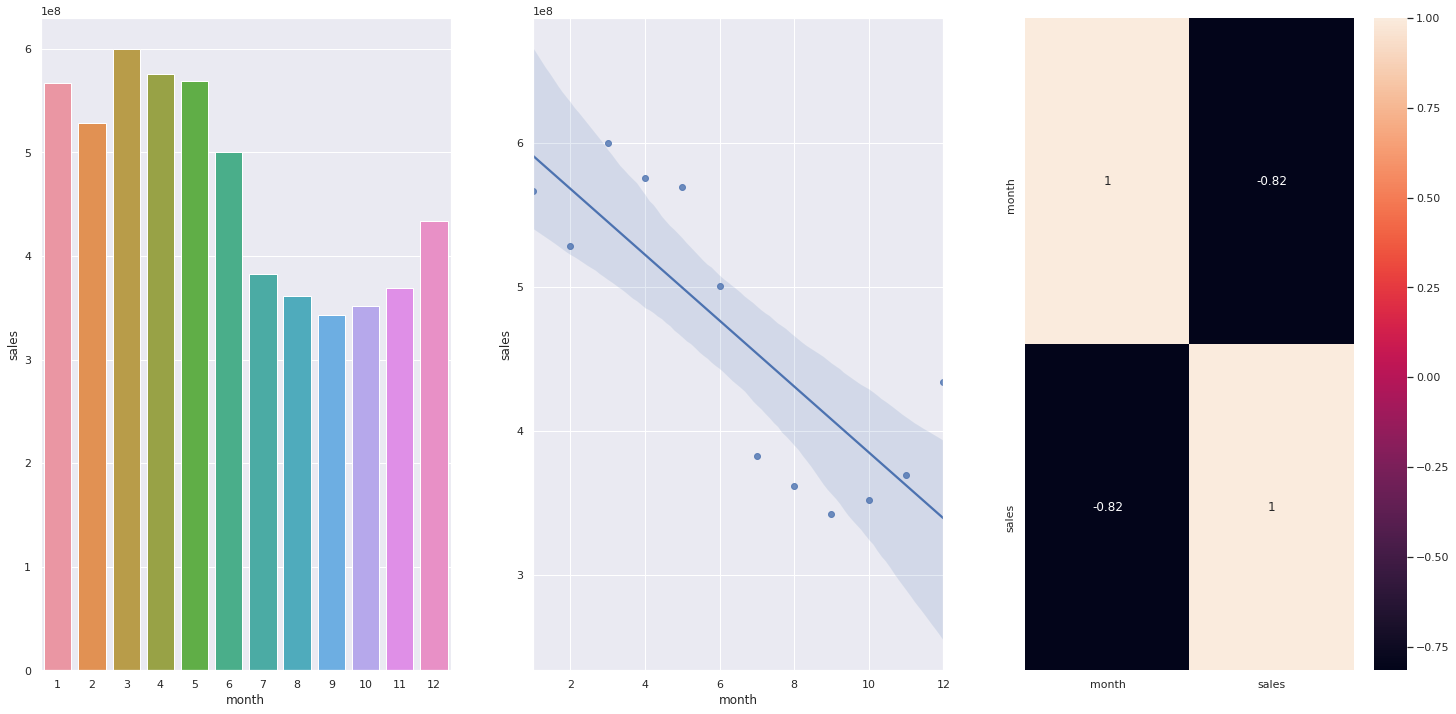

In [ ]:
aux1 = df4_train[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);

### **H6.**   Stores sell more during summer/winter breaks (schools)  
**FALSE**: School holidays in Germany are scattered throughout the year. The longest school holidays is the summer break in August and mid-September. During these months, stores sell less (refer to barplot above - H5)

### **H7.**   Stores sell less during school holidays
**TRUE**: Stores sell less during school holidays except in August

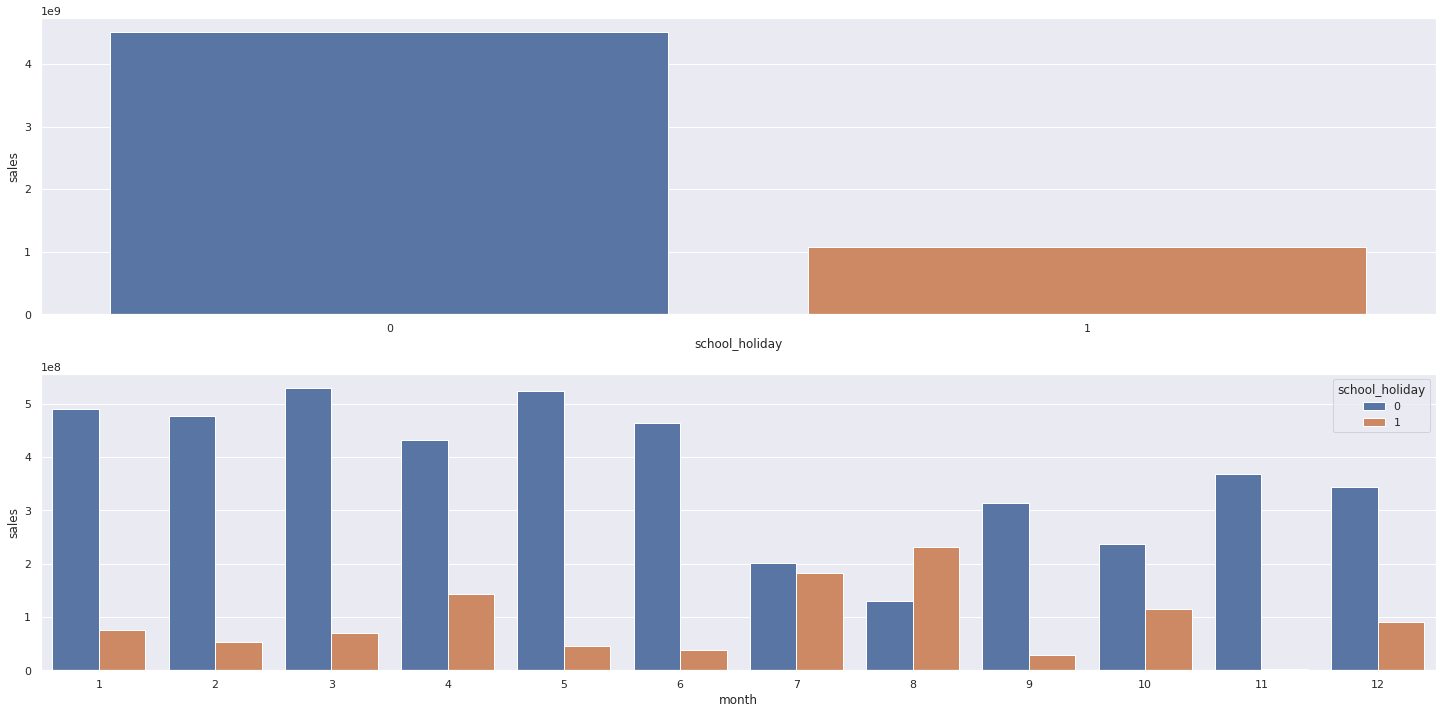

In [ ]:
aux1 = df4_train[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(211)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4_train[['school_holiday','sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(212)
sns.barplot(x = 'month', y= 'sales' , hue = 'school_holiday', data = aux2);

### **H8.**  Stores sell more on Christmas than other holidays
**FALSE**: Stores sell more on public holidays and Easter. However, our data doesn't capture christmas sales in 2015.

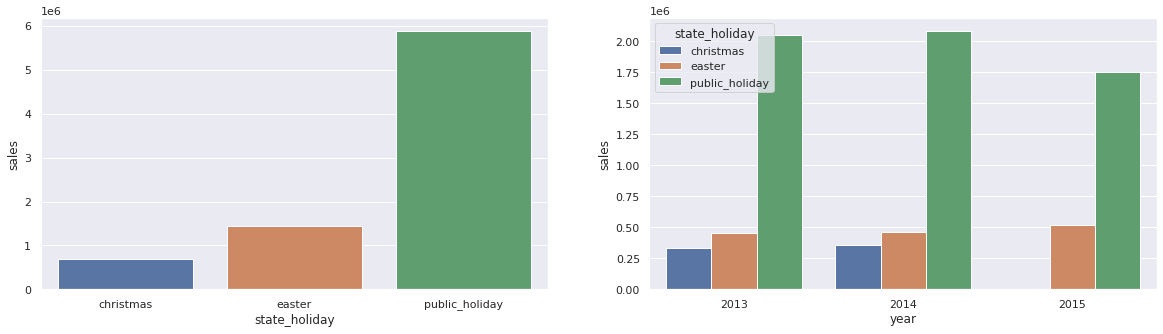

In [ ]:
aux1 = df4_train[df4_train['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.figure(figsize = (20,5))
plt.subplot(121)
sns.barplot(x='state_holiday',y='sales',data=aux2);

aux3 = aux1[['state_holiday', 'sales','year']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(122)
sns.barplot(x='year',y='sales', hue = 'state_holiday', data=aux3);

### **H9.** Stores are selling more along the years  
**FALSE**: Stores are selling less along the years. However, the year 2015 is not closed (dataset goes till mid 2015)

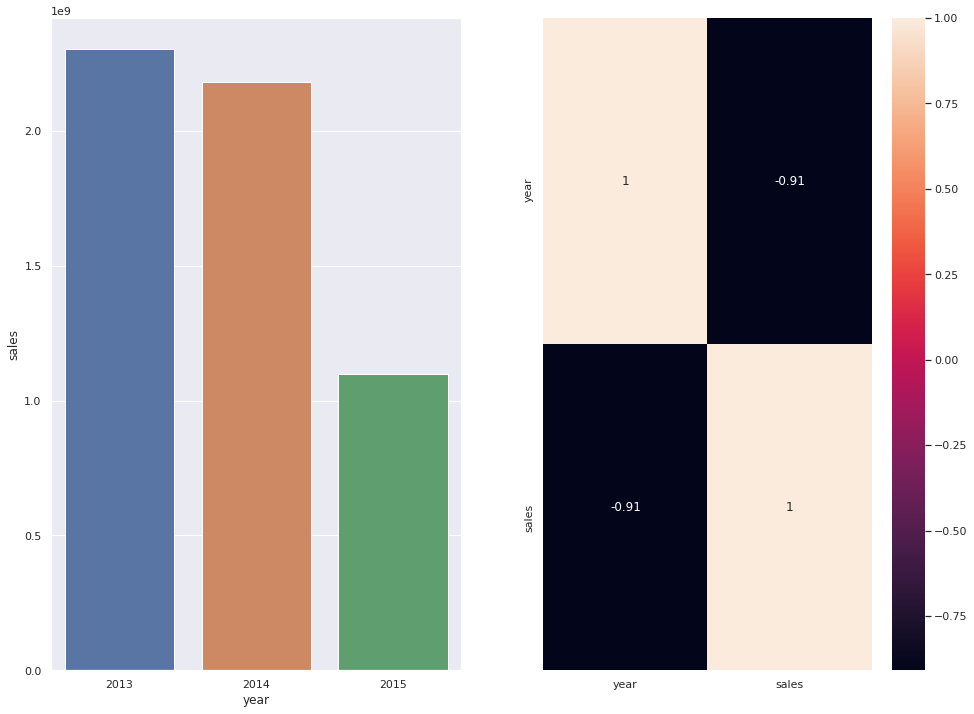

In [84]:
aux1 = df4_train[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(132)
sns.heatmap(aux1.corr(), annot = True);


### **H10.**  Stores sell more after day 10 of each month 
**TRUE**:  Stores sell more after day 10. Not a surprise, since there are more days after day 10.

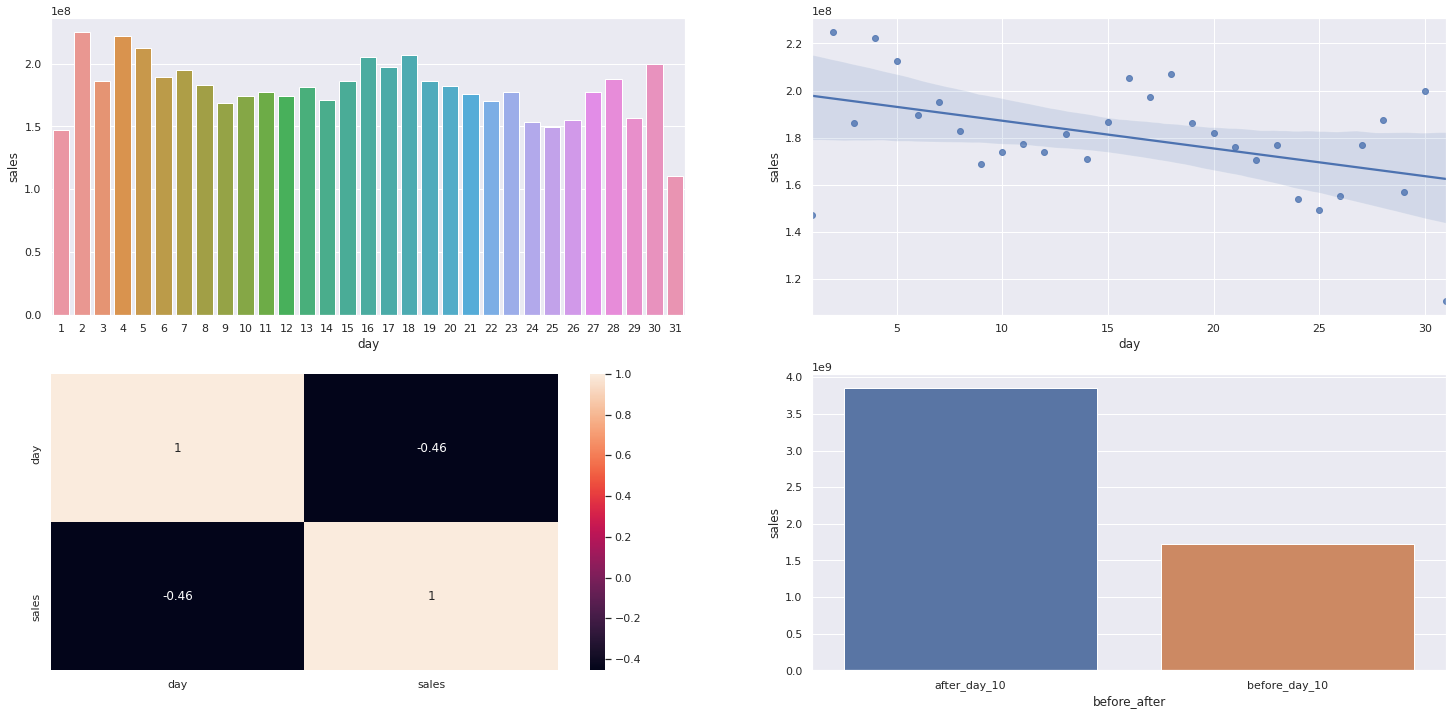

In [68]:

aux1 = df4_train[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(222)
sns.regplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(223)
sns.heatmap(aux1.corr(), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x < 10
                                         else 'after_day_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(224)
sns.barplot(x = 'before_after',y = 'sales', data = aux2);


### **H11.**  Stores frequently doing traditional promo sales sell more   
**TRUE**: Stores with more traditional promo sales days sell more.

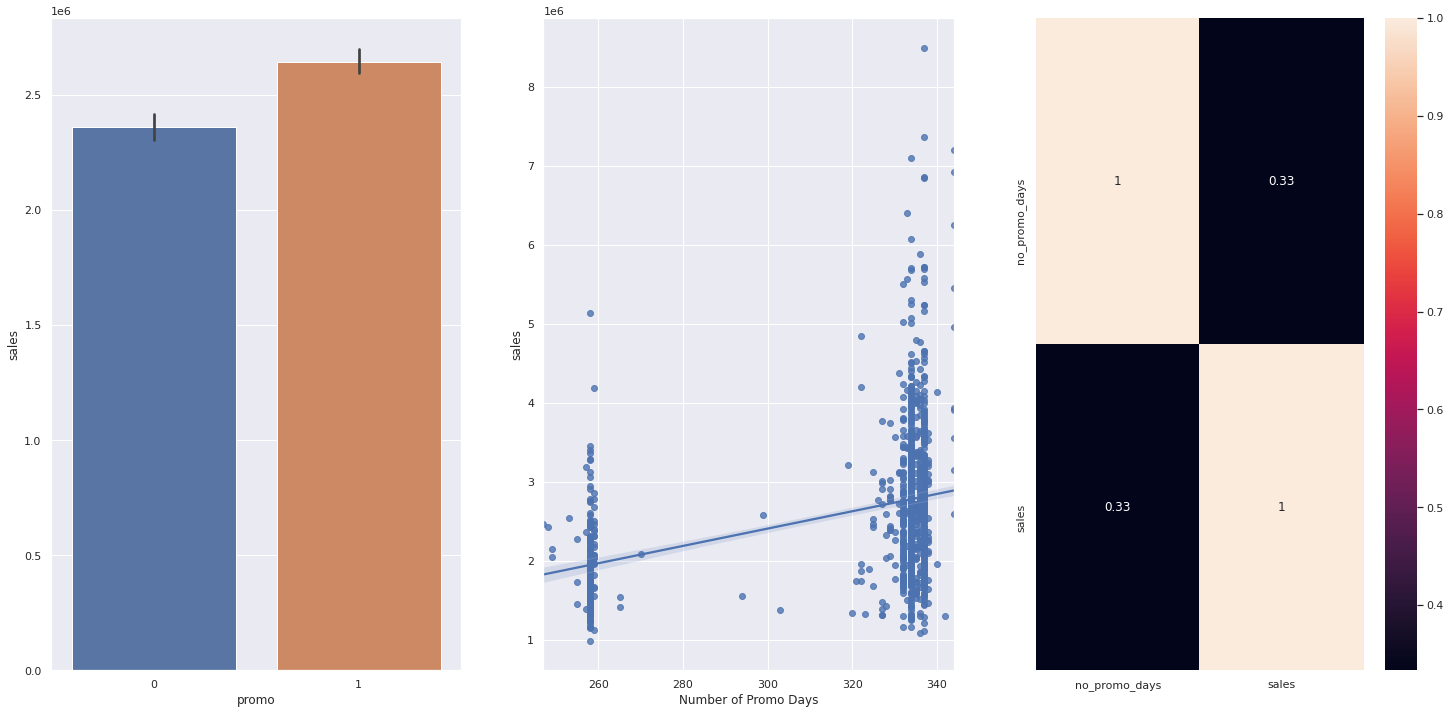

In [86]:
aux1 = df4_train[['store','promo','sales']].groupby(['store','promo']).sum().reset_index()
plt.subplot(131)
sns.barplot(x = 'promo', y = 'sales', data = aux1);

plt.subplot(132)
aux3 = df4_train[['store','promo','sales']].groupby(['store','promo']).count().reset_index()
aux4 = aux1[aux1['promo'] == 1]
aux4['no_promo_days'] = aux3[aux3['promo'] == 1]['sales']
sns.regplot(x = 'no_promo_days', y = 'sales', data = aux4);
plt.xlabel('Number of traditional promo days');
plt.ylabel('sales');
 

plt.subplot(133)
aux5 = aux4[['no_promo_days','sales']]
sns.heatmap(aux5.corr(), annot = True);

### **H12.**  Stores doing consecutive promo sales in the beginning of the year sell more
**TRUE**: Stores with consecutive promo sales sell more in the beginning of the year. However, sales are unstable for February.

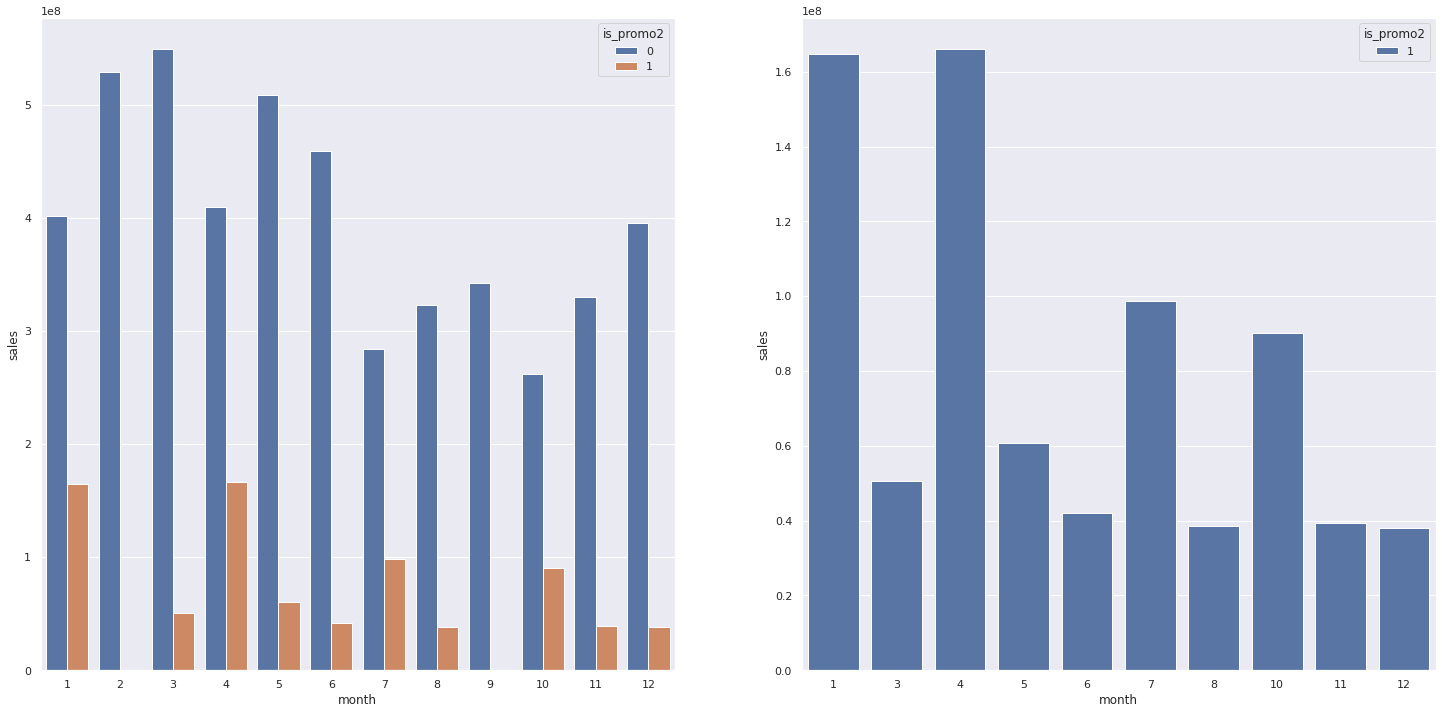

In [ ]:
aux1 = df4_train[['sales','month','is_promo2']].groupby(['is_promo2','month']).sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux1);

aux2 = aux1[aux1['is_promo2'] == 1]
plt.subplot(122)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux2);


### **H13.**  Stores participating in consecutive promo for a longer time sell more
**FALSE**: Stores participating in consecutive promo for a longer time sell less. For next cycle, we can split promo2_time_week into two variables (before and after promo).

Text(0.5, 0, 'sales not in promo2 (promo2_time_week < 0)')

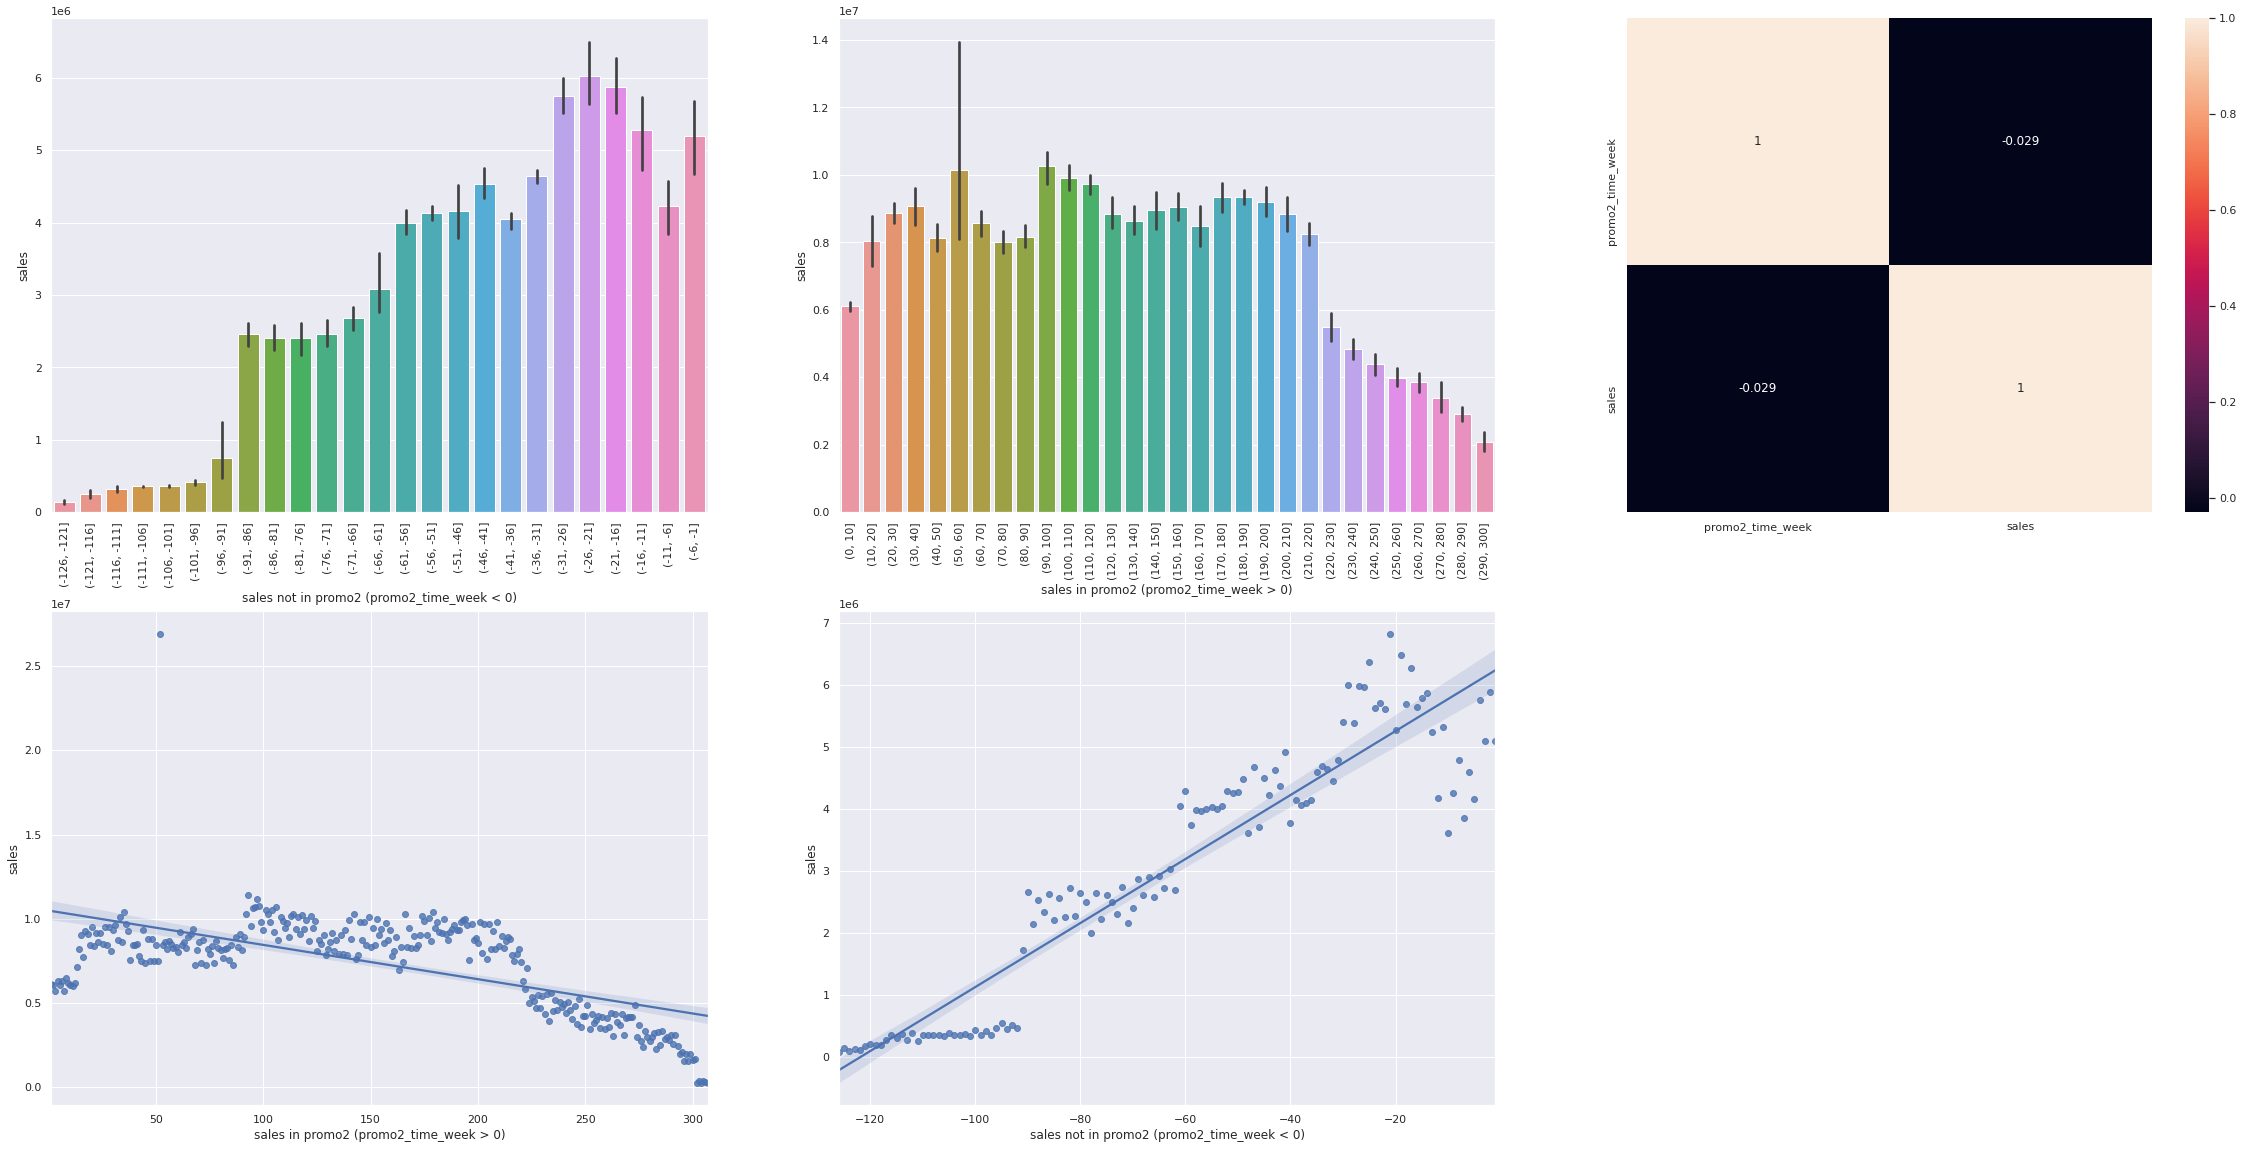

In [114]:
aux1 = df4_train[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()
plt.figure(figsize = (40,20))

plt.subplot(231)
aux3 = aux1[aux1['promo2_time_week'] < 0] # regular promo
bins2 = list(np.arange(-126,0, 5))
aux3['promo2_time_week_binned'] = pd.cut(aux3['promo2_time_week'], bins = bins2 )
sns.barplot(x = 'promo2_time_week_binned', y = 'sales', data = aux3);
plt.xticks(rotation=90);
plt.xlabel('sales not in promo2 (promo2_time_week < 0)')

plt.subplot(232)

aux2 = aux1[aux1['promo2_time_week'] > 0] # consecutive promo
bins = list(np.arange(0,307, 10))
aux2['promo2_time_week_binned'] = pd.cut(aux2['promo2_time_week'], bins= bins)
sns.barplot(x = 'promo2_time_week_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.xlabel('sales in promo2 (promo2_time_week > 0)')


plt.subplot(233)

sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(234)
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux2);
plt.xlabel('sales in promo2 (promo2_time_week > 0)');

plt.subplot(235)
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux3);
plt.xlabel('sales not in promo2 (promo2_time_week < 0)');


### **H14.**  Stores with more consecutive promo sale days sell more  
**TRUE**: Stores with more consecutive promo days sell more. However, sales volume is bigger for days with no consecutive promotion.

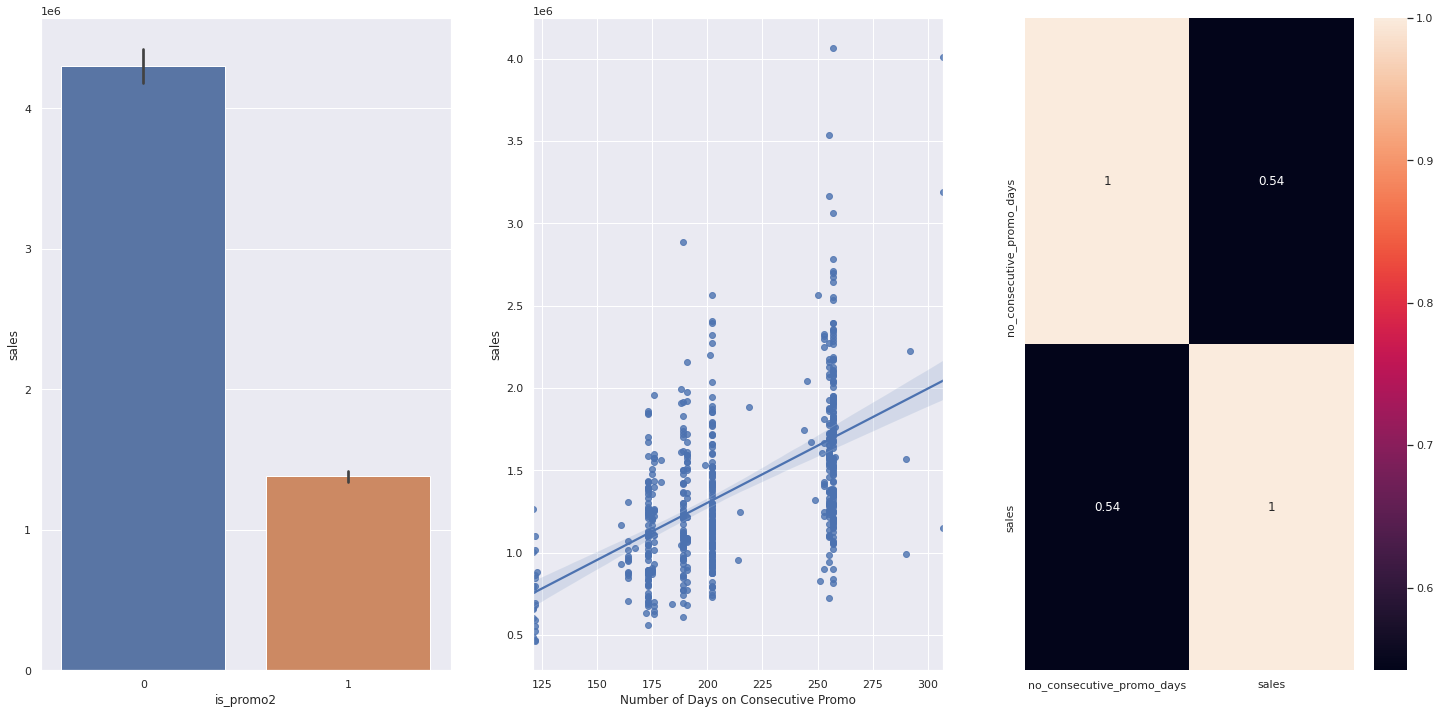

In [89]:
aux1 = df4_train[['store','is_promo2','sales']].groupby(['store','is_promo2']).sum().reset_index()
plt.subplot(131)
sns.barplot(x = 'is_promo2', y = 'sales', data = aux1);

plt.subplot(132)
aux3 = df4_train[['store','is_promo2','sales']].groupby(['store','is_promo2']).count().reset_index()
aux4 = aux1[aux1['is_promo2'] == 1]
aux4['no_consecutive_promo_days'] = aux3[aux3['is_promo2'] == 1]['sales']
sns.regplot(x = 'no_consecutive_promo_days', y = 'sales', data = aux4);
plt.xlabel('Number of Days on Consecutive Promo');
plt.ylabel('sales');
 

plt.subplot(133)
aux5 = aux4[['no_consecutive_promo_days','sales']]
sns.heatmap(aux5.corr(), annot = True);

### **H15.**  Stores sales increase when GDPpc increases (month)  
**FALSE**: Store sales decrease with GDPpc fluctuations over time. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

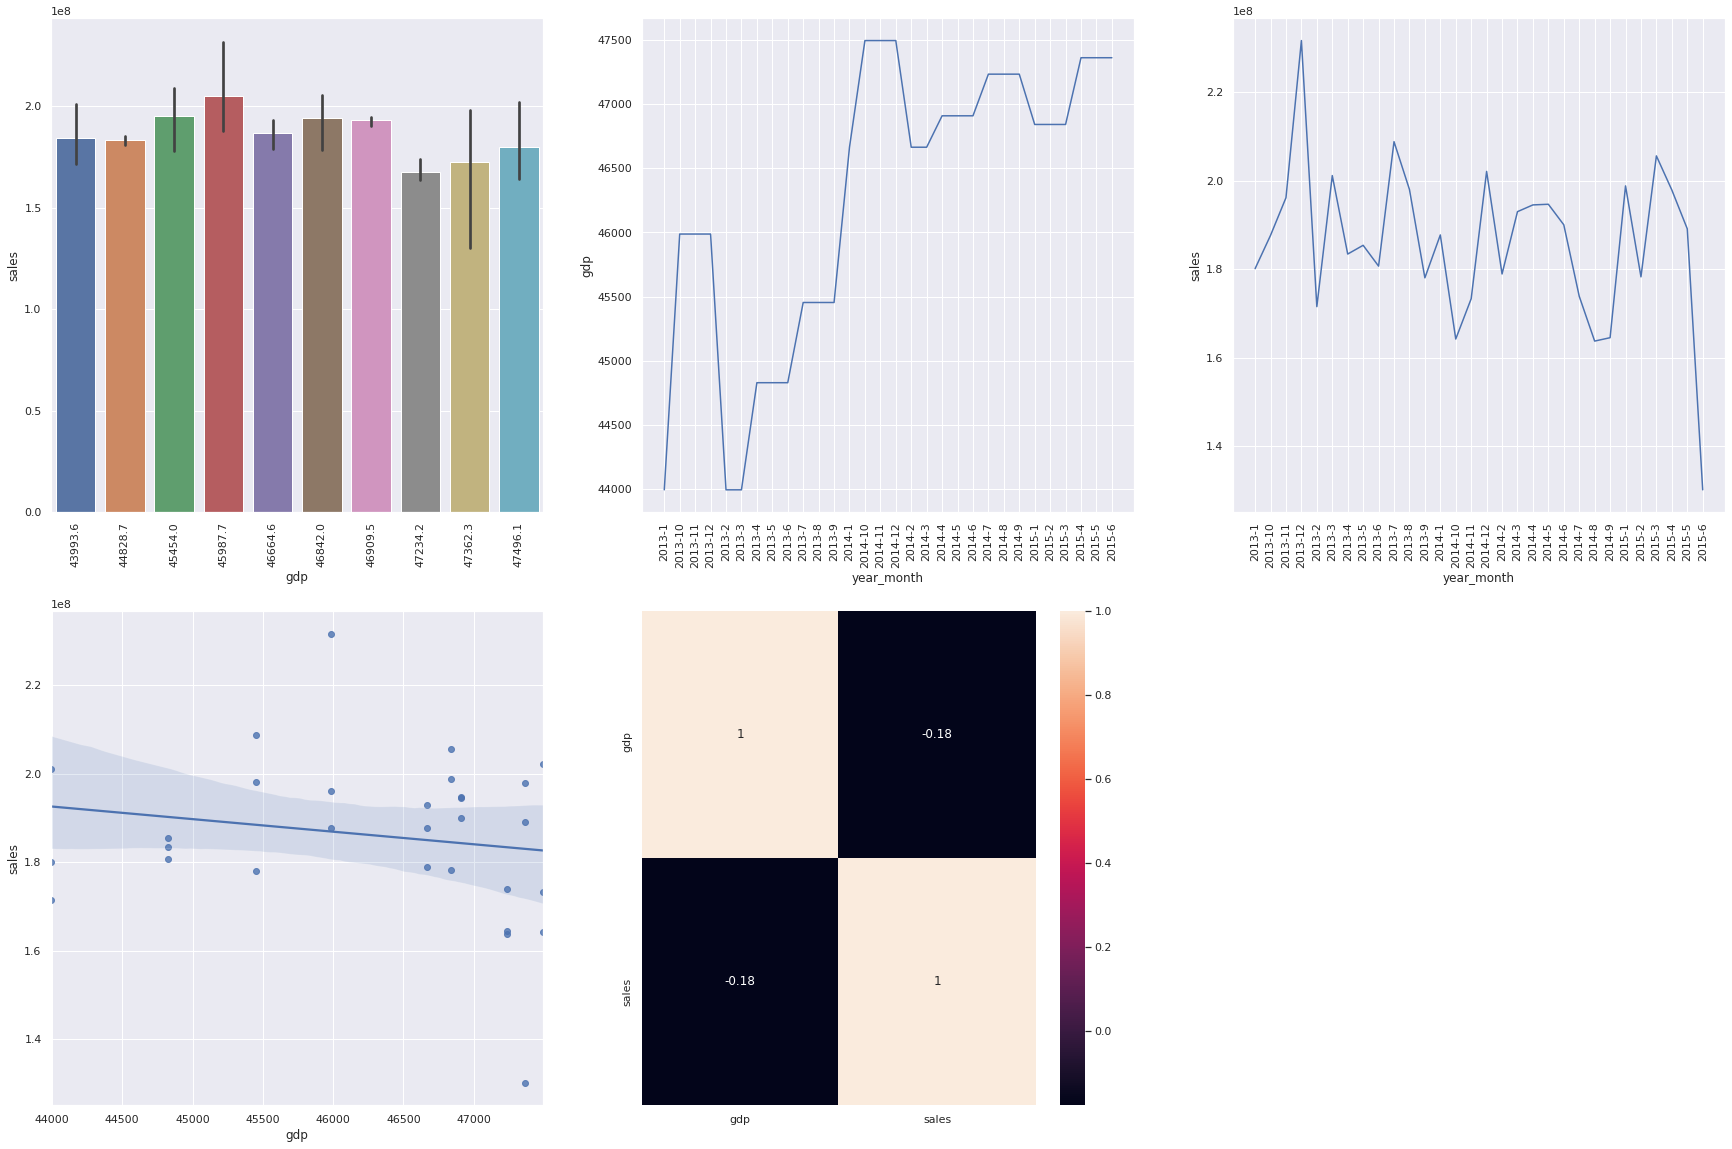

In [115]:
aux1 = df4_train[['year_month', 'gdp','sales']].groupby(['year_month','gdp']).sum().reset_index()

plt.figure(figsize = (30,20))

plt.subplot(231)
sns.barplot(x = 'gdp', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(232)

sns.lineplot(x = 'year_month', y = 'gdp', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(233)
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(234)

sns.regplot(x = 'gdp', y = 'sales', data = aux1);
plt.subplot(235)
aux2 = aux1[['gdp','sales']]
sns.heatmap(aux2.corr(), annot = True);


### **H16.**  Stores sales increase when interest rates decrease (month)
**FALSE**: Stores sales increase when interest rate increase over time. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

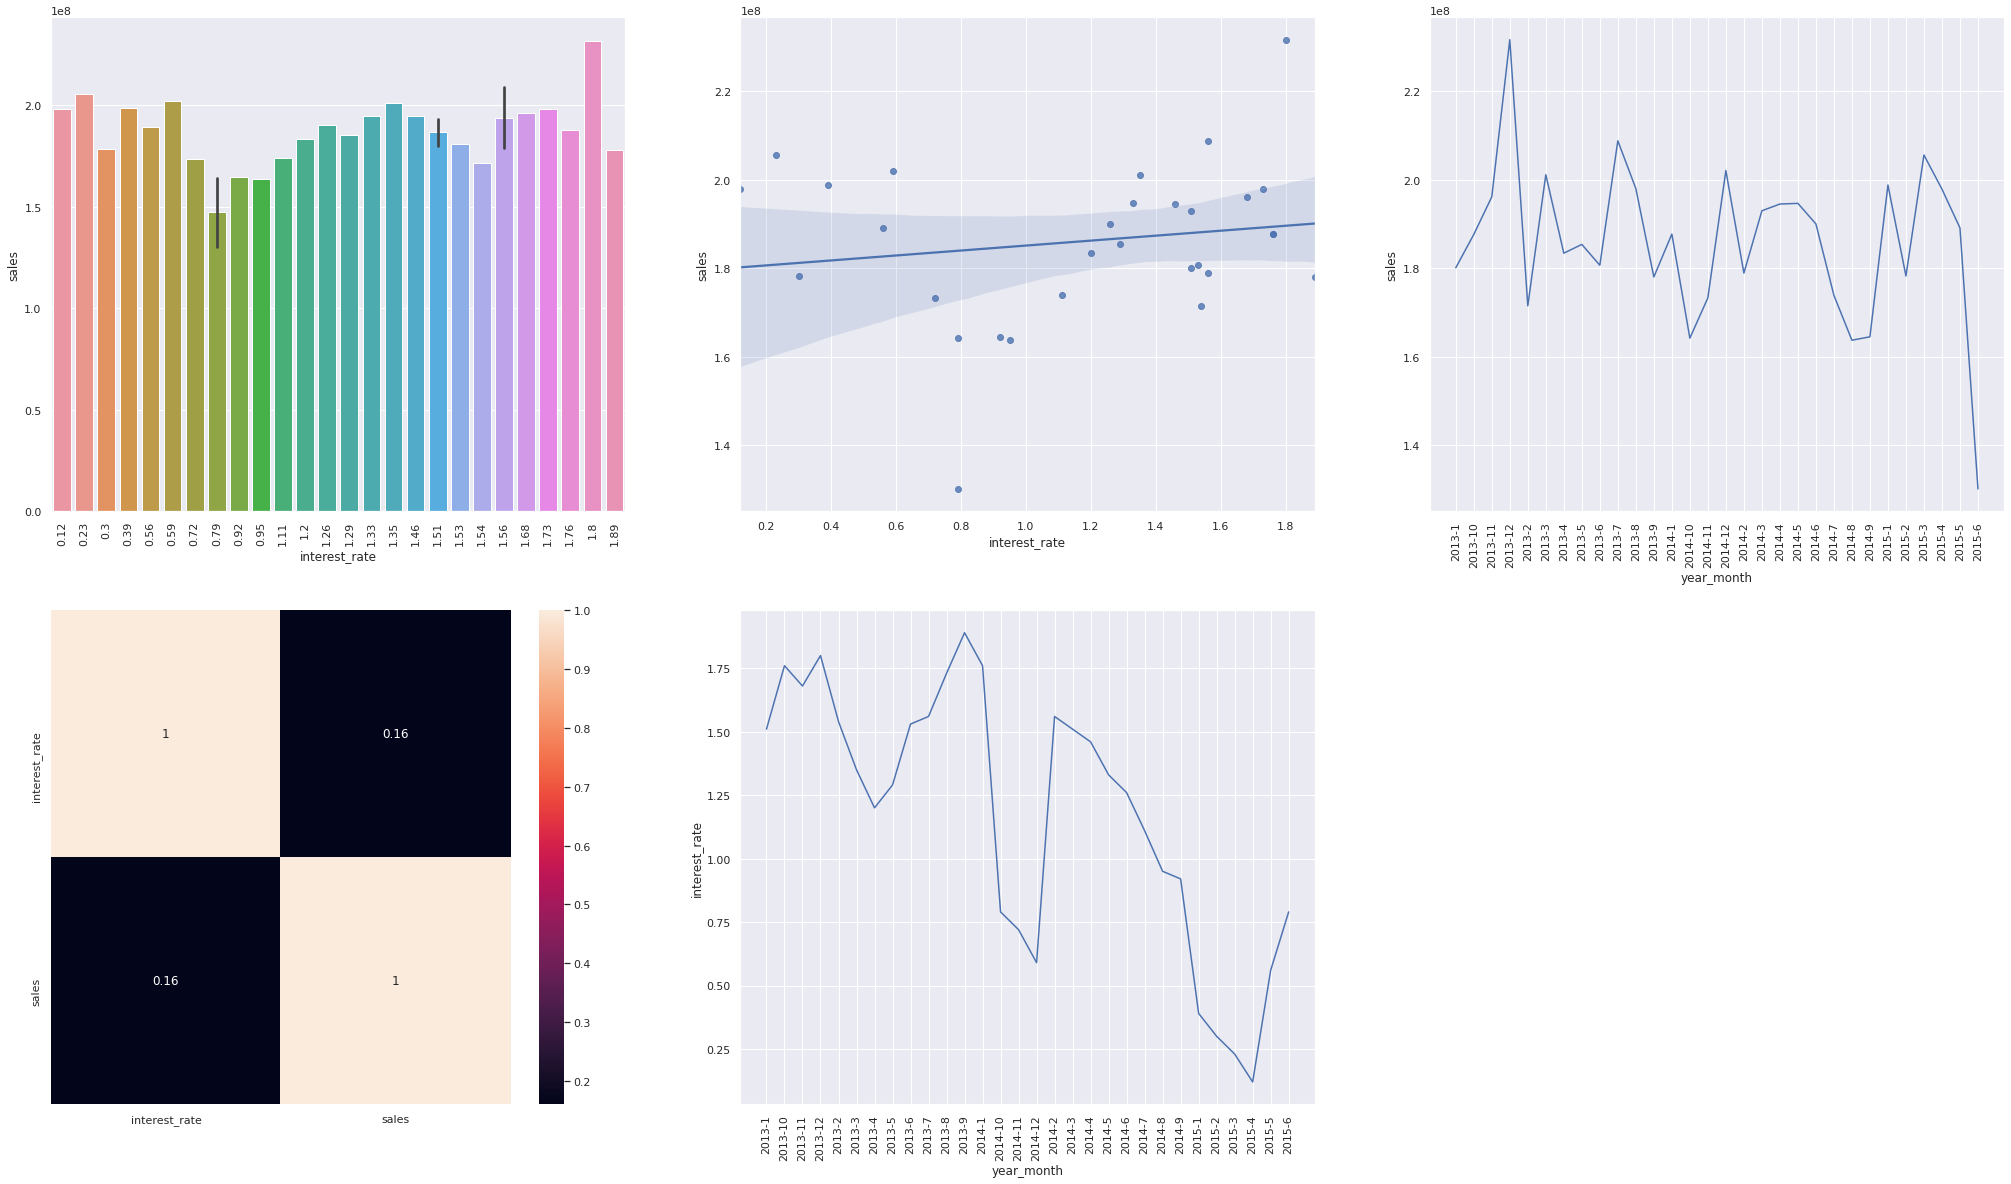

In [113]:
aux1 = df4_train[['year_month', 'interest_rate','sales']].groupby(['year_month','interest_rate']).sum().reset_index()

plt.figure(figsize = (35,20))

plt.subplot(231)
sns.barplot(x = 'interest_rate', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(232)
sns.regplot(x = 'interest_rate', y = 'sales', data = aux1);

plt.subplot(233)
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(234)
aux2 = aux1[['interest_rate','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(235)
sns.lineplot(x = 'year_month', y = 'interest_rate', data = aux1);
plt.xticks(rotation = 90);

### **H17.**  Stores sales increase when Consumer Price Index (CPI) rate increase (month)
**FALSE**: Store sales decrease when inflation increases. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

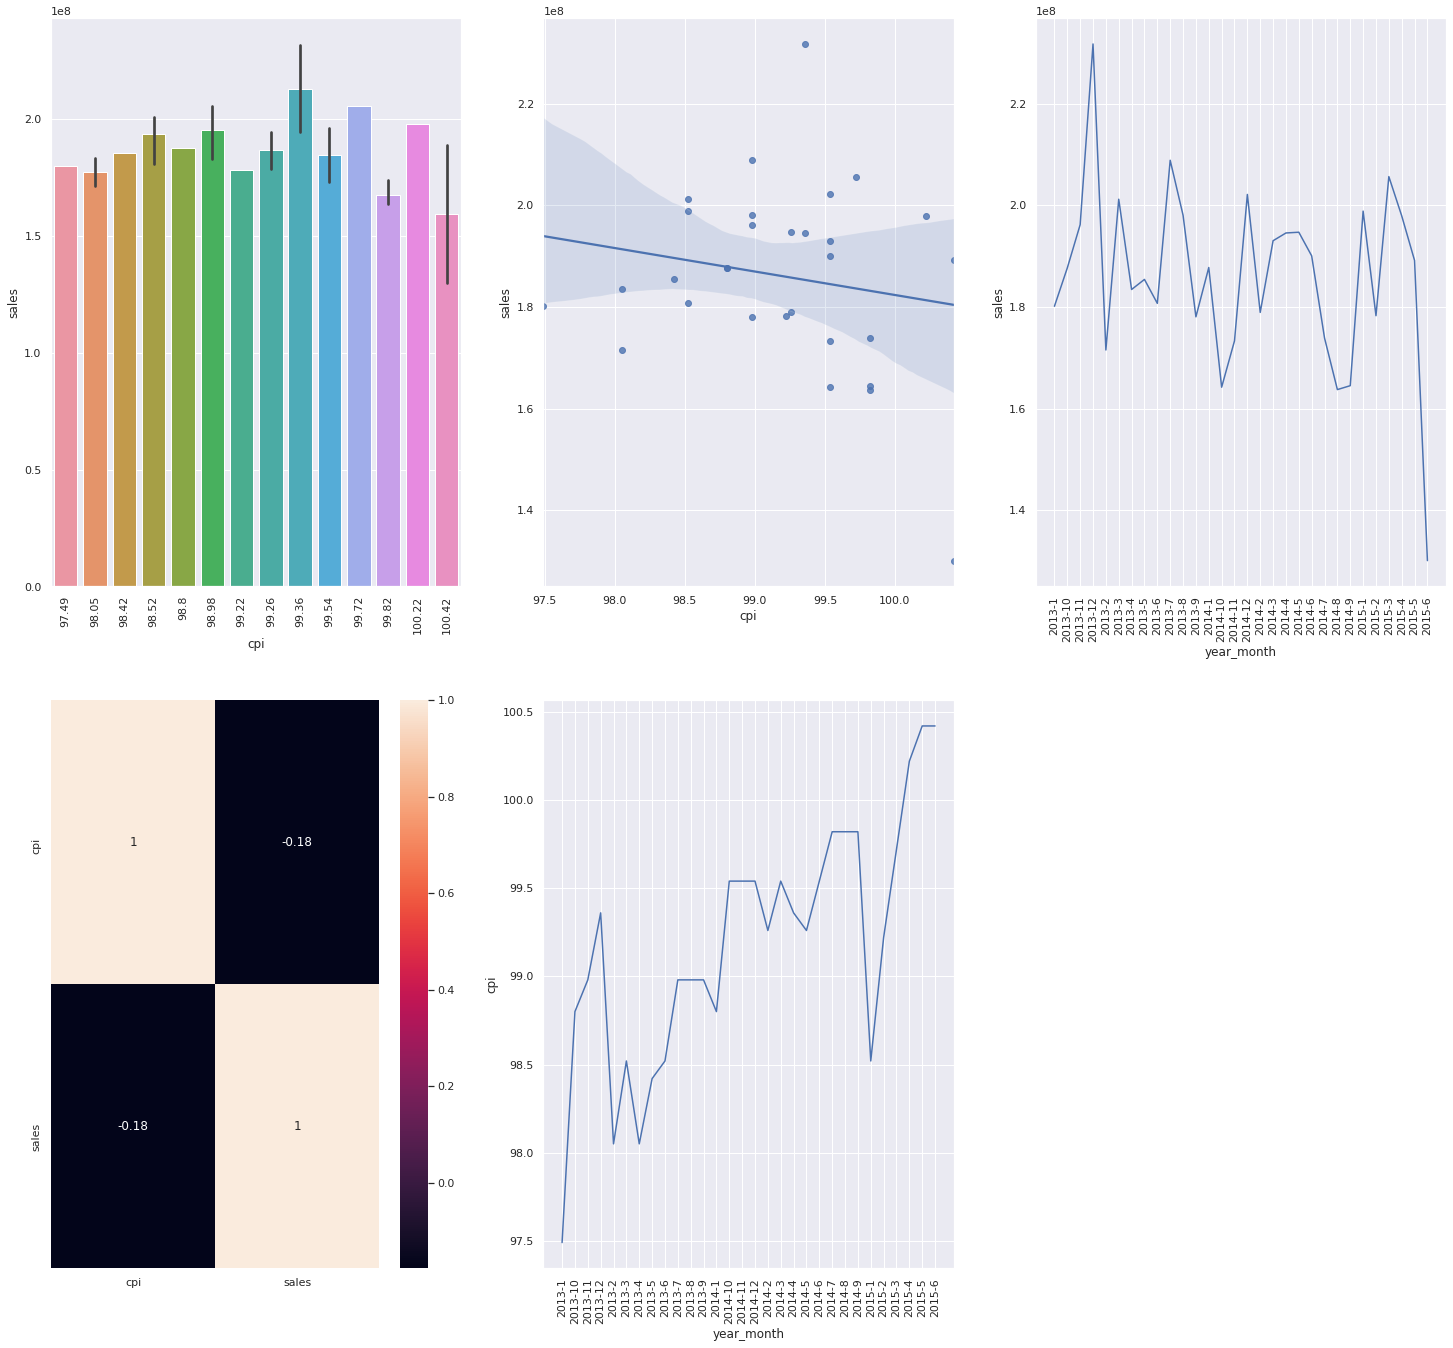

In [125]:
aux1 = df4_train[['year_month', 'cpi','sales']].groupby(['year_month','cpi']).sum().reset_index()

plt.figure(figsize = (25,23))

plt.subplot(231)
aux3 = aux1
aux3['cpi'] = round(aux3['cpi'], 2)
sns.barplot(x = 'cpi', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(232)
sns.regplot(x = 'cpi', y = 'sales', data = aux1);

plt.subplot(233)
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(234)
aux2 = aux1[['cpi','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(235)
sns.lineplot(x = 'year_month', y = 'cpi', data = aux1);
plt.xticks(rotation = 90);

### **H18.**  Store sales increase when Consumer Confidence Index (CCI) rate increases (month)    
**FALSE**: Store sales decrease when consumer confidence increase. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

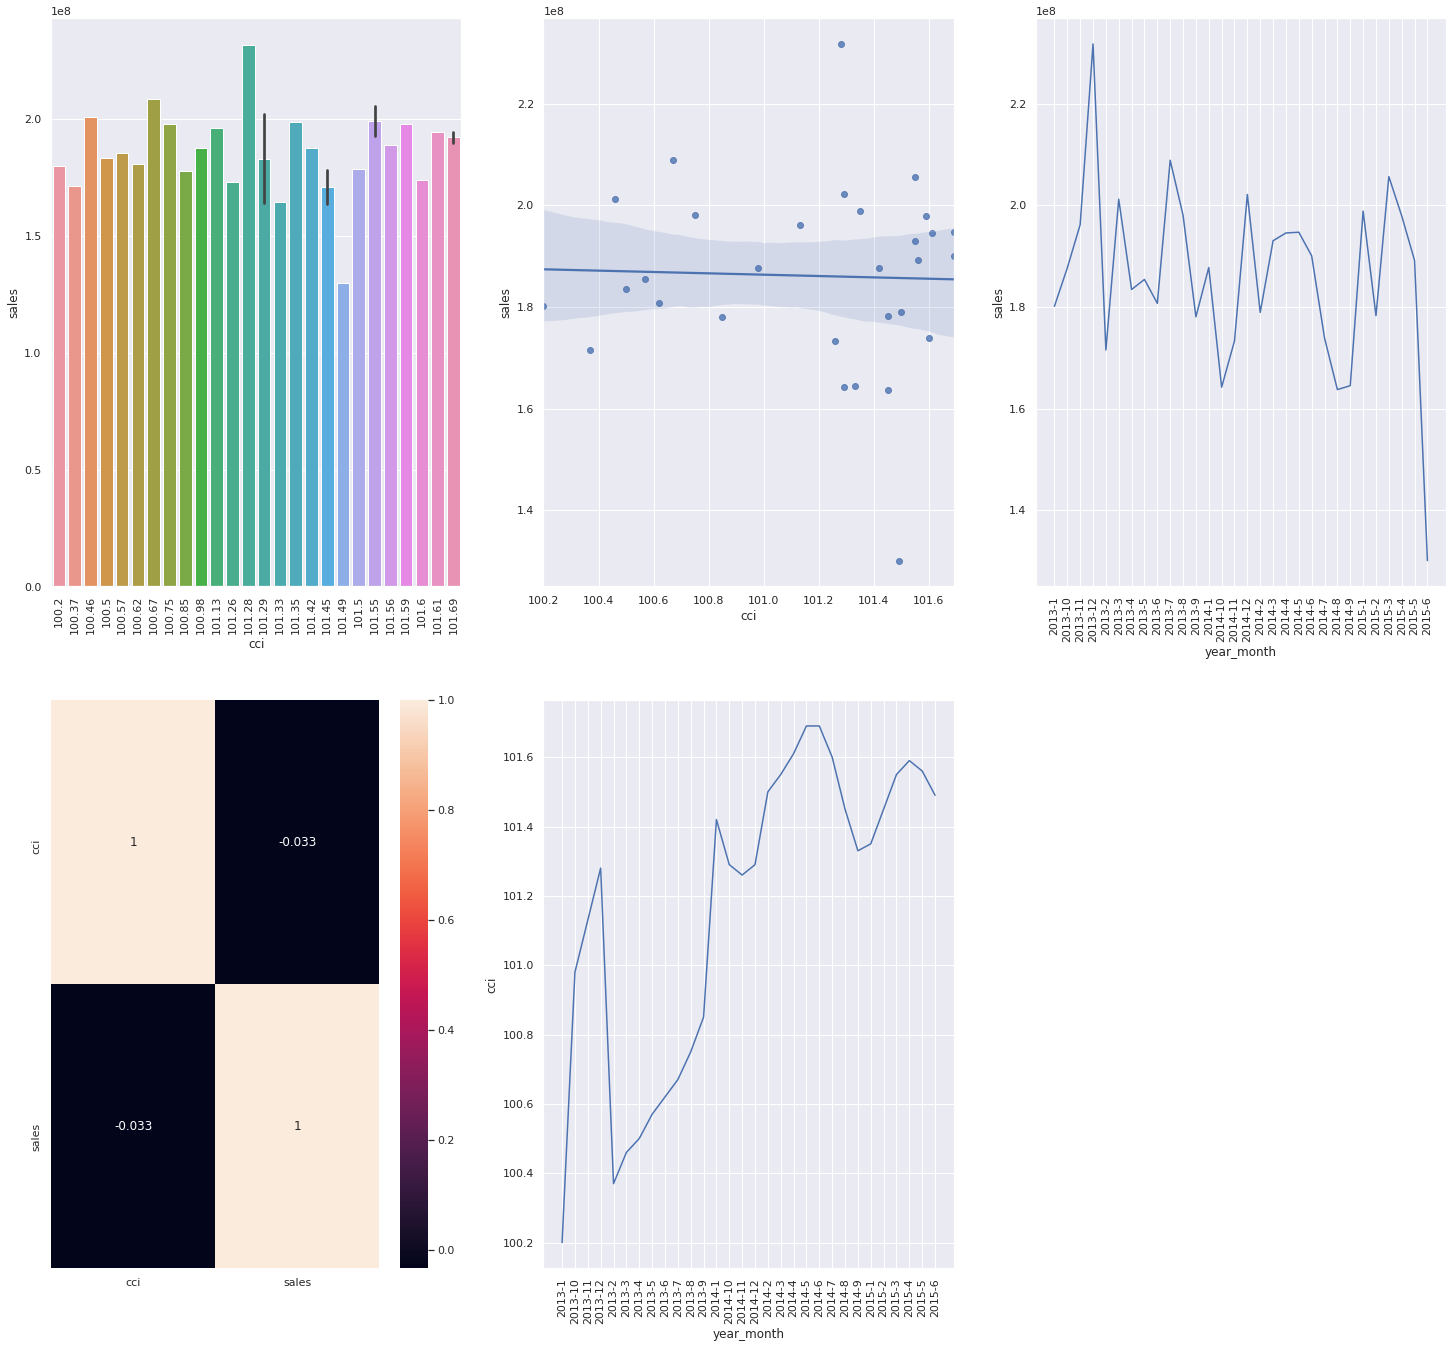

In [126]:
aux1 = df4_train[['year_month', 'cci','sales']].groupby(['year_month','cci']).sum().reset_index()

plt.figure(figsize = (25,23))

plt.subplot(231)
aux3 = aux1
aux3['cci'] = round(aux3['cci'], 2)
sns.barplot(x = 'cci', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(232)
sns.regplot(x = 'cci', y = 'sales', data = aux1);

plt.subplot(233)
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(234)
aux2 = aux1[['cci','sales']] 
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(235)
sns.lineplot(x = 'year_month', y = 'cci', data = aux1);
plt.xticks(rotation = 90);

### **H19.** Store sales increase when Unemployment rate decreases (month)   
**FALSE**: Store sales decrease when unemployment rate increase. We were expecting to confirm this hypothesis; therefore, we might drop it from our model.

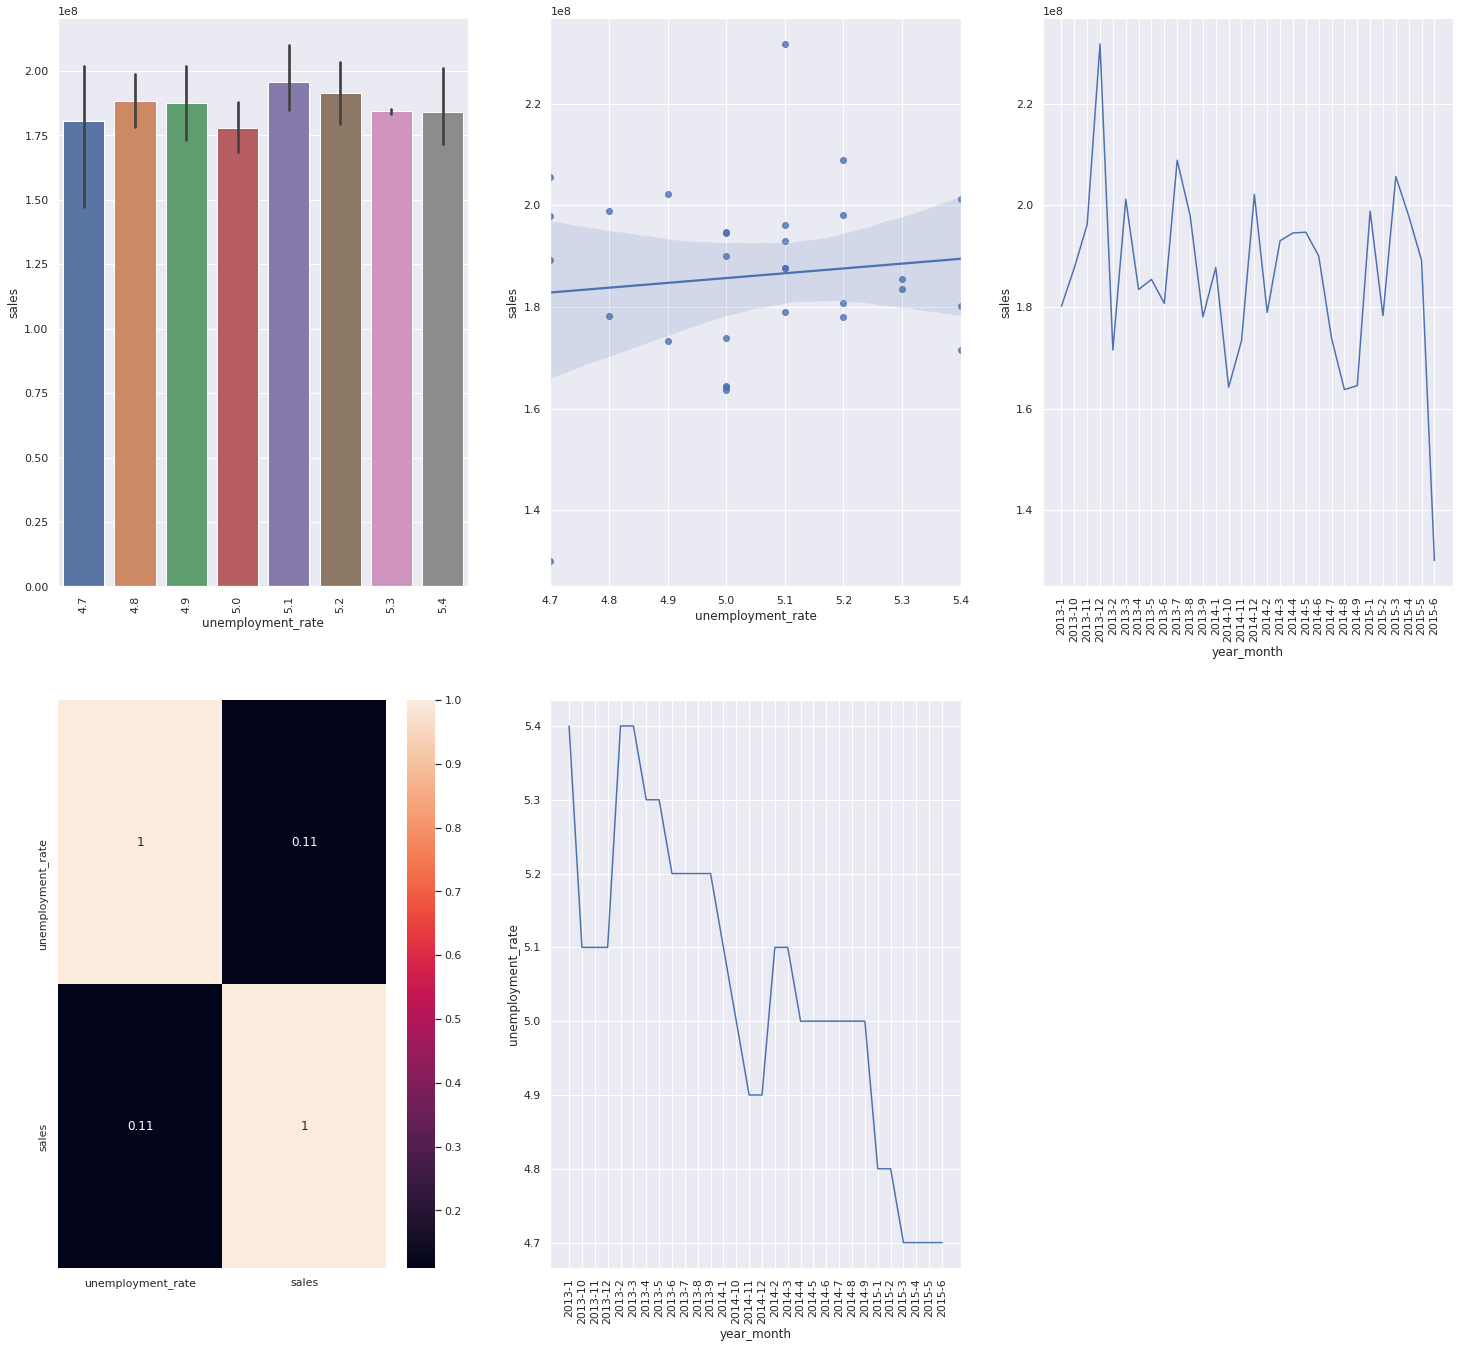

In [127]:
aux1 = df4_train[['year_month', 'unemployment_rate','sales']].groupby(['year_month','unemployment_rate']).sum().reset_index()

plt.figure(figsize = (25,23))

plt.subplot(231)
aux3 = aux1
aux3['unemployment_rate'] = round(aux3['unemployment_rate'], 2)
sns.barplot(x = 'unemployment_rate', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(232)
sns.regplot(x = 'unemployment_rate', y = 'sales', data = aux1);

plt.subplot(233)
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(234)
aux2 = aux1[['unemployment_rate','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(235)
sns.lineplot(x = 'year_month', y = 'unemployment_rate', data = aux1);
plt.xticks(rotation = 90);

### 4.3. Hypotheses Validation

In [98]:
# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['H1. Stores with extended assortment type sell more  ',
                                      'H2. Stores near competitors sell less',
                                      'H3. Stores with newly opened competitors sell less than stores with old competitors',
                                      'H4. Stores sell more on weekdays than weekends/holidays (sales rate)',
                                      'H5. Stores sell more during the 2nd semester',
                                      'H6. Stores sell more during summer/winter breaks (schools)',
                                      'H7. Stores sell less during school holidays',
                                      'H8. Stores sell more on Christmas than other holidays',
                                      'H9. Stores are selling more along the years',
                                      'H10. Stores sell more after day 10 of each month',
                                      'H11. Stores frequently doing standalone promo sales sell more',
                                      'H12. Stores doing consecutive promo sales in the beginning of the year sell more ',
                                      'H13. Stores participating in consecutive promo for a longer time sell more',
                                      'H14. Stores with more consecutive promo sale days sell more',
                                      'H15. Stores sales increase when GDPpc increases (month)',
                                      'H16. Stores sales increase when interest rates decrease (month)', 
                                      'H17. Stores sales increase when Consumer Price Index (CPI) rate increases (month)',  
                                      'H18. Stores sales increase when Consumer Confidence Index (CCI) rate increases (month)',
                                      'H19. Stores sales increase when Unemployment rate decreases (month)'],
                        'T/F':         ['False', 'False', 'False', 'True', 'False', 'False', 'True', 'False', 'True',
                                        'False', 'True', 'True', 'False','True','False', 'False','False','False', 'False'], 
                        'Relevance':   ['Low', 'High', 'Medium', 'Low', 'Medium', 'Low', 'Low', 'Medium', 'Low', 'High',
                                       'High', 'Medium','High','High','Low','Low','Low','Low','Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13,14,15,16,17,18,19])
summary




 
  

 
  
  
  
  
    


,Hypothesis,T/F,Relevance
1,H1. Stores with extended assortment type sell more,False,Low
2,H2. Stores near competitors sell less,False,High
3,H3. Stores with newly opened competitors sell less than stores with old competitors,False,Medium
4,H4. Stores sell more on weekdays than weekends/holidays (sales rate),True,Low
5,H5. Stores sell more during the 2nd semester,False,Medium
6,H6. Stores sell more during summer/winter breaks (schools),False,Low
7,H7. Stores sell less during school holidays,True,Low
8,H8. Stores sell more on Christmas than other holidays,False,Medium
9,H9. Stores are selling more along the years,True,Low
10,H10. Stores sell more after day 10 of each month,False,High


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

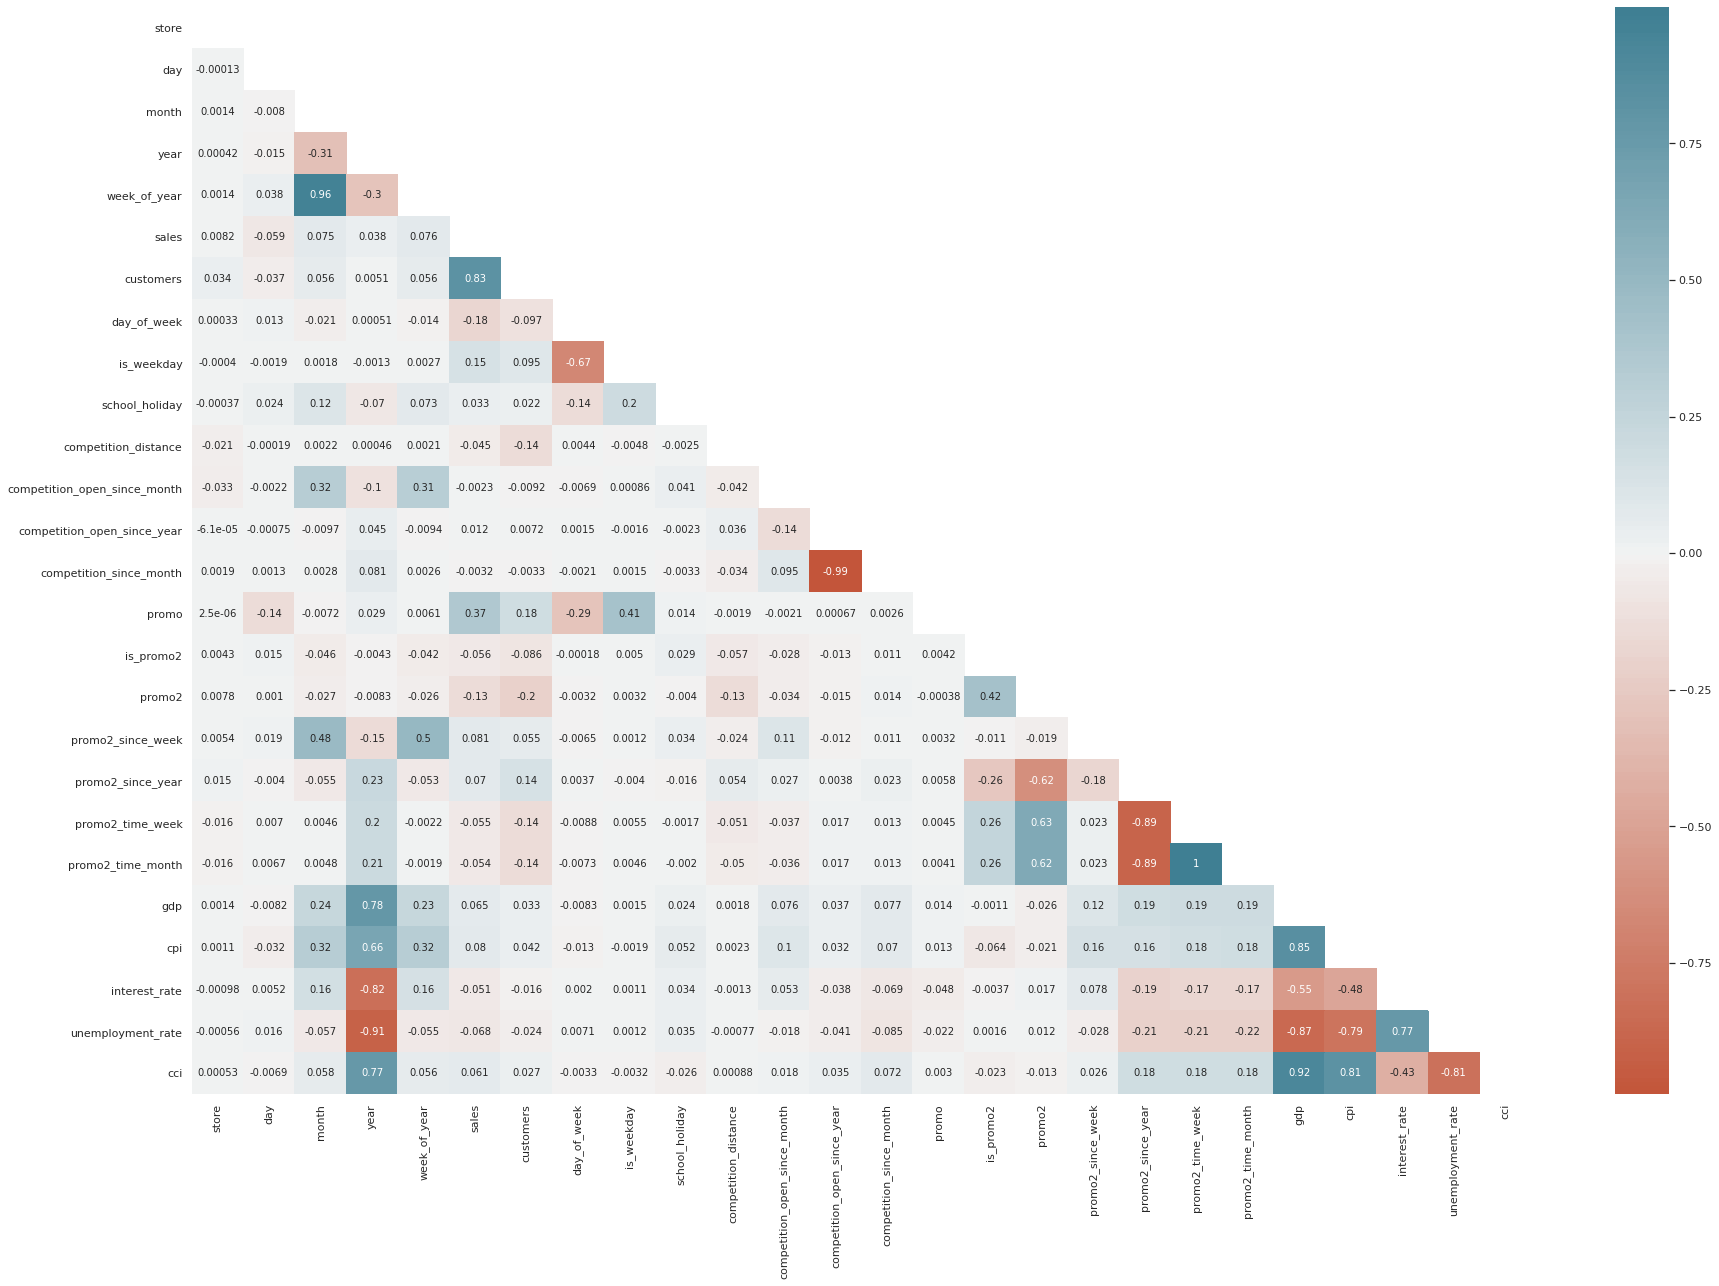

In [ ]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(num_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(num_feat.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );


**Multicollinearity**  
*Negative* *correlation*:  
1. competition_open_since_year vs competition_open_since_month    
2. year vs interest_rate 
3. promo2_since_year vs promo2_time_month  
4. promo2_since_year vs promo2_time_week  
5. day_of_week vs is_weekday  
6. year vs unemployment rate
7. gdp vs unemployment rate
8. cci vs unemployment rate

*Positive correlation:* 
1. month vs week_of_year  
2. gdp vs year  
3. cpi vs year  
4. gdp vs cpi  
5. promo2 vs promo2_time_week  
6. promo2 vs promo2_time_month  
7. cci vs year
8. cci vs gdp
9. cpi vs cci
10. interest rate vs unemployment rate
11.promo2_time_week  vs promo2_time_month  


**Positive Correlation with sales**  
1. Strong: customers    
2. Medium: promo  
3. Weak: is_weekday, promo2_since_year    
  

**Negative Correlation with sales**  
1. Strong: -    
2. Medium: -  
3. Weak: promo2, day_of_the_week      


### 4.3.1. Categorical Variables

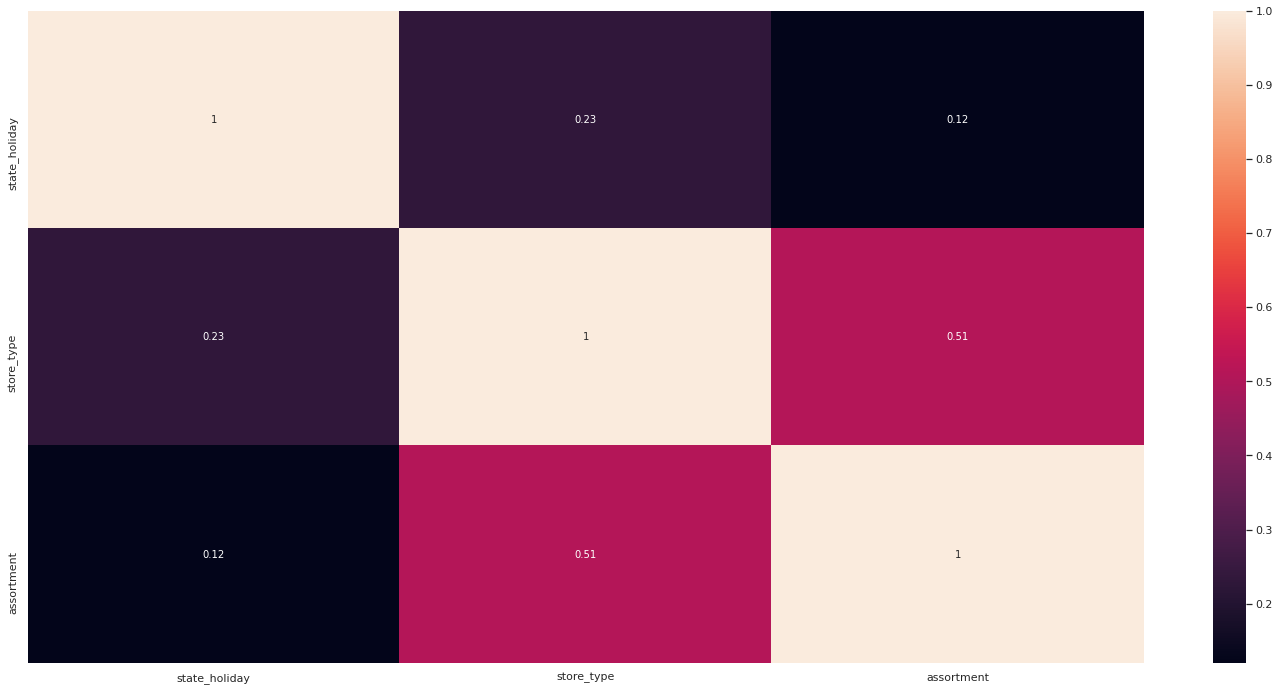

In [ ]:
# calculating cramer_V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap( d, annot=True );

**Multicollinearity**  
1. store_type and assortment have a mild positive correlation

# 5.0. STEP 05 - DATA PRE-PROCESSING

In [99]:
# copy previous dataset
df5_train = df4_train.copy()
df5_valid = df4_valid.copy()

In [100]:
# check dtypes
df5_train.dtypes

store                           int64         
date                            datetime64[ns]
day                             int64         
month                           int64         
year                            int64         
year_month                      datetime64[ns]
week_of_year                    int64         
year_week                       object        
sales                           int64         
customers                       int64         
day_of_week                     int64         
is_weekday                      int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    int64         
competition_open_since_year     int64         
competition_since               datetime64[ns]
competition_since_month         int64         
promo        

In [101]:
# Check the skew, kurtosis, and standard deviation of all numerical features

numeric_feats = df5_train.dtypes[(df5_train.dtypes != 'object') & (df5_train.dtypes != 'datetime64[ns]')].index
skewed_feats = df5_train[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
kurt_feats = df5_train[numeric_feats].apply(lambda x: stats.kurtosis(x.dropna())).sort_values(ascending=False)
std_feats = df5_train[numeric_feats].apply(lambda x: np.std(x.dropna())).sort_values(ascending=False)

statistics = pd.DataFrame({'Skew' :skewed_feats, 'Kurtosis': kurt_feats, 'std': std_feats})
statistics.sort_values('std', ascending = False)

,Skew,Kurtosis,std
competition_distance,4.601552,34.485472,9159.980497
sales,1.594645,4.842331,3106.852166
gdp,-0.732002,-0.728239,1115.607645
customers,2.775709,13.214691,401.911916
store,0.000396,-1.198880,321.729360
promo2_time_week,1.107059,0.132810,83.884411
competition_since_month,7.362951,127.674923,66.510895
promo2_time_month,1.109722,0.158304,19.450103
week_of_year,0.304091,-1.082674,14.711694
promo2_since_week,0.194301,-1.218618,14.449558


## 5.1. Standardization
No variable to be standardized

## 5.2. Rescaling

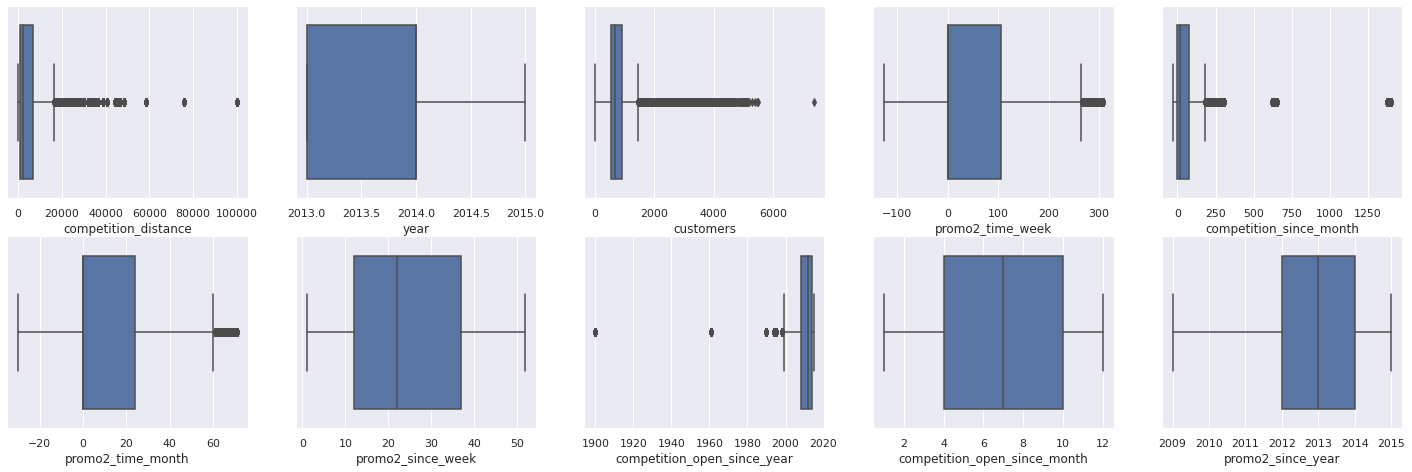

In [102]:
plt.subplot(3,5,1)
sns.boxplot(df5_train['competition_distance']);
plt.subplot(3,5,2)
sns.boxplot(df5_train['year']);
plt.subplot(3,5,3)
sns.boxplot(df5_train['customers']);
plt.subplot(3,5,4)
sns.boxplot(df5_train['promo2_time_week']);
plt.subplot(3,5,5)
sns.boxplot(df5_train['competition_since_month']);
plt.subplot(3,5,6)
sns.boxplot(df5_train['promo2_time_month']);
plt.subplot(3,5,7)
sns.boxplot(df5_train['promo2_since_week']);
plt.subplot(3,5,8)
sns.boxplot(df5_train['competition_open_since_year']);
plt.subplot(3,5,9)
sns.boxplot(df5_train['competition_open_since_month']);
plt.subplot(3,5,10)
sns.boxplot(df5_train['promo2_since_year']);

In [103]:
# set rescaling methods
rs = RobustScaler()
mms = MinMaxScaler()
boxcox = PowerTransformer(method = 'box-cox')
yeojohn = PowerTransformer(method = 'yeo-johnson')

In [104]:
## RobustScaler
# promo2_time_week (weeks of promo2 since it started)
rs_promo2_time_week = rs.fit(df5_train[['promo2_time_week']].values)
df5_train['promo2_time_week'] = rs_promo2_time_week.transform(df5_train[['promo2_time_week']].values)
df5_valid['promo2_time_week'] = rs_promo2_time_week.transform(df5_valid[['promo2_time_week']].values)

# promo2_time_month (months of promo2 since it started)
rs_promo2_time_month = rs.fit(df5_train[['promo2_time_month']].values)
df5_train['promo2_time_month'] = rs_promo2_time_month.transform(df5_train[['promo2_time_month']].values)
df5_valid['promo2_time_month'] = rs_promo2_time_month.transform(df5_valid[['promo2_time_month']].values)

## box-cox
# competition_distance
boxcox_competition_distance = boxcox.fit(df5_train[['competition_distance']].values)
df5_train['competition_distance'] = boxcox_competition_distance.transform(df5_train[['competition_distance']].values)
df5_valid['competition_distance'] = boxcox_competition_distance.transform(df5_valid[['competition_distance']].values)

# customers
boxcox_customers = boxcox.fit(df5_train[['customers']].values)
df5_train['customers'] = boxcox_customers.transform(df5_train[['customers']].values)
df5_valid['customers'] = boxcox_customers.transform(df5_valid[['customers']].values)

# competition_since_month (months of competition since it started)
yeojohn_competition_since_month = yeojohn.fit(df5_train[['competition_since_month']].values)
df5_train['competition_since_month'] = yeojohn_competition_since_month.transform(df5_train[['competition_since_month']].values)
df5_valid['competition_since_month'] = yeojohn_competition_since_month.transform(df5_valid[['competition_since_month']].values)


## MinMaxScaler
# year
mms_year = mms.fit(df5_train[['year']].values)
df5_train['year'] = mms_year.transform( df5_train[['year']].values)
df5_valid['year'] = mms_year.transform( df5_valid[['year']].values)



## 5.3. Transformation

### 5.3.1. Categorical Encoding

In [105]:
# merge train and valid datasets to guarantee equal number of columns across both datasets
df5 = pd.concat((df5_train, df5_valid)).reset_index(drop = True)
df5

,store,date,day,month,year,year_month,week_of_year,year_week,sales,customers,day_of_week,is_weekday,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,competition_since,competition_since_month,promo,is_promo2,promo2,promo2_since,promo2_since_week,promo2_since_year,promo2_time_week,promo2_time_month,gdp,cpi,interest_rate,unemployment_rate,cci
0,1,2015-06-18,18,6,1.0,2015-06-01,25,2015-24,4645,-0.724906,4,1,regular_day,0,c,basic,-0.386513,9,2008,2008-09-01,0.822605,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493
1,2,2015-06-18,18,6,1.0,2015-06-01,25,2015-24,5154,-0.306220,4,1,regular_day,0,a,basic,-0.862411,11,2007,2007-11-01,0.938799,1,0,1,2010-03-22,13,2010,2.575472,2.625000,47362.3,100.4167,0.79,4.7,101.493
2,3,2015-06-18,18,6,1.0,2015-06-01,25,2015-24,7537,0.207634,4,1,regular_day,0,a,basic,1.261481,12,2006,2006-12-01,1.072666,1,0,1,2011-03-28,14,2011,2.075472,2.125000,47362.3,100.4167,0.79,4.7,101.493
3,4,2015-06-18,18,6,1.0,2015-06-01,25,2015-24,8880,1.134030,4,1,regular_day,0,c,extended,-0.814004,9,2009,2009-09-01,0.676542,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493
4,5,2015-06-18,18,6,1.0,2015-06-01,25,2015-24,4924,-0.509138,4,1,regular_day,0,a,basic,1.848890,4,2015,2015-04-01,-0.510604,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,1111,2015-06-19,19,6,1.0,2015-06-01,25,2015-24,5618,-1.165344,5,1,regular_day,0,a,basic,-0.134408,6,2014,2014-06-01,-0.234467,1,0,1,2013-07-29,31,2013,0.924528,0.958333,47362.3,100.4167,0.79,4.7,101.493
844334,1112,2015-06-19,19,6,1.0,2015-06-01,25,2015-24,11240,0.558358,5,1,regular_day,0,c,extended,-0.141144,4,2006,2006-04-01,1.158970,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493
844335,1113,2015-06-19,19,6,1.0,2015-06-01,25,2015-24,7114,0.072666,5,1,regular_day,0,a,extended,0.946925,6,2015,2015-06-01,-0.598584,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493
844336,1114,2015-06-19,19,6,1.0,2015-06-01,25,2015-24,21834,3.126853,5,1,regular_day,0,a,extended,-0.615351,6,2015,2015-06-01,-0.598584,1,0,0,2015-06-15,25,2015,0.000000,0.000000,47362.3,100.4167,0.79,4.7,101.493


In [106]:
# # One Hot Encoding
# state_holiday 
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
# promo2_since_year
df5['promo2_since_year'] = df5['promo2_since_year'].astype(str)
df5 = pd.get_dummies(df5, prefix = ['promo2_since_year'], columns = ['promo2_since_year'])

# # Ordinal Encoding
# assortment
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# # Label Encoding
# store_type
le = LabelEncoder()
le_store_type = le.fit(df5['store_type'])
df5['store_type'] = le_store_type.transform(df5['store_type'])

# competition_open_since_year
df5['competition_open_since_year'] = df5['competition_open_since_year'].astype(str)
le_competition_open_since_year = le.fit(df5['competition_open_since_year'])
df5['competition_open_since_year'] = le_competition_open_since_year.transform(df5['competition_open_since_year'])

### 5.3.2. Response Variable Transformation

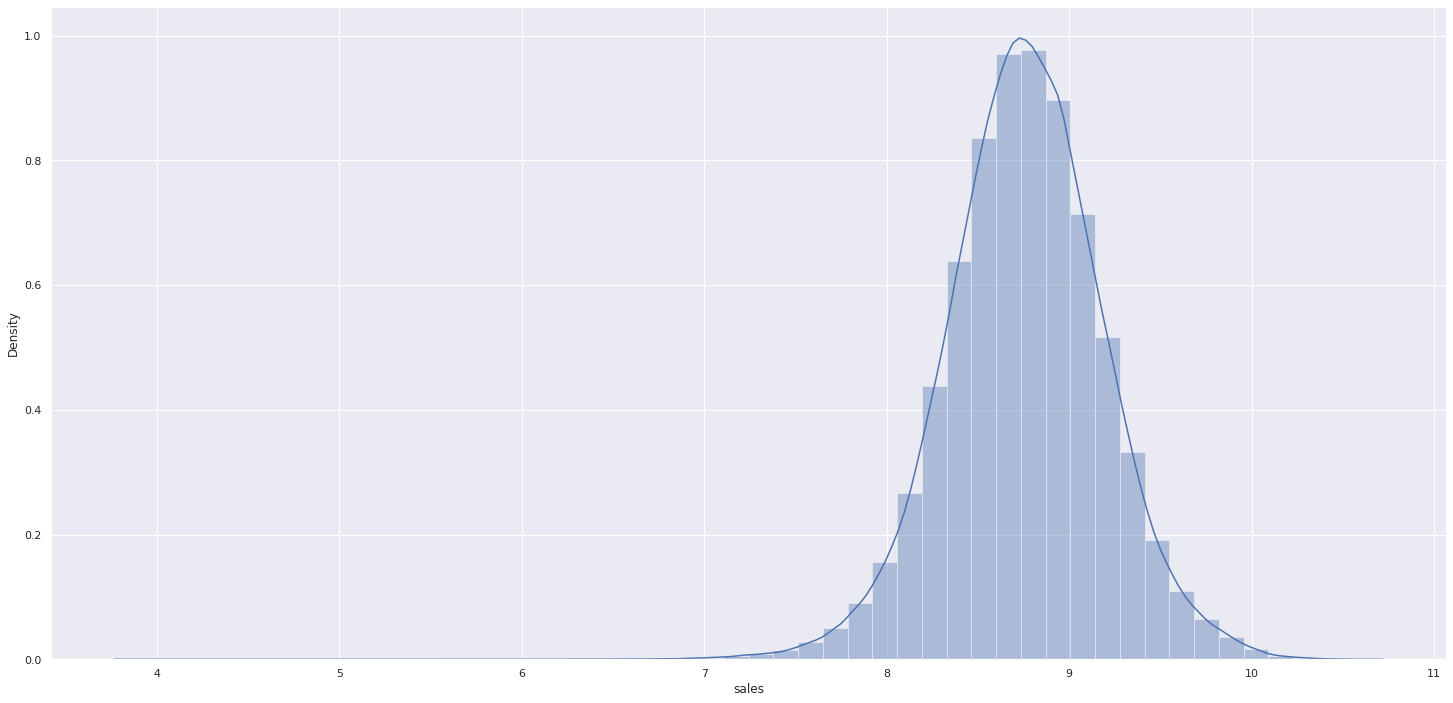

In [107]:
df5['sales'] = np.log1p(df5['sales']); # using log transformation
sns.distplot(df5['sales']);

### 5.3.3. Nature Transformation (cyclic)

In [108]:
## nature transform
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))
# week_of_year (W)
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# 6.0. STEP 06 - FEATURE SELECTION

In [109]:
# copy previous dataset
df6 = df5.copy()

## 6.1. Split Dataframe (train/validation)

In [110]:
# drop support variables from our dataset
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'promo2_since_week', 
             'competition_since', 'year_week', 'year_month', 'gdp','cpi','interest_rate','unemployment_rate','cci']
df6 = df6.drop( cols_drop, axis=1 )

In [111]:
### split data to original state
# training dataset
train = df6[df6['date'] < '2015-06-19']
# validation dataset
valid = df6[df6['date'] >= '2015-06-19']

# check dates
print( 'Train min date:{}'.format(train['date'].min()))
print( 'Train max date:{}'.format(train['date'].max()))
print( '\nValid min date:{}'.format(valid['date'].min()))
print( 'Valid max date:{}'.format(valid['date'].max()))

Train min date:2013-01-01 00:00:00
Train max date:2015-06-18 00:00:00

Valid min date:2015-06-19 00:00:00
Valid max date:2015-07-31 00:00:00


In [112]:
# check dataset shape
print('train data shape: {} // valid data shape: {}'.format(train.shape, valid.shape))

train data shape: (802942, 39) // valid data shape: (41396, 39)


In [113]:
### split target data from predictors
# training dataset
X_train = train.copy()
y_train = X_train['sales']

# validation dataset
X_valid = valid.copy()
y_valid = X_valid['sales']

# check  dates
print( 'Train min date:{}'.format(X_train['date'].min()))
print( 'Train max date:{}'.format(X_train['date'].max()))
print( '\nValid min date:{}'.format(X_valid['date'].min()))
print( 'Valid max date:{}'.format(X_valid['date'].max()))


Train min date:2013-01-01 00:00:00
Train max date:2015-06-18 00:00:00

Valid min date:2015-06-19 00:00:00
Valid max date:2015-07-31 00:00:00


## 6.2. Feature Selector (Boruta)

In [ ]:
# # transforming training and validation dataset into numpy array
# X_train_n = X_train.drop(['date','sales'], axis = 1).values
# y_train_n = y_train.values.ravel() # ravel flattens all numbers into a 1-D array

# # Model to be used on boruta
# rf = RandomForestRegressor(n_jobs = -1)

# # Defining Boruta
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n) 
# # rf = random forest, 'auto' = automatic selection of # trees, 'verbose' plotting each step
# # be careful = you can't pass a dataframe inside .fit

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	0
Rejected: 	16


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	0
Rejected: 	16


### 6.2.1. Selected Features

In [ ]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [ ]:
cols_selected_boruta

['store',
 'customers',
 'is_weekday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_since_month',
 'promo',
 'promo2',
 'promo2_time_week',
 'promo2_time_month',
 'promo2_since_year_2009',
 'month_cos',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

In [ ]:
cols_not_selected_boruta

['day_sin',
 'is_promo2',
 'month_sin',
 'promo2_since_year_2010',
 'promo2_since_year_2011',
 'promo2_since_year_2012',
 'promo2_since_year_2013',
 'promo2_since_year_2014',
 'promo2_since_year_2015',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
# cols_selected_boruta = ['store', 'customers', 'is_weekday', 'store_type', 'assortment',
#                         'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'competition_since_month',
#                         'promo', 'promo2', 'promo2_time_week', 'promo2_time_month', 'promo2_since_year_2009',
#                         'month_cos', 'day_cos', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'promo2_since_week_sin', 'promo2_since_week_cos']

# cols_not_selected_boruta = ['day_sin', 'is_promo2', 'month_sin', 'promo2_since_year_2010', 'promo2_since_year_2011', 'promo2_since_year_2012',
#  'promo2_since_year_2013', 'promo2_since_year_2014', 'promo2_since_year_2015', 'school_holiday', 'state_holiday_christmas', 'state_holiday_easter',
#  'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin',
#  'year']

## 6.3. Manual Feature Selection

In [114]:
# final list of columns to be utilized on our model
cols_selected_boruta_adapted = ['store', 'customers', 'is_weekday', 'store_type', 'assortment',
                                'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'competition_since_month',
                                'promo', 'promo2', 'promo2_time_week', 'promo2_time_month', 'promo2_since_year_2009', 'promo2_since_year_2010', 'promo2_since_year_2011', 'promo2_since_year_2012', 'promo2_since_year_2013', 'promo2_since_year_2014', 'promo2_since_year_2015',
                                'month_sin','month_cos', 'day_sin', 'day_cos','week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'promo2_since_week_sin', 'promo2_since_week_cos']



# add date and saçes variable
add_feat = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta_adapted.copy()
cols_selected_boruta_full.extend(add_feat)

In [115]:
cols_selected_boruta_full

['store',
 'customers',
 'is_weekday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'competition_since_month',
 'promo',
 'promo2',
 'promo2_time_week',
 'promo2_time_month',
 'promo2_since_year_2009',
 'promo2_since_year_2010',
 'promo2_since_year_2011',
 'promo2_since_year_2012',
 'promo2_since_year_2013',
 'promo2_since_year_2014',
 'promo2_since_year_2015',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos',
 'date',
 'sales']

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [116]:
# from the splitted dataset, use only boruta selected features for single ML model creation. 
x_train = X_train[ cols_selected_boruta_adapted ]
x_valid = X_valid[ cols_selected_boruta_adapted ]

# prepare dataset for cross_validation. We use df4 as our raw dataset from step 04.
cross_data = pd.concat((df4_train, df4_valid)).reset_index(drop = True)

## 7.1. Average Model


In [117]:
# copying valid data
aux1 = x_valid.copy()
# adding sales as a new column in aux1
aux1['sales'] = y_valid.copy()
# calculating sales mean of all stores (prediction)
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store') # merging x_valid with predictions

yhat_baseline = aux1['prediction']

# performance
baseline_result = ml_error('Average Model', np.expm1(aux1['sales']), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.1. Linear Regression Model


In [ ]:
# model 
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_valid)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_valid), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,943.49858,0.130327,1405.494251


### 7.1.1. Linear Regression Cross Validation 

In [ ]:
lr_cv = cross_validation(cross_data, 'Linear Regression', LinearRegression(), 5)
lr_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1033.93 +- 261.13,0.15 +- 0.03,1469.55 +- 316.84


## 7.2. Linear Regression Regularized Model - LASSO
For more details on LASSO, RIDGE and ELASTIC NET, check https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing#Observations

In [ ]:
# model 
lasso_reg = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lasso_reg = lasso_reg.predict(x_valid)

# performance
lasso_reg_result = ml_error('Lasso Regression', np.expm1(y_valid), np.expm1(yhat_lasso_reg))
lasso_reg_result


,Model Name,MAE,MAPE,RMSE
0,Lasso Regression,1007.104087,0.136954,1503.497953


### 7.2.1.  LASSO Cross Validation


In [ ]:
lasso_cv = cross_validation(cross_data, 'Lasso Regression', Lasso(alpha = 0.01), 5)
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Regression,931.04 +- 16.06,0.14 +- 0.0,1362.66 +- 21.99


## 7.3. Linear Regression Regularized Model - RIDGE


In [ ]:
# model 
ridge_reg = Ridge(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_ridge_reg = ridge_reg.predict(x_valid)

# performance
ridge_reg_result = ml_error('Linear Regression Ridge', np.expm1(y_valid), np.expm1(yhat_ridge_reg))
ridge_reg_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Ridge,943.498585,0.130327,1405.494265


### 7.3.1. RIDGE Cross Validation


In [ ]:
ridge_cv = cross_validation(cross_data, 'Ridge Regression', Ridge(alpha = 0.01), 5)
ridge_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Ridge Regression,1033.62 +- 260.51,0.15 +- 0.03,1469.19 +- 316.11


## 7.4. Linear Regression Regularized Model - ELASTIC NET


In [ ]:
# model 
elastic_reg = ElasticNet(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_elastic_reg = elastic_reg.predict(x_valid)

# performance
elastic_reg_result = ml_error('Linear Regression ElasticNet', np.expm1(y_valid), np.expm1(yhat_elastic_reg))
elastic_reg_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression ElasticNet,971.915437,0.133195,1453.227763


### 7.4.1. ELASTIC NET Cross Validation 


In [ ]:
elastic_cv = cross_validation(cross_data, 'Elastic Net Regression', ElasticNet(alpha = 0.01), 5)
elastic_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Elastic Net Regression,909.06 +- 14.28,0.14 +- 0.0,1335.03 +- 19.7


## 7.5. Random Forest Regressor Model

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_valid)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_valid), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,377.212267,0.053066,582.07237


### 7.5.1. Random Forest Cross Validation 


In [ ]:
rf_cv = cross_validation(cross_data, 'Random Forest Regression', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42), 5)
rf_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,438.84 +- 31.9,0.07 +- 0.01,666.4 +- 44.87


## 7.6. XGBoost Regressor Model

In [ ]:
# model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              learning_rate = 0.05,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train)

# prediction
yhat_xgb = xgb_model.predict(x_valid)

# performance

xgb_result = ml_error('XGBoost Regressor', np.expm1(y_valid), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,684.785932,0.091041,961.003655


### 7.6.1 XGBoost Cross Validation 


In [ ]:
xgb_cv = cross_validation(cross_data, 'XGB Regressor', xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              learning_rate = 0.05,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ), 5)
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB Regressor,619.28 +- 37.82,0.09 +- 0.01,891.97 +- 41.83


# 7.7. Model Performance


## 7.7.1. Single



In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lasso_reg_result, ridge_reg_result, elastic_reg_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,377.212267,0.053066,582.072370
0,XGBoost Regressor,684.785932,0.091041,961.003655
0,Linear Regression,943.498580,0.130327,1405.494251
0,Linear Regression Ridge,943.498585,0.130327,1405.494265
0,Linear Regression ElasticNet,971.915437,0.133195,1453.227763
0,Lasso Regression,1007.104087,0.136954,1503.497953
0,Average Model,1354.800353,0.206400,1835.135542


# 7.7.2. Cross-Validation


In [ ]:
modelling_result = pd.concat( [lr_cv, lasso_cv, ridge_cv, elastic_cv, rf_cv, xgb_cv])
modelling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1033.93 +- 261.13,0.15 +- 0.03,1469.55 +- 316.84
0,Lasso Regression,931.04 +- 16.06,0.14 +- 0.0,1362.66 +- 21.99
0,Ridge Regression,1033.62 +- 260.51,0.15 +- 0.03,1469.19 +- 316.11
0,Elastic Net Regression,909.06 +- 14.28,0.14 +- 0.0,1335.03 +- 19.7
0,Random Forest Regression,438.84 +- 31.9,0.07 +- 0.01,666.4 +- 44.87
0,XGB Regressor,619.28 +- 37.82,0.09 +- 0.01,891.97 +- 41.83


# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING


## 8.1. Random Search

In [ ]:
# set parameters to be randomly interated
param = {
   'n_estimators': [1000, 1500, 1700, 2500, 3000],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]  }

# number of evaluations
max_eval = 10

In [ ]:
# allocate all results in dataframe
final_result = pd.DataFrame()
for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( cross_data, 'XGBoost Regressor', model_xgb, 5, verbose=True )
    final_result = pd.concat( [final_result, result] )
       
final_result

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

Kfold Number: 1

Kfold Number: 2

Kfold Number: 3

Kfold Number: 4

Kfold Number: 5
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

Kfold Number: 1

Kfold Number: 2

Kfold Number: 3

Kfold Number: 4

Kfold Number: 5
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

Kfold Number: 1

Kfold Number: 2

Kfold Number: 3


### 8.2. Final Model

In [ ]:
# {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8} # best parameters
param_tuned = {
   'n_estimators': 1500,
   'eta': 0.03,
   'max_depth': 9,
   'subsample': 0.7,
   'colsample_bytree': 0.9 ,
   'min_child_weight':8
       }

In [ ]:
# model
xgb_model_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'], 
                              eta = param_tuned['eta'], 
                              max_depth = param_tuned['max_depth'], 
                              subsample = param_tuned['subsample'],
                              colsample_bytee = param_tuned['colsample_bytree'],
                              min_child_weight = param_tuned['min_child_weight'],
                              learning_rate = 0.05,
                              n_jobs=-1 ).fit(x_train, y_train, early_stopping_rounds = 5, eval_set = [(x_valid, y_valid)], verbose = False);


# prediction
yhat_xgb_tuned = xgb_model_tuned.predict(x_valid)

# performance
xgb_tuned_result = ml_error('XGBoost Regressor (Tuned)', np.expm1(y_valid), np.expm1(yhat_xgb_tuned) )
xgb_tuned_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor (Tuned),328.747807,0.047538,499.97318


In [ ]:
# Save Trained Model
pickle.dump( xgb_model_tuned, open( 'model_rossmann.pkl', 'wb' ) )

# # load pickle
# xgb_model_tuned = pickle.load(open ('model_rossmann.pkl', 'rb'))

# 9.0 STEP 09 - ERROR INTERPRETATION

In [ ]:
### to evaluate error, use valid dataset (since it's the right data to calculate error)
df9 = X_valid[cols_selected_boruta_full] # selecting validation data with all columns (including date and customers)

# rescale
df9['sales'] = np.expm1(df9['sales']) # real number of customers on valid dataset
df9['predictions'] = np.expm1(yhat_xgb_tuned) # predicted number of customers 


## 9.1. Business Performance for each store

In [ ]:
# we need to translate the error in financial terms.

# sum of predictions (how much money will enter on the next 6 weeks per store?)
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()
# MAE And MAPE
df9_mae = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_mape = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})
# merge MAE, MAPE, Predictions
df9_maemape = pd.merge(df9_mae, df9_mape, how = 'inner', on = 'store')
df_all = pd.merge(df9_maemape, df91, how = 'inner', on = 'store')
df_all
# Adding Scenarios
df_all['worst_scenario'] = df_all['predictions'] - df_all['MAE']
df_all['best_scenario'] = df_all['predictions'] + df_all['MAE']

# Ordering columns
df_all = df_all[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df_all

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,164003.593750,163862.189776,164144.997724,141.403974,0.032969
1,2,184712.359375,184380.860688,185043.858062,331.498687,0.066230
2,3,242338.921875,241942.738776,242735.104974,396.183099,0.055503
3,4,361681.250000,361300.184570,362062.315430,381.065430,0.038037
4,5,166483.312500,166259.505153,166707.119847,223.807347,0.047624
...,...,...,...,...,...,...
1110,1111,164835.531250,164472.772504,165198.289996,362.758746,0.068236
1111,1112,298250.031250,297634.114192,298865.948308,615.917058,0.070334
1112,1113,240087.140625,239808.991105,240365.290145,278.149520,0.041520
1113,1114,816971.875000,815787.520429,818156.229571,1184.354571,0.051121


### 9.1.1. Challenging Stores

In [ ]:
# challenging stores
df_all.sort_values('MAPE', ascending = False).head(8)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,279538.468750,275624.311205,283452.626295,3914.157545,0.206049
875,876,211455.437500,209037.572807,213873.302193,2417.864693,0.163841
291,292,101829.750000,99726.653262,103932.846738,2103.096738,0.148752
721,722,310494.656250,309648.100005,311341.212495,846.556245,0.116982
136,137,320046.906250,319239.757271,320854.055229,807.148979,0.115073
781,782,200361.515625,200002.278861,200720.752389,359.236764,0.110439
303,304,271281.968750,270597.683607,271966.253893,684.285143,0.107330
182,183,197153.343750,196533.066611,197773.620889,620.277139,0.104268


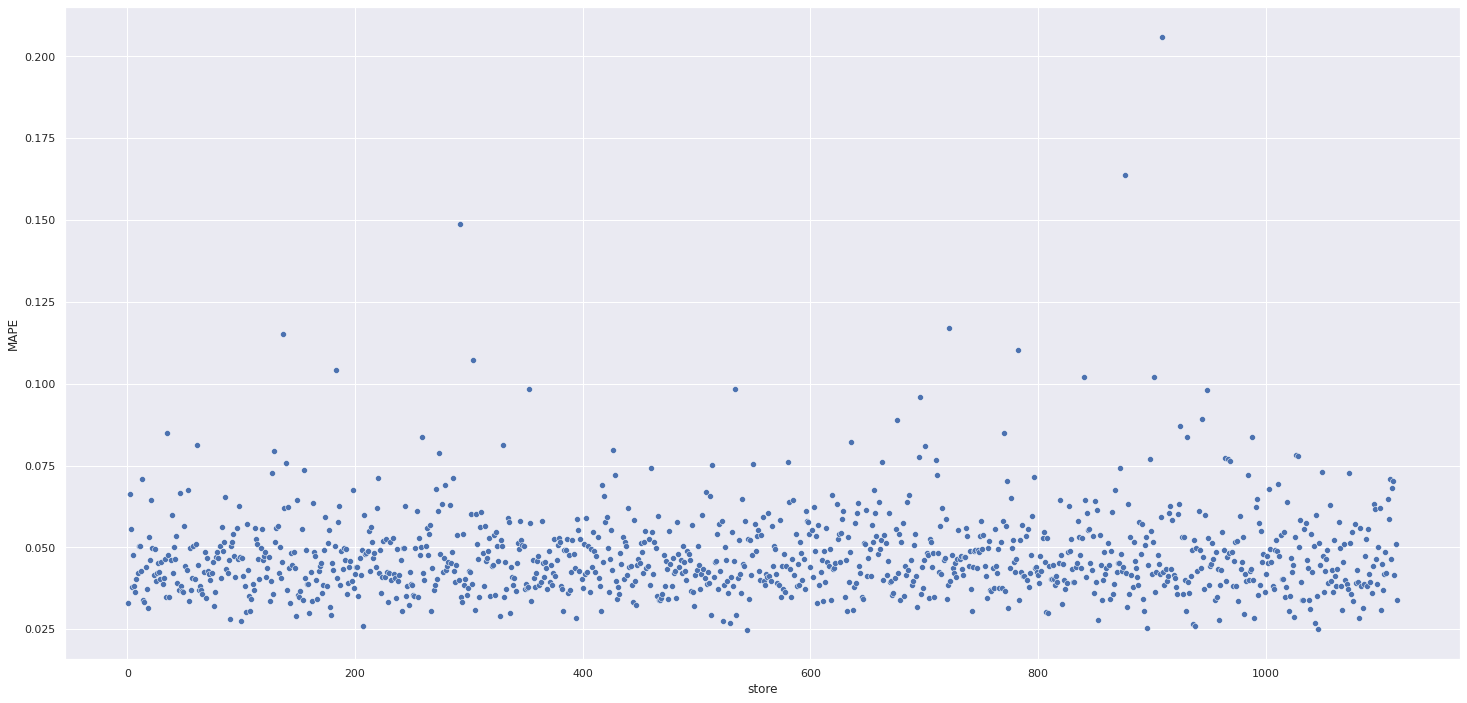

In [ ]:
# scatterplot of challenging stores
sns.scatterplot(x = 'store', y = 'MAPE', data = df_all);

## 9.2. Total Performance (Total sales revenue for the next 6 weeks)

In [ ]:
df_performance = df_all[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), 
                                                               axis = 0).reset_index().rename(columns = 
                                                                {'index':'Scenario', 0:'Total Sales (6w)'})
df_performance['Total Sales (6w)'] = df_performance['Total Sales (6w)'].map('{:,.2f}'.format)
df_performance

,Scenario,Total Sales (6w)
0,predictions,"286,086,592.00"
1,worst_scenario,"285,717,797.38"
2,best_scenario,"286,455,421.13"


## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

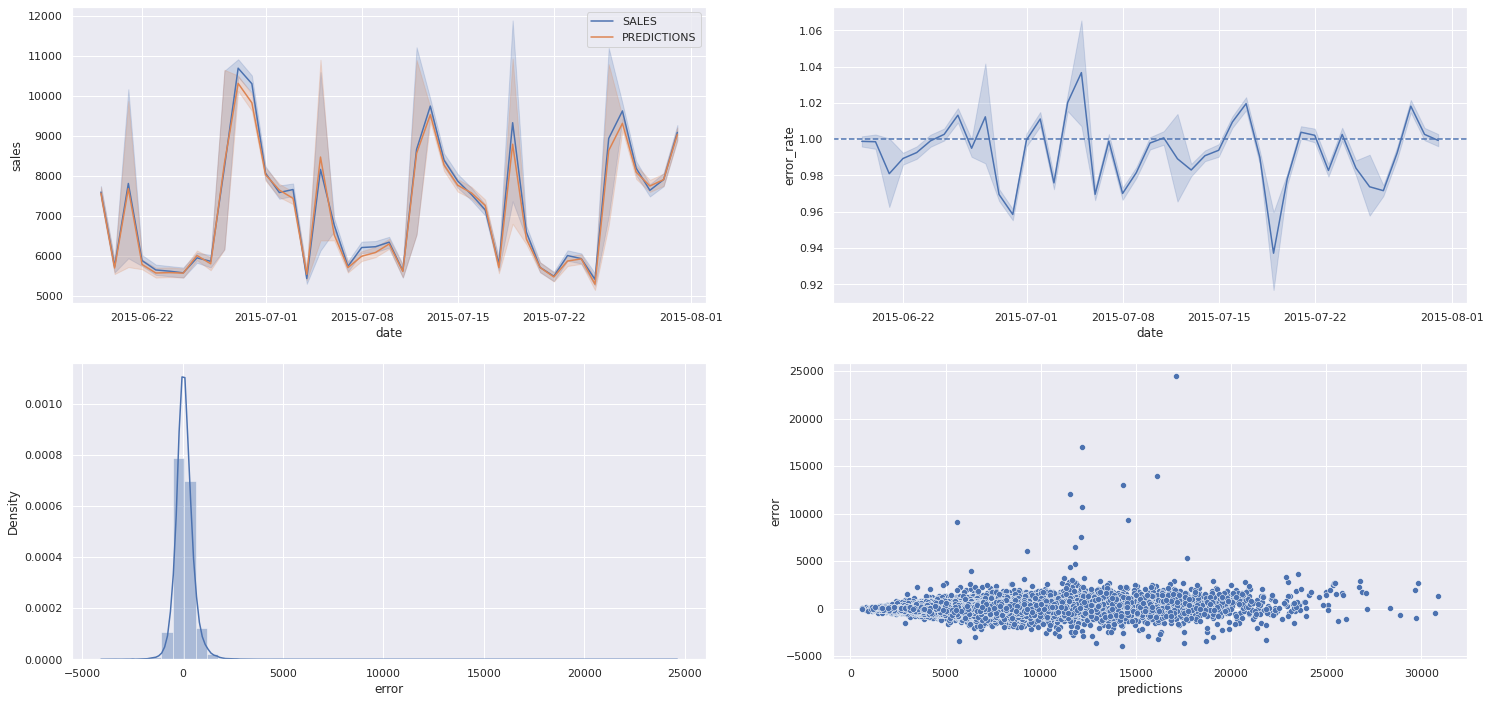

In [ ]:
# line plot with sales and its predicted values
plt.subplot(221)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES');
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS');

# error rate (predictions / sales)
plt.subplot(222)
sns.lineplot(x = 'date', y = 'error_rate', data = df9);
plt.axhline(1, linestyle = '--')

# error distribution (residual check)
plt.subplot(223)
sns.distplot(df9['error']);

# predictions vs error (residual check)
plt.subplot(224) 
sns.scatterplot(x = 'predictions', y = 'error', data = df9);